# Modelling with all features - forward stepwise selection of features  

In [3]:
#standard libraries 
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib import rcParams
%matplotlib inline

#data pre-processing 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#modelling 
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier, Pool, cv
from sklearn.tree import DecisionTreeClassifier


#evaluation 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

#feature importance 
import shap
shap.initjs()

#warnings 
import time 

import warnings

warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

In [4]:
# some functions 

def threshold_setting(y_probs, y_val): 
    """find the threshold which gives the best Fbeta score"""
    
    thresholds = [n/100 for n in range(101)]
    
    scores = []
    
    for threshold in thresholds:
        y_pred_class = np.where(y_probs > threshold, 1, 0)
        scores.append((fbeta_score(y_val, y_pred_class, beta=2), threshold))

    best_threshold = max(scores)[1]
    
    adj_class = np.where(y_probs > 0.25, 1, 0)
    final_score = fbeta_score(y_val, adj_class, beta=2)
    
    print(f"Best F2 score: {final_score} at a threshold of {best_threshold}")
    
    return(best_threshold, final_score)
    
    
    
def evaluate(y_pred_class, y_test, y_probs): 
    """Evaluate Model"""

    print('\n##### Evaluating Model #####')
    
    print("ROC AUC SCORE: {:.2f}".format(roc_auc_score(y_test, y_probs)))
    
    #confusion matrix 
    
    cm = confusion_matrix(y_test, y_pred_class)
    print('\n', cm)
    
    TN, FP, FN, TP = cm.ravel()
    
    print('\nTrue Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    #print metrics 
    print('\n')
    print('Recall:', recall_score(y_test, y_pred_class))
    print('Precision:', precision_score(y_test, y_pred_class))
    print('Specificity', TN/(TN+FP))
    print('F1 score:', f1_score(y_test, y_pred_class))
    print('F2 score:', fbeta_score(y_test, y_pred_class, beta=2))
    
    
    #precision_recall_curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_class)
    pyplot.plot(recall,precision, marker='.', label='model')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()
    
    
    return(TP, TN, FN, FP)

In [5]:
df = pd.read_csv('nhanes_extracted.csv')
df.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)

In [6]:
#remove participants with no laboratory values 
labs = ['Alanine Aminotransferase (ALT) (U/L)',
       'Albumin, refrigerated serum (g/dL)',
       'Alkaline Phosphatase (ALP) (U/L)',
       'Aspartate Aminotransferase (AST) (U/L)', 'Bicarbonate (mmol/L)',
       'Blood Urea Nitrogen (g/dL)', 'Chloride (mmol/L)',
       'Cholesterol, refrigerated serum (mg/dL)',
       'Creatinine, refrigerated serum (umol/L)',
       'Gamma Glutamyl Transferase (GGT) (U/L)',
       'Glucose, refrigerated serum (mmol/L)', 'Potassium (mmol/L)',
       'Sodium (mmol/L)', 'Total Bilirubin (umol/L)', 'Total Calcium (mmol/L)',
       'Triglycerides, refrig serum (mg/dL)', 'LDL cholesterol (mmol/L)',
       'HDL cholesterol (mmol/L)', 'eGFR', 'Fasting Glucose (mmol/L)',
       'Two Hour Glucose(OGTT) (mmol/L)']

In [7]:
df.dropna(how='all', subset=labs, inplace=True)

In [8]:
df.dropna(subset=['hba1c_result'], inplace=True)

In [9]:
df.shape

(21361, 42)

In [10]:
features = ['Age', 'bmi',
       'Alanine Aminotransferase (ALT) (U/L)',
       'Albumin, refrigerated serum (g/dL)',
       'Alkaline Phosphatase (ALP) (U/L)',
       'Aspartate Aminotransferase (AST) (U/L)', 'Bicarbonate (mmol/L)',
       'Blood Urea Nitrogen (g/dL)', 'Chloride (mmol/L)',
       'Cholesterol, refrigerated serum (mg/dL)',
       'Creatinine, refrigerated serum (umol/L)',
       'Gamma Glutamyl Transferase (GGT) (U/L)',
       'Glucose, refrigerated serum (mmol/L)', 'Potassium (mmol/L)',
       'Sodium (mmol/L)', 'Total Bilirubin (umol/L)', 'Total Calcium (mmol/L)',
       'Triglycerides, refrig serum (mg/dL)', 'LDL cholesterol (mmol/L)',
       'HDL cholesterol (mmol/L)',  'eGFR', 'MAP', 
       'Gender_1.0', 'Gender_2.0', 'Ethnicity_1.0',
       'Ethnicity_2.0', 'Ethnicity_3.0', 'Ethnicity_4.0', 'Ethnicity_5.0',
       'other_agents_0', 'other_agents_1', 'metformin_0', 'metformin_1',
       'insulin_0', 'insulin_1', 'statin_0', 'statin_1', 'ace_arbs_0',
       'ace_arbs_1']

In [11]:
#fill missing data with out-of-sample 
df.fillna(-999, inplace=True)

In [12]:
#one-hot-encoding of categorical variables
df = pd.get_dummies(df, columns = ['Gender', 'Ethnicity', 'other_agents', 'metformin', 'insulin', 'statin', 'ace_arbs'])

In [13]:
#target and feature selection 
y = df['diagnostic_t2dm']
X = df[features]

In [14]:
len(X.columns)

39

In [15]:
#split train-val-test datasets (85%, 5%, 10% respectively)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.056, random_state=1, stratify = y_train)

In [16]:
#scale data 
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X.columns)

_____
# Decision Tree

In [115]:
#instantiate model 
model = DecisionTreeClassifier(random_state = 42) 

In [116]:
#fit model
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [117]:
#predict
y_preds =  cross_val_predict(model, X_val, y_val, cv=5)

In [118]:
y_probs = cross_val_predict(model, X_val, y_val, cv=5, method='predict_proba')[:, 1]

In [120]:
#select threshold based on validate dataset 
threshold_setting(y_probs, y_val)

Best F2 score: 0.6840620592383638 at a threshold of 0.99


(0.99, 0.6840620592383638)

In [122]:
#make prediction on hold-out test set 
y_preds =  cross_val_predict(model, X_test, y_test, cv=5)
y_probs = cross_val_predict(model, X_test, y_test, cv=5, method='predict_proba')[:, 1]

In [123]:
#apply threshold to test set 
y_pred_class = np.where(y_probs > 0.99, 1, 0)


##### Evaluating Model #####
ROC AUC SCORE: 0.81

 [[1772   87]
 [  92  186]]

True Positives: 186
True Negatives: 1772
False Positives: 87
False Negatives: 92


Recall: 0.6690647482014388
Precision: 0.6813186813186813
Specificity 0.9532006455083378
F1 score: 0.67513611615245
F2 score: 0.6714801444043322


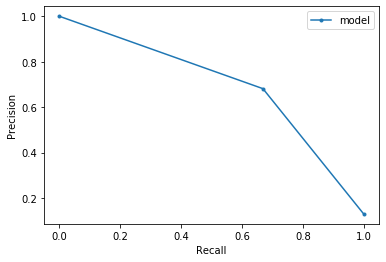

(186, 1772, 92, 87)

In [124]:
evaluate(y_pred_class, y_test, y_probs)

In [125]:
#optimisation 

dt_space = {"criterion": ['gini', 'entropy'], 
         "max_depth": [None, np.arange(1,1000,20)], 
         "min_samples_split": [2, 5, 10, 15, 20], 
         "min_samples_leaf": np.arange(1,25,5), 
         "max_features": ['auto', 'sqrt', 'log2'],
         "class_weight": [None, 'balanced']}

In [126]:
model_optimisation = RandomizedSearchCV(
            DecisionTreeClassifier(random_state=42), 
            dt_space,  
            n_iter=200, 
            n_jobs=-1, 
            random_state = 123, 
            cv=2, 
            verbose=2)

    
best_model = model_optimisation.fit(X_train, y_train)

Fitting 2 folds for each of 200 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    3.7s finished


In [127]:
best_model.best_params_

{'min_samples_split': 2,
 'min_samples_leaf': 21,
 'max_features': 'auto',
 'max_depth': None,
 'criterion': 'entropy',
 'class_weight': None}

In [128]:
final_model = DecisionTreeClassifier(**best_model.best_params_)

In [129]:
final_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=21, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [130]:
#predict
y_preds =  cross_val_predict(final_model, X_val, y_val, cv=5)
y_probs = cross_val_predict(final_model, X_val, y_val, cv=5, method='predict_proba')[:, 1]

In [131]:
threshold_setting(y_probs, y_val)

Best F2 score: 0.5650459921156373 at a threshold of 0.13


(0.13, 0.5650459921156373)

In [132]:
#predict on hold-out test set 
y_preds =  cross_val_predict(final_model, X_test, y_test, cv=5)
y_probs = cross_val_predict(final_model, X_test, y_test, cv=5, method='predict_proba')[:, 1]

In [133]:
#apply threshold 
y_pred_class = np.where(y_probs > 0.13, 1, 0)


##### Evaluating Model #####
ROC AUC SCORE: 0.87

 [[1551  308]
 [  59  219]]

True Positives: 219
True Negatives: 1551
False Positives: 308
False Negatives: 59


Recall: 0.7877697841726619
Precision: 0.4155597722960152
Specificity 0.834319526627219
F1 score: 0.5440993788819876
F2 score: 0.6680902989627823


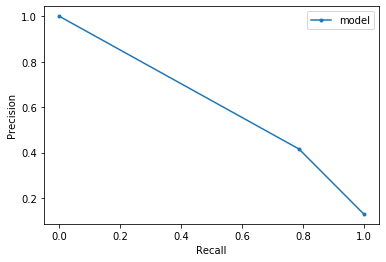

(219, 1551, 59, 308)

In [134]:
evaluate(y_pred_class, y_test, y_probs)

_________
# Random Forest

In [29]:
#instantiate model 
model = RandomForestClassifier(random_state = 42)

In [30]:
#fit model
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [31]:
#predict
y_preds =  cross_val_predict(model, X_val, y_val, cv=5)
y_probs = cross_val_predict(model, X_val, y_val, cv=5, method='predict_proba')[:, 1]

In [32]:
#select threshold based on validate dataset 
threshold_setting(y_probs, y_val)

Best F2 score: 0.7776261937244203 at a threshold of 0.36


(0.36, 0.7776261937244203)

In [33]:
#make prediction for hold-out test set 
y_preds =  cross_val_predict(model, X_test, y_test, cv=5)
y_probs = cross_val_predict(model, X_test, y_test, cv=5, method='predict_proba')[:, 1]

In [34]:
#apply threshold 
y_pred_class = np.where(y_probs > 0.36, 1, 0)


##### Evaluating Model #####
ROC AUC SCORE: 0.95

 [[1799   60]
 [  65  213]]

True Positives: 213
True Negatives: 1799
False Positives: 60
False Negatives: 65


Recall: 0.7661870503597122
Precision: 0.7802197802197802
Specificity 0.9677245831091985
F1 score: 0.7731397459165154
F2 score: 0.7689530685920578


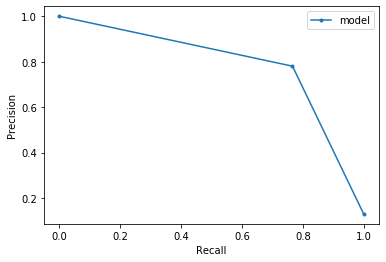

(0.7689530685920578, 213, 1799, 65, 60)

In [35]:
evaluate(y_pred_class, y_test, y_probs)

In [142]:
rf_space ={'n_estimators': np.arange(1, 2000, 20, dtype=int), 
        'max_depth': np.arange(1, 20, dtype=int),
        'min_samples_split': np.arange(2, 100, 10), 
        'min_samples_leaf': np.arange(1, 25, 5),
        'class_weight': ['balanced', 'balanced_subsample']}

In [143]:
model_optimisation = RandomizedSearchCV(
            RandomForestClassifier(), 
            rf_space,  
            n_iter=250, 
            n_jobs=-1, 
            random_state = 123, 
            cv=2, 
            verbose=2)

    
best_model = model_optimisation.fit(X_train, y_train)

Fitting 2 folds for each of 250 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 18.2min finished


In [144]:
best_model.best_params_

{'n_estimators': 1241,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 15,
 'class_weight': 'balanced_subsample'}

In [48]:
best_params_ = {'n_estimators': 1241,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 15,
 'class_weight': 'balanced_subsample', 
'random_state': 123}

In [49]:
final_model = RandomForestClassifier(**best_params_)

In [50]:
final_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1241, n_jobs=None, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)

In [51]:
#predict
y_preds =  cross_val_predict(final_model, X_val, y_val, cv=5)
y_probs = cross_val_predict(final_model, X_val, y_val, cv=5, method='predict_proba')[:, 1]

In [52]:
threshold_setting(y_probs, y_val)

Best F2 score: 0.7833787465940054 at a threshold of 0.18


(0.18, 0.7833787465940054)

In [53]:
#predict on hold-out test set 
y_preds =  cross_val_predict(final_model, X_test, y_test, cv=5)
y_probs = cross_val_predict(final_model, X_test, y_test, cv=5, method='predict_proba')[:, 1]

In [54]:
#apply threshold 
y_pred_class = np.where(y_probs > 0.18, 1, 0)


##### Evaluating Model #####
ROC AUC SCORE: 0.95

 [[1697  162]
 [  36  242]]

True Positives: 242
True Negatives: 1697
False Positives: 162
False Negatives: 36


Recall: 0.8705035971223022
Precision: 0.599009900990099
Specificity 0.9128563743948359
F1 score: 0.7096774193548386
F2 score: 0.7981530343007915


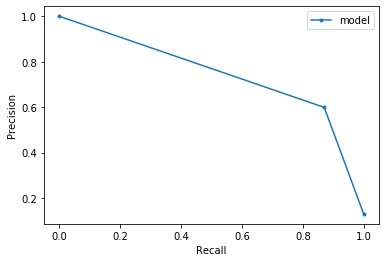

(0.7981530343007915, 242, 1697, 36, 162)

In [55]:
evaluate(y_pred_class, y_test, y_probs)

_________
# XGBoost 

In [160]:
#instantiate model 
model = xgb.XGBClassifier(random_seed = 42) 

In [161]:
#fit model
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_seed=42,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [162]:
#predict
y_preds =  cross_val_predict(model, X_val, y_val, cv=5)
y_probs = cross_val_predict(model, X_val, y_val, cv=5, method='predict_proba')[:, 1]

In [163]:
#select threshold based on validate dataset 
threshold_setting(y_probs, y_val)

Best F2 score: 0.7552447552447553 at a threshold of 0.1


(0.1, 0.7552447552447553)

In [164]:
#make prediction from the test set 
y_preds =  cross_val_predict(model, X_test, y_test, cv=5)
y_probs = cross_val_predict(model, X_test, y_test, cv=5, method='predict_proba')[:, 1]

In [165]:
#apply threshold 
y_pred_class = np.where(y_probs > 0.1, 1, 0)


##### Evaluating Model #####
ROC AUC SCORE: 0.95

 [[1682  177]
 [  36  242]]

True Positives: 242
True Negatives: 1682
False Positives: 177
False Negatives: 36


Recall: 0.8705035971223022
Precision: 0.5775656324582339
Specificity 0.9047875201721356
F1 score: 0.6944045911047346
F2 score: 0.7903331156107121


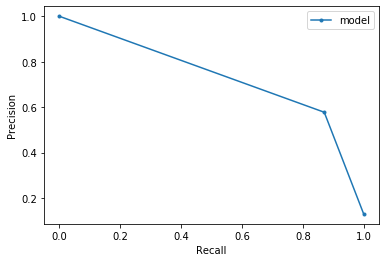

(242, 1682, 36, 177)

In [166]:
evaluate(y_pred_class, y_test, y_probs)

In [168]:
xgb_space ={'n_estimators': np.arange(1, 2000, 20, dtype=int),
        'learning_rate': np.linspace(0.0001, 0.9), 
        'max_depth': np.arange(1, 20, dtype=int),
        'subsample': np.arange(0.7, 1, 0.05),
        'gamma': np.arange(0.5, 1, 0.05),
        'colsample_bytree': np.arange(0.7, 1, 0.05),
        'reg_alpha' :  np.arange(0, 10, 1),
        'reg_lambda': np.arange(1, 2, 0.1), 
        'scale_pos_weight': np.arange(1, 100, 2)}

In [169]:
model_optimisation = RandomizedSearchCV(
            xgb.XGBClassifier(), 
            xgb_space,  
            n_iter=200, 
            n_jobs=-1, 
            random_state = 123, 
            cv=2, 
            verbose=2)

    
best_model = model_optimisation.fit(X_train, y_train)
    

Fitting 2 folds for each of 200 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 37.9min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 42.1min finished


In [170]:
best_model.best_params_

{'subsample': 0.9000000000000001,
 'scale_pos_weight': 1,
 'reg_lambda': 1.6000000000000005,
 'reg_alpha': 1,
 'n_estimators': 341,
 'max_depth': 11,
 'learning_rate': 0.05519591836734694,
 'gamma': 0.8500000000000003,
 'colsample_bytree': 0.7}

In [171]:
final_model = xgb.XGBClassifier(**best_model.best_params_)

In [172]:
final_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              gamma=0.8500000000000003, learning_rate=0.05519591836734694,
              max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
              n_estimators=341, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=1,
              reg_lambda=1.6000000000000005, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9000000000000001, verbosity=1)

In [173]:
#predict
y_preds =  cross_val_predict(model, X_val, y_val, cv=5)
y_probs = cross_val_predict(model, X_val, y_val, cv=5, method='predict_proba')[:, 1]

In [174]:
#select threshold based on validate dataset 
threshold_setting(y_probs, y_val)

Best F2 score: 0.7552447552447553 at a threshold of 0.1


(0.1, 0.7552447552447553)

In [175]:
#make prediction from the test set 
y_preds =  cross_val_predict(model, X_test, y_test, cv=5)
y_probs = cross_val_predict(model, X_test, y_test, cv=5, method='predict_proba')[:, 1]

In [176]:
#apply threshold 
y_pred_class = np.where(y_probs > 0.1, 1, 0)


##### Evaluating Model #####
ROC AUC SCORE: 0.95

 [[1682  177]
 [  36  242]]

True Positives: 242
True Negatives: 1682
False Positives: 177
False Negatives: 36


Recall: 0.8705035971223022
Precision: 0.5775656324582339
Specificity 0.9047875201721356
F1 score: 0.6944045911047346
F2 score: 0.7903331156107121


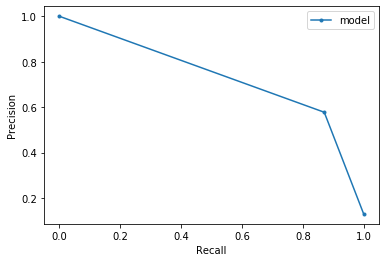

(242, 1682, 36, 177)

In [177]:
evaluate(y_pred_class, y_test, y_probs)

_____
# CatBoost 

In [180]:
df = pd.read_csv('nhanes_extracted.csv')
df.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)

In [181]:
df.dropna(how='all', subset=labs, inplace=True)

In [182]:
df.dropna(subset=['hba1c_result'], inplace=True)

In [183]:
#fill missing data with out-of-sample 
df.fillna(-999, inplace=True)

In [184]:
#assign categorical features 
df['Gender'] = df['Gender'].astype(str, copy=False)
df['Ethnicity'] = df['Ethnicity'].astype(str, copy=False)
df['insulin'] = df['insulin'].astype(str, copy=False)
df['metformin'] = df['metformin'].astype(str, copy=False)
df['other_agents'] = df['other_agents'].astype(str, copy=False)
df['statin'] = df['statin'].astype(str, copy=False)
df['ace_arbs'] = df['ace_arbs'].astype(str, copy=False)

In [188]:
df.columns

Index(['SEQN', 'Gender', 'Age', 'Ethnicity', 'FHx', 'Fasting Glucose (mmol/L)',
       'Two Hour Glucose(OGTT) (mmol/L)',
       'How long ago saw a diabetes specialist', 'Retinopathy',
       'Last time had pupils dilated for exam', 'bmi',
       'Alanine Aminotransferase (ALT) (U/L)',
       'Albumin, refrigerated serum (g/dL)',
       'Alkaline Phosphatase (ALP) (U/L)',
       'Aspartate Aminotransferase (AST) (U/L)', 'Bicarbonate (mmol/L)',
       'Blood Urea Nitrogen (g/dL)', 'Chloride (mmol/L)',
       'Cholesterol, refrigerated serum (mg/dL)',
       'Creatinine, refrigerated serum (umol/L)',
       'Gamma Glutamyl Transferase (GGT) (U/L)',
       'Glucose, refrigerated serum (mmol/L)', 'Potassium (mmol/L)',
       'Sodium (mmol/L)', 'Total Bilirubin (umol/L)', 'Total Calcium (mmol/L)',
       'Triglycerides, refrig serum (mg/dL)', 'LDL cholesterol (mmol/L)',
       'HDL cholesterol (mmol/L)', 'Prescriptions', 'insulin', 'statin',
       'metformin', 'other_agents', 'ace_arbs', 

In [195]:
features = ['Gender', 'Age', 'Ethnicity',  'bmi',
       'Alanine Aminotransferase (ALT) (U/L)',
       'Albumin, refrigerated serum (g/dL)',
       'Alkaline Phosphatase (ALP) (U/L)',
       'Aspartate Aminotransferase (AST) (U/L)', 'Bicarbonate (mmol/L)',
       'Blood Urea Nitrogen (g/dL)', 'Chloride (mmol/L)',
       'Cholesterol, refrigerated serum (mg/dL)',
       'Creatinine, refrigerated serum (umol/L)',
       'Gamma Glutamyl Transferase (GGT) (U/L)',
       'Glucose, refrigerated serum (mmol/L)', 'Potassium (mmol/L)',
       'Sodium (mmol/L)', 'Total Bilirubin (umol/L)', 'Total Calcium (mmol/L)',
       'Triglycerides, refrig serum (mg/dL)', 'LDL cholesterol (mmol/L)',
       'HDL cholesterol (mmol/L)', 'insulin', 'statin',
       'metformin', 'other_agents', 'ace_arbs', 'eGFR', 'MAP' ]

continuous = ['Age',  'bmi',
       'Alanine Aminotransferase (ALT) (U/L)',
       'Albumin, refrigerated serum (g/dL)',
       'Alkaline Phosphatase (ALP) (U/L)',
       'Aspartate Aminotransferase (AST) (U/L)', 'Bicarbonate (mmol/L)',
       'Blood Urea Nitrogen (g/dL)', 'Chloride (mmol/L)',
       'Cholesterol, refrigerated serum (mg/dL)',
       'Creatinine, refrigerated serum (umol/L)',
       'Gamma Glutamyl Transferase (GGT) (U/L)',
       'Glucose, refrigerated serum (mmol/L)', 'Potassium (mmol/L)',
       'Sodium (mmol/L)', 'Total Bilirubin (umol/L)', 'Total Calcium (mmol/L)',
       'Triglycerides, refrig serum (mg/dL)', 'LDL cholesterol (mmol/L)',
       'HDL cholesterol (mmol/L)', 'eGFR', 'MAP' ]

In [190]:
X = df[features]
y = df['diagnostic_t2dm']

In [192]:
#split into train-test (10% test and 15% validate)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.166666667, random_state=1, stratify = y_train)

In [193]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]

In [196]:
#scale data 
scaler = StandardScaler()

X_train[continuous] = scaler.fit_transform(X_train[continuous])
X_test[continuous] = scaler.transform(X_test[continuous])
X_val[continuous] = scaler.transform(X_val[continuous])

In [197]:
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_val, y_val, cat_features=categorical_features_indices)
test_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)

In [198]:
#instantiate model 
model = CatBoostClassifier(random_seed = 42) 

In [215]:
#fit model
model.fit(train_pool)

Learning rate set to 0.033675
0:	learn: 0.6465934	total: 26.2ms	remaining: 26.2s
1:	learn: 0.6024438	total: 46.4ms	remaining: 23.2s
2:	learn: 0.5642987	total: 67.6ms	remaining: 22.5s
3:	learn: 0.5265031	total: 79.7ms	remaining: 19.8s
4:	learn: 0.4959937	total: 91ms	remaining: 18.1s
5:	learn: 0.4616719	total: 107ms	remaining: 17.8s
6:	learn: 0.4371972	total: 125ms	remaining: 17.7s
7:	learn: 0.4107416	total: 135ms	remaining: 16.7s
8:	learn: 0.3875923	total: 148ms	remaining: 16.3s
9:	learn: 0.3687968	total: 158ms	remaining: 15.6s
10:	learn: 0.3511116	total: 168ms	remaining: 15.1s
11:	learn: 0.3328695	total: 180ms	remaining: 14.9s
12:	learn: 0.3174410	total: 190ms	remaining: 14.4s
13:	learn: 0.3041755	total: 207ms	remaining: 14.6s
14:	learn: 0.2929559	total: 227ms	remaining: 14.9s
15:	learn: 0.2802148	total: 245ms	remaining: 15.1s
16:	learn: 0.2694637	total: 266ms	remaining: 15.4s
17:	learn: 0.2595788	total: 293ms	remaining: 16s
18:	learn: 0.2505110	total: 303ms	remaining: 15.6s
19:	learn:

171:	learn: 0.1260703	total: 2.08s	remaining: 9.99s
172:	learn: 0.1260228	total: 2.09s	remaining: 9.99s
173:	learn: 0.1257984	total: 2.1s	remaining: 9.99s
174:	learn: 0.1256179	total: 2.11s	remaining: 9.96s
175:	learn: 0.1255301	total: 2.12s	remaining: 9.93s
176:	learn: 0.1254136	total: 2.13s	remaining: 9.91s
177:	learn: 0.1252973	total: 2.14s	remaining: 9.88s
178:	learn: 0.1252042	total: 2.15s	remaining: 9.86s
179:	learn: 0.1251767	total: 2.16s	remaining: 9.83s
180:	learn: 0.1250021	total: 2.17s	remaining: 9.81s
181:	learn: 0.1249167	total: 2.17s	remaining: 9.78s
182:	learn: 0.1247758	total: 2.19s	remaining: 9.75s
183:	learn: 0.1247180	total: 2.19s	remaining: 9.73s
184:	learn: 0.1246249	total: 2.2s	remaining: 9.7s
185:	learn: 0.1245416	total: 2.21s	remaining: 9.67s
186:	learn: 0.1243336	total: 2.22s	remaining: 9.65s
187:	learn: 0.1242848	total: 2.23s	remaining: 9.62s
188:	learn: 0.1241716	total: 2.24s	remaining: 9.6s
189:	learn: 0.1241582	total: 2.25s	remaining: 9.57s
190:	learn: 0.12

332:	learn: 0.1117727	total: 3.72s	remaining: 7.44s
333:	learn: 0.1116741	total: 3.73s	remaining: 7.45s
334:	learn: 0.1115652	total: 3.74s	remaining: 7.43s
335:	learn: 0.1114325	total: 3.75s	remaining: 7.42s
336:	learn: 0.1113999	total: 3.76s	remaining: 7.4s
337:	learn: 0.1113352	total: 3.77s	remaining: 7.38s
338:	learn: 0.1112672	total: 3.78s	remaining: 7.37s
339:	learn: 0.1112184	total: 3.79s	remaining: 7.35s
340:	learn: 0.1111606	total: 3.8s	remaining: 7.34s
341:	learn: 0.1111426	total: 3.81s	remaining: 7.32s
342:	learn: 0.1110934	total: 3.81s	remaining: 7.31s
343:	learn: 0.1110845	total: 3.82s	remaining: 7.29s
344:	learn: 0.1110325	total: 3.83s	remaining: 7.28s
345:	learn: 0.1109228	total: 3.84s	remaining: 7.26s
346:	learn: 0.1108661	total: 3.85s	remaining: 7.25s
347:	learn: 0.1107928	total: 3.86s	remaining: 7.23s
348:	learn: 0.1107599	total: 3.87s	remaining: 7.21s
349:	learn: 0.1106367	total: 3.88s	remaining: 7.2s
350:	learn: 0.1106286	total: 3.89s	remaining: 7.18s
351:	learn: 0.1

505:	learn: 0.0997181	total: 5.37s	remaining: 5.24s
506:	learn: 0.0996088	total: 5.38s	remaining: 5.24s
507:	learn: 0.0995619	total: 5.39s	remaining: 5.22s
508:	learn: 0.0994383	total: 5.4s	remaining: 5.21s
509:	learn: 0.0994027	total: 5.41s	remaining: 5.2s
510:	learn: 0.0993409	total: 5.42s	remaining: 5.19s
511:	learn: 0.0992571	total: 5.43s	remaining: 5.18s
512:	learn: 0.0991948	total: 5.44s	remaining: 5.17s
513:	learn: 0.0991207	total: 5.45s	remaining: 5.15s
514:	learn: 0.0990380	total: 5.46s	remaining: 5.14s
515:	learn: 0.0990113	total: 5.47s	remaining: 5.13s
516:	learn: 0.0989205	total: 5.48s	remaining: 5.12s
517:	learn: 0.0988444	total: 5.48s	remaining: 5.1s
518:	learn: 0.0987847	total: 5.49s	remaining: 5.09s
519:	learn: 0.0987810	total: 5.5s	remaining: 5.08s
520:	learn: 0.0986741	total: 5.51s	remaining: 5.07s
521:	learn: 0.0985838	total: 5.52s	remaining: 5.05s
522:	learn: 0.0985077	total: 5.53s	remaining: 5.04s
523:	learn: 0.0983996	total: 5.54s	remaining: 5.03s
524:	learn: 0.09

679:	learn: 0.0885680	total: 7.03s	remaining: 3.31s
680:	learn: 0.0885056	total: 7.04s	remaining: 3.3s
681:	learn: 0.0884492	total: 7.05s	remaining: 3.29s
682:	learn: 0.0884040	total: 7.06s	remaining: 3.28s
683:	learn: 0.0883801	total: 7.07s	remaining: 3.27s
684:	learn: 0.0883323	total: 7.08s	remaining: 3.25s
685:	learn: 0.0882780	total: 7.09s	remaining: 3.24s
686:	learn: 0.0882284	total: 7.1s	remaining: 3.23s
687:	learn: 0.0881446	total: 7.11s	remaining: 3.22s
688:	learn: 0.0880263	total: 7.11s	remaining: 3.21s
689:	learn: 0.0879774	total: 7.13s	remaining: 3.2s
690:	learn: 0.0878882	total: 7.13s	remaining: 3.19s
691:	learn: 0.0878143	total: 7.14s	remaining: 3.18s
692:	learn: 0.0877293	total: 7.15s	remaining: 3.17s
693:	learn: 0.0876475	total: 7.16s	remaining: 3.16s
694:	learn: 0.0875982	total: 7.17s	remaining: 3.15s
695:	learn: 0.0875498	total: 7.18s	remaining: 3.13s
696:	learn: 0.0875101	total: 7.19s	remaining: 3.12s
697:	learn: 0.0874415	total: 7.2s	remaining: 3.11s
698:	learn: 0.08

855:	learn: 0.0778371	total: 8.71s	remaining: 1.47s
856:	learn: 0.0778255	total: 8.72s	remaining: 1.46s
857:	learn: 0.0777734	total: 8.73s	remaining: 1.45s
858:	learn: 0.0777605	total: 8.74s	remaining: 1.43s
859:	learn: 0.0777239	total: 8.75s	remaining: 1.42s
860:	learn: 0.0775991	total: 8.76s	remaining: 1.41s
861:	learn: 0.0775718	total: 8.77s	remaining: 1.4s
862:	learn: 0.0775115	total: 8.78s	remaining: 1.39s
863:	learn: 0.0774631	total: 8.79s	remaining: 1.38s
864:	learn: 0.0773599	total: 8.79s	remaining: 1.37s
865:	learn: 0.0773440	total: 8.8s	remaining: 1.36s
866:	learn: 0.0772823	total: 8.81s	remaining: 1.35s
867:	learn: 0.0772562	total: 8.82s	remaining: 1.34s
868:	learn: 0.0771610	total: 8.83s	remaining: 1.33s
869:	learn: 0.0771281	total: 8.84s	remaining: 1.32s
870:	learn: 0.0770885	total: 8.85s	remaining: 1.31s
871:	learn: 0.0770312	total: 8.86s	remaining: 1.3s
872:	learn: 0.0769909	total: 8.87s	remaining: 1.29s
873:	learn: 0.0769483	total: 8.88s	remaining: 1.28s
874:	learn: 0.0

In [216]:
#predict
y_preds =  cross_val_predict(model, X_val, y_val, cv=5)
y_probs = cross_val_predict(model, X_val, y_val, cv=5, method='predict_proba')[:, 1]

Learning rate set to 0.015401
0:	learn: 0.6726230	total: 7.42ms	remaining: 7.41s
1:	learn: 0.6551884	total: 12.1ms	remaining: 6.04s
2:	learn: 0.6345621	total: 15.3ms	remaining: 5.07s
3:	learn: 0.6141108	total: 18.6ms	remaining: 4.63s
4:	learn: 0.5976264	total: 23.1ms	remaining: 4.59s
5:	learn: 0.5813684	total: 26.2ms	remaining: 4.34s
6:	learn: 0.5657584	total: 29.9ms	remaining: 4.25s
7:	learn: 0.5497492	total: 33.8ms	remaining: 4.19s
8:	learn: 0.5360876	total: 36.7ms	remaining: 4.04s
9:	learn: 0.5206522	total: 38.8ms	remaining: 3.84s
10:	learn: 0.5041559	total: 40.8ms	remaining: 3.67s
11:	learn: 0.4916253	total: 42.8ms	remaining: 3.52s
12:	learn: 0.4779727	total: 44.9ms	remaining: 3.41s
13:	learn: 0.4664288	total: 46.8ms	remaining: 3.3s
14:	learn: 0.4547309	total: 48.8ms	remaining: 3.21s
15:	learn: 0.4420396	total: 50.9ms	remaining: 3.13s
16:	learn: 0.4319367	total: 52.8ms	remaining: 3.06s
17:	learn: 0.4213481	total: 54.9ms	remaining: 2.99s
18:	learn: 0.4122874	total: 56.9ms	remaining:

222:	learn: 0.1154699	total: 576ms	remaining: 2.01s
223:	learn: 0.1152770	total: 580ms	remaining: 2.01s
224:	learn: 0.1151020	total: 584ms	remaining: 2.01s
225:	learn: 0.1149999	total: 588ms	remaining: 2.01s
226:	learn: 0.1148217	total: 591ms	remaining: 2.01s
227:	learn: 0.1147308	total: 595ms	remaining: 2.01s
228:	learn: 0.1145501	total: 598ms	remaining: 2.01s
229:	learn: 0.1143071	total: 602ms	remaining: 2.02s
230:	learn: 0.1139600	total: 605ms	remaining: 2.01s
231:	learn: 0.1137482	total: 607ms	remaining: 2.01s
232:	learn: 0.1135924	total: 609ms	remaining: 2s
233:	learn: 0.1133957	total: 611ms	remaining: 2s
234:	learn: 0.1131806	total: 613ms	remaining: 2s
235:	learn: 0.1130167	total: 615ms	remaining: 1.99s
236:	learn: 0.1127728	total: 617ms	remaining: 1.99s
237:	learn: 0.1125633	total: 621ms	remaining: 1.99s
238:	learn: 0.1123662	total: 623ms	remaining: 1.98s
239:	learn: 0.1120499	total: 625ms	remaining: 1.98s
240:	learn: 0.1117565	total: 627ms	remaining: 1.97s
241:	learn: 0.1115532

384:	learn: 0.0891347	total: 956ms	remaining: 1.53s
385:	learn: 0.0890039	total: 961ms	remaining: 1.53s
386:	learn: 0.0888198	total: 965ms	remaining: 1.53s
387:	learn: 0.0886711	total: 969ms	remaining: 1.53s
388:	learn: 0.0885324	total: 973ms	remaining: 1.53s
389:	learn: 0.0883452	total: 977ms	remaining: 1.53s
390:	learn: 0.0881699	total: 981ms	remaining: 1.53s
391:	learn: 0.0880844	total: 983ms	remaining: 1.52s
392:	learn: 0.0879779	total: 985ms	remaining: 1.52s
393:	learn: 0.0879233	total: 987ms	remaining: 1.52s
394:	learn: 0.0878457	total: 989ms	remaining: 1.51s
395:	learn: 0.0876964	total: 991ms	remaining: 1.51s
396:	learn: 0.0875930	total: 993ms	remaining: 1.51s
397:	learn: 0.0874461	total: 996ms	remaining: 1.51s
398:	learn: 0.0874137	total: 998ms	remaining: 1.5s
399:	learn: 0.0872244	total: 1s	remaining: 1.5s
400:	learn: 0.0871522	total: 1s	remaining: 1.5s
401:	learn: 0.0869645	total: 1s	remaining: 1.49s
402:	learn: 0.0868922	total: 1.01s	remaining: 1.49s
403:	learn: 0.0868309	to

549:	learn: 0.0703028	total: 1.33s	remaining: 1.09s
550:	learn: 0.0702130	total: 1.34s	remaining: 1.09s
551:	learn: 0.0701723	total: 1.34s	remaining: 1.09s
552:	learn: 0.0701325	total: 1.35s	remaining: 1.09s
553:	learn: 0.0700296	total: 1.35s	remaining: 1.09s
554:	learn: 0.0699930	total: 1.35s	remaining: 1.09s
555:	learn: 0.0699438	total: 1.36s	remaining: 1.08s
556:	learn: 0.0698230	total: 1.36s	remaining: 1.08s
557:	learn: 0.0697056	total: 1.36s	remaining: 1.08s
558:	learn: 0.0696222	total: 1.36s	remaining: 1.08s
559:	learn: 0.0695430	total: 1.37s	remaining: 1.07s
560:	learn: 0.0694037	total: 1.37s	remaining: 1.07s
561:	learn: 0.0692980	total: 1.37s	remaining: 1.07s
562:	learn: 0.0691989	total: 1.37s	remaining: 1.07s
563:	learn: 0.0691681	total: 1.38s	remaining: 1.06s
564:	learn: 0.0691390	total: 1.38s	remaining: 1.06s
565:	learn: 0.0690817	total: 1.38s	remaining: 1.06s
566:	learn: 0.0689762	total: 1.38s	remaining: 1.06s
567:	learn: 0.0689602	total: 1.39s	remaining: 1.05s
568:	learn: 

721:	learn: 0.0569350	total: 1.71s	remaining: 660ms
722:	learn: 0.0569159	total: 1.72s	remaining: 658ms
723:	learn: 0.0568747	total: 1.72s	remaining: 656ms
724:	learn: 0.0568251	total: 1.73s	remaining: 654ms
725:	learn: 0.0567043	total: 1.73s	remaining: 653ms
726:	learn: 0.0565617	total: 1.73s	remaining: 651ms
727:	learn: 0.0563863	total: 1.74s	remaining: 649ms
728:	learn: 0.0563449	total: 1.74s	remaining: 646ms
729:	learn: 0.0561738	total: 1.74s	remaining: 644ms
730:	learn: 0.0560598	total: 1.74s	remaining: 642ms
731:	learn: 0.0560509	total: 1.75s	remaining: 639ms
732:	learn: 0.0559700	total: 1.75s	remaining: 637ms
733:	learn: 0.0558499	total: 1.75s	remaining: 634ms
734:	learn: 0.0558396	total: 1.75s	remaining: 632ms
735:	learn: 0.0558159	total: 1.75s	remaining: 629ms
736:	learn: 0.0557726	total: 1.76s	remaining: 627ms
737:	learn: 0.0556757	total: 1.76s	remaining: 624ms
738:	learn: 0.0556572	total: 1.76s	remaining: 622ms
739:	learn: 0.0555767	total: 1.76s	remaining: 619ms
740:	learn: 

898:	learn: 0.0465124	total: 2.1s	remaining: 235ms
899:	learn: 0.0464848	total: 2.1s	remaining: 234ms
900:	learn: 0.0464562	total: 2.11s	remaining: 232ms
901:	learn: 0.0464312	total: 2.11s	remaining: 229ms
902:	learn: 0.0463716	total: 2.11s	remaining: 227ms
903:	learn: 0.0463027	total: 2.12s	remaining: 225ms
904:	learn: 0.0462647	total: 2.12s	remaining: 223ms
905:	learn: 0.0462510	total: 2.12s	remaining: 220ms
906:	learn: 0.0461492	total: 2.13s	remaining: 218ms
907:	learn: 0.0460882	total: 2.13s	remaining: 216ms
908:	learn: 0.0460812	total: 2.13s	remaining: 213ms
909:	learn: 0.0460308	total: 2.13s	remaining: 211ms
910:	learn: 0.0460139	total: 2.13s	remaining: 208ms
911:	learn: 0.0459779	total: 2.14s	remaining: 206ms
912:	learn: 0.0458596	total: 2.14s	remaining: 204ms
913:	learn: 0.0458216	total: 2.14s	remaining: 201ms
914:	learn: 0.0457632	total: 2.14s	remaining: 199ms
915:	learn: 0.0456298	total: 2.14s	remaining: 197ms
916:	learn: 0.0455977	total: 2.15s	remaining: 194ms
917:	learn: 0.

58:	learn: 0.2140173	total: 119ms	remaining: 1.89s
59:	learn: 0.2116083	total: 122ms	remaining: 1.91s
60:	learn: 0.2100930	total: 126ms	remaining: 1.94s
61:	learn: 0.2081165	total: 130ms	remaining: 1.97s
62:	learn: 0.2059642	total: 133ms	remaining: 1.99s
63:	learn: 0.2033146	total: 137ms	remaining: 2s
64:	learn: 0.2012911	total: 140ms	remaining: 2.02s
65:	learn: 0.1993358	total: 142ms	remaining: 2.02s
66:	learn: 0.1972982	total: 145ms	remaining: 2.01s
67:	learn: 0.1958160	total: 147ms	remaining: 2.01s
68:	learn: 0.1940568	total: 149ms	remaining: 2.01s
69:	learn: 0.1932368	total: 151ms	remaining: 2s
70:	learn: 0.1919939	total: 153ms	remaining: 2s
71:	learn: 0.1906681	total: 155ms	remaining: 2s
72:	learn: 0.1890098	total: 157ms	remaining: 1.99s
73:	learn: 0.1871775	total: 159ms	remaining: 1.99s
74:	learn: 0.1860211	total: 161ms	remaining: 1.99s
75:	learn: 0.1845078	total: 163ms	remaining: 1.99s
76:	learn: 0.1829881	total: 166ms	remaining: 1.99s
77:	learn: 0.1814477	total: 168ms	remaining

256:	learn: 0.1064830	total: 695ms	remaining: 2.01s
257:	learn: 0.1062257	total: 699ms	remaining: 2.01s
258:	learn: 0.1060541	total: 702ms	remaining: 2.01s
259:	learn: 0.1057777	total: 705ms	remaining: 2.01s
260:	learn: 0.1057156	total: 709ms	remaining: 2.01s
261:	learn: 0.1055373	total: 712ms	remaining: 2.01s
262:	learn: 0.1053348	total: 715ms	remaining: 2s
263:	learn: 0.1051278	total: 719ms	remaining: 2s
264:	learn: 0.1050068	total: 721ms	remaining: 2s
265:	learn: 0.1048633	total: 723ms	remaining: 1.99s
266:	learn: 0.1045827	total: 724ms	remaining: 1.99s
267:	learn: 0.1044533	total: 726ms	remaining: 1.98s
268:	learn: 0.1042520	total: 728ms	remaining: 1.98s
269:	learn: 0.1040558	total: 730ms	remaining: 1.97s
270:	learn: 0.1038680	total: 732ms	remaining: 1.97s
271:	learn: 0.1036003	total: 735ms	remaining: 1.97s
272:	learn: 0.1034332	total: 737ms	remaining: 1.96s
273:	learn: 0.1032944	total: 739ms	remaining: 1.96s
274:	learn: 0.1030985	total: 741ms	remaining: 1.95s
275:	learn: 0.1029446

440:	learn: 0.0788447	total: 1.07s	remaining: 1.36s
441:	learn: 0.0787531	total: 1.08s	remaining: 1.36s
442:	learn: 0.0786457	total: 1.08s	remaining: 1.36s
443:	learn: 0.0785866	total: 1.08s	remaining: 1.36s
444:	learn: 0.0784182	total: 1.09s	remaining: 1.36s
445:	learn: 0.0782781	total: 1.09s	remaining: 1.35s
446:	learn: 0.0781352	total: 1.09s	remaining: 1.35s
447:	learn: 0.0780815	total: 1.1s	remaining: 1.35s
448:	learn: 0.0779641	total: 1.1s	remaining: 1.35s
449:	learn: 0.0779171	total: 1.1s	remaining: 1.35s
450:	learn: 0.0777991	total: 1.1s	remaining: 1.34s
451:	learn: 0.0776460	total: 1.1s	remaining: 1.34s
452:	learn: 0.0775453	total: 1.11s	remaining: 1.34s
453:	learn: 0.0773402	total: 1.11s	remaining: 1.33s
454:	learn: 0.0772377	total: 1.11s	remaining: 1.33s
455:	learn: 0.0771988	total: 1.11s	remaining: 1.33s
456:	learn: 0.0770635	total: 1.11s	remaining: 1.32s
457:	learn: 0.0769705	total: 1.12s	remaining: 1.32s
458:	learn: 0.0768833	total: 1.12s	remaining: 1.32s
459:	learn: 0.076

618:	learn: 0.0608469	total: 1.45s	remaining: 895ms
619:	learn: 0.0607704	total: 1.46s	remaining: 893ms
620:	learn: 0.0606983	total: 1.46s	remaining: 892ms
621:	learn: 0.0605537	total: 1.46s	remaining: 890ms
622:	learn: 0.0604696	total: 1.47s	remaining: 888ms
623:	learn: 0.0603770	total: 1.47s	remaining: 887ms
624:	learn: 0.0603026	total: 1.47s	remaining: 885ms
625:	learn: 0.0602053	total: 1.48s	remaining: 882ms
626:	learn: 0.0601450	total: 1.48s	remaining: 881ms
627:	learn: 0.0601136	total: 1.49s	remaining: 880ms
628:	learn: 0.0600879	total: 1.49s	remaining: 878ms
629:	learn: 0.0600581	total: 1.49s	remaining: 876ms
630:	learn: 0.0599551	total: 1.49s	remaining: 874ms
631:	learn: 0.0598314	total: 1.5s	remaining: 872ms
632:	learn: 0.0597341	total: 1.5s	remaining: 870ms
633:	learn: 0.0597094	total: 1.5s	remaining: 868ms
634:	learn: 0.0596810	total: 1.51s	remaining: 866ms
635:	learn: 0.0596430	total: 1.51s	remaining: 865ms
636:	learn: 0.0595624	total: 1.51s	remaining: 863ms
637:	learn: 0.0

782:	learn: 0.0486945	total: 1.83s	remaining: 508ms
783:	learn: 0.0486752	total: 1.84s	remaining: 506ms
784:	learn: 0.0485908	total: 1.84s	remaining: 504ms
785:	learn: 0.0484727	total: 1.84s	remaining: 502ms
786:	learn: 0.0484081	total: 1.85s	remaining: 500ms
787:	learn: 0.0483147	total: 1.85s	remaining: 498ms
788:	learn: 0.0482218	total: 1.85s	remaining: 496ms
789:	learn: 0.0482071	total: 1.86s	remaining: 494ms
790:	learn: 0.0480775	total: 1.86s	remaining: 492ms
791:	learn: 0.0480403	total: 1.86s	remaining: 489ms
792:	learn: 0.0480219	total: 1.86s	remaining: 487ms
793:	learn: 0.0480082	total: 1.87s	remaining: 484ms
794:	learn: 0.0479635	total: 1.87s	remaining: 482ms
795:	learn: 0.0478888	total: 1.87s	remaining: 479ms
796:	learn: 0.0478434	total: 1.87s	remaining: 477ms
797:	learn: 0.0477721	total: 1.88s	remaining: 475ms
798:	learn: 0.0477094	total: 1.88s	remaining: 472ms
799:	learn: 0.0476243	total: 1.88s	remaining: 470ms
800:	learn: 0.0475267	total: 1.88s	remaining: 467ms
801:	learn: 

965:	learn: 0.0383283	total: 2.21s	remaining: 77.9ms
966:	learn: 0.0381897	total: 2.22s	remaining: 75.7ms
967:	learn: 0.0381150	total: 2.22s	remaining: 73.4ms
968:	learn: 0.0381066	total: 2.23s	remaining: 71.2ms
969:	learn: 0.0380600	total: 2.23s	remaining: 68.9ms
970:	learn: 0.0379895	total: 2.23s	remaining: 66.7ms
971:	learn: 0.0378836	total: 2.24s	remaining: 64.4ms
972:	learn: 0.0378754	total: 2.24s	remaining: 62.1ms
973:	learn: 0.0378673	total: 2.24s	remaining: 59.8ms
974:	learn: 0.0378252	total: 2.24s	remaining: 57.5ms
975:	learn: 0.0377477	total: 2.24s	remaining: 55.2ms
976:	learn: 0.0377050	total: 2.25s	remaining: 52.9ms
977:	learn: 0.0376970	total: 2.25s	remaining: 50.6ms
978:	learn: 0.0376288	total: 2.25s	remaining: 48.3ms
979:	learn: 0.0375740	total: 2.26s	remaining: 46.1ms
980:	learn: 0.0375666	total: 2.26s	remaining: 43.8ms
981:	learn: 0.0375589	total: 2.27s	remaining: 41.5ms
982:	learn: 0.0375175	total: 2.27s	remaining: 39.2ms
983:	learn: 0.0374931	total: 2.27s	remaining: 

206:	learn: 0.1092549	total: 426ms	remaining: 1.63s
207:	learn: 0.1091078	total: 430ms	remaining: 1.64s
208:	learn: 0.1089152	total: 434ms	remaining: 1.64s
209:	learn: 0.1086971	total: 437ms	remaining: 1.64s
210:	learn: 0.1084849	total: 441ms	remaining: 1.65s
211:	learn: 0.1082704	total: 444ms	remaining: 1.65s
212:	learn: 0.1079882	total: 448ms	remaining: 1.66s
213:	learn: 0.1078443	total: 452ms	remaining: 1.66s
214:	learn: 0.1076648	total: 455ms	remaining: 1.66s
215:	learn: 0.1074432	total: 457ms	remaining: 1.66s
216:	learn: 0.1073699	total: 458ms	remaining: 1.65s
217:	learn: 0.1071005	total: 460ms	remaining: 1.65s
218:	learn: 0.1069574	total: 462ms	remaining: 1.65s
219:	learn: 0.1067816	total: 464ms	remaining: 1.65s
220:	learn: 0.1064563	total: 467ms	remaining: 1.65s
221:	learn: 0.1062514	total: 470ms	remaining: 1.65s
222:	learn: 0.1061431	total: 472ms	remaining: 1.64s
223:	learn: 0.1059234	total: 474ms	remaining: 1.64s
224:	learn: 0.1057438	total: 475ms	remaining: 1.64s
225:	learn: 

388:	learn: 0.0791885	total: 804ms	remaining: 1.26s
389:	learn: 0.0789869	total: 808ms	remaining: 1.26s
390:	learn: 0.0789370	total: 812ms	remaining: 1.26s
391:	learn: 0.0788078	total: 815ms	remaining: 1.26s
392:	learn: 0.0787076	total: 819ms	remaining: 1.26s
393:	learn: 0.0785006	total: 823ms	remaining: 1.26s
394:	learn: 0.0783021	total: 826ms	remaining: 1.26s
395:	learn: 0.0781094	total: 828ms	remaining: 1.26s
396:	learn: 0.0779693	total: 830ms	remaining: 1.26s
397:	learn: 0.0777284	total: 832ms	remaining: 1.26s
398:	learn: 0.0776284	total: 834ms	remaining: 1.26s
399:	learn: 0.0775489	total: 836ms	remaining: 1.25s
400:	learn: 0.0774813	total: 838ms	remaining: 1.25s
401:	learn: 0.0773143	total: 840ms	remaining: 1.25s
402:	learn: 0.0772225	total: 843ms	remaining: 1.25s
403:	learn: 0.0771030	total: 846ms	remaining: 1.25s
404:	learn: 0.0769407	total: 848ms	remaining: 1.25s
405:	learn: 0.0768434	total: 850ms	remaining: 1.24s
406:	learn: 0.0767875	total: 851ms	remaining: 1.24s
407:	learn: 

568:	learn: 0.0592757	total: 1.18s	remaining: 896ms
569:	learn: 0.0591850	total: 1.19s	remaining: 895ms
570:	learn: 0.0590820	total: 1.19s	remaining: 894ms
571:	learn: 0.0589832	total: 1.19s	remaining: 893ms
572:	learn: 0.0588391	total: 1.2s	remaining: 892ms
573:	learn: 0.0587563	total: 1.2s	remaining: 891ms
574:	learn: 0.0587032	total: 1.2s	remaining: 891ms
575:	learn: 0.0585630	total: 1.21s	remaining: 888ms
576:	learn: 0.0585031	total: 1.21s	remaining: 886ms
577:	learn: 0.0584046	total: 1.21s	remaining: 884ms
578:	learn: 0.0583759	total: 1.21s	remaining: 882ms
579:	learn: 0.0582417	total: 1.21s	remaining: 880ms
580:	learn: 0.0581724	total: 1.22s	remaining: 877ms
581:	learn: 0.0581378	total: 1.22s	remaining: 875ms
582:	learn: 0.0580626	total: 1.22s	remaining: 874ms
583:	learn: 0.0580335	total: 1.22s	remaining: 872ms
584:	learn: 0.0579472	total: 1.23s	remaining: 869ms
585:	learn: 0.0577992	total: 1.23s	remaining: 867ms
586:	learn: 0.0576990	total: 1.23s	remaining: 865ms
587:	learn: 0.0

751:	learn: 0.0450047	total: 1.56s	remaining: 515ms
752:	learn: 0.0449689	total: 1.57s	remaining: 514ms
753:	learn: 0.0449398	total: 1.57s	remaining: 512ms
754:	learn: 0.0448680	total: 1.57s	remaining: 511ms
755:	learn: 0.0448191	total: 1.58s	remaining: 509ms
756:	learn: 0.0447790	total: 1.58s	remaining: 508ms
757:	learn: 0.0447527	total: 1.58s	remaining: 506ms
758:	learn: 0.0446736	total: 1.59s	remaining: 504ms
759:	learn: 0.0445993	total: 1.59s	remaining: 502ms
760:	learn: 0.0445043	total: 1.59s	remaining: 500ms
761:	learn: 0.0444153	total: 1.59s	remaining: 498ms
762:	learn: 0.0443530	total: 1.59s	remaining: 496ms
763:	learn: 0.0442901	total: 1.6s	remaining: 494ms
764:	learn: 0.0442449	total: 1.6s	remaining: 491ms
765:	learn: 0.0441307	total: 1.6s	remaining: 489ms
766:	learn: 0.0441158	total: 1.6s	remaining: 487ms
767:	learn: 0.0440291	total: 1.6s	remaining: 485ms
768:	learn: 0.0440140	total: 1.61s	remaining: 483ms
769:	learn: 0.0439264	total: 1.61s	remaining: 481ms
770:	learn: 0.043

933:	learn: 0.0345108	total: 1.94s	remaining: 137ms
934:	learn: 0.0344834	total: 1.95s	remaining: 135ms
935:	learn: 0.0344434	total: 1.95s	remaining: 133ms
936:	learn: 0.0343974	total: 1.95s	remaining: 131ms
937:	learn: 0.0343457	total: 1.96s	remaining: 129ms
938:	learn: 0.0342747	total: 1.96s	remaining: 127ms
939:	learn: 0.0342423	total: 1.96s	remaining: 125ms
940:	learn: 0.0342116	total: 1.97s	remaining: 123ms
941:	learn: 0.0341870	total: 1.97s	remaining: 121ms
942:	learn: 0.0341530	total: 1.97s	remaining: 119ms
943:	learn: 0.0341082	total: 1.97s	remaining: 117ms
944:	learn: 0.0340846	total: 1.98s	remaining: 115ms
945:	learn: 0.0340466	total: 1.98s	remaining: 113ms
946:	learn: 0.0340233	total: 1.98s	remaining: 111ms
947:	learn: 0.0339785	total: 1.98s	remaining: 109ms
948:	learn: 0.0339127	total: 1.98s	remaining: 107ms
949:	learn: 0.0338452	total: 1.99s	remaining: 105ms
950:	learn: 0.0338185	total: 1.99s	remaining: 102ms
951:	learn: 0.0337628	total: 1.99s	remaining: 100ms
952:	learn: 

99:	learn: 0.1577155	total: 204ms	remaining: 1.84s
100:	learn: 0.1571465	total: 208ms	remaining: 1.85s
101:	learn: 0.1564488	total: 212ms	remaining: 1.87s
102:	learn: 0.1558862	total: 216ms	remaining: 1.89s
103:	learn: 0.1548419	total: 220ms	remaining: 1.9s
104:	learn: 0.1539439	total: 224ms	remaining: 1.91s
105:	learn: 0.1530967	total: 227ms	remaining: 1.92s
106:	learn: 0.1526649	total: 229ms	remaining: 1.91s
107:	learn: 0.1522500	total: 231ms	remaining: 1.91s
108:	learn: 0.1514936	total: 233ms	remaining: 1.91s
109:	learn: 0.1508589	total: 235ms	remaining: 1.9s
110:	learn: 0.1503597	total: 237ms	remaining: 1.9s
111:	learn: 0.1498257	total: 239ms	remaining: 1.89s
112:	learn: 0.1492436	total: 241ms	remaining: 1.89s
113:	learn: 0.1487085	total: 244ms	remaining: 1.9s
114:	learn: 0.1479424	total: 246ms	remaining: 1.89s
115:	learn: 0.1473120	total: 248ms	remaining: 1.89s
116:	learn: 0.1467826	total: 250ms	remaining: 1.89s
117:	learn: 0.1462932	total: 252ms	remaining: 1.88s
118:	learn: 0.145

281:	learn: 0.1024402	total: 582ms	remaining: 1.48s
282:	learn: 0.1023517	total: 585ms	remaining: 1.48s
283:	learn: 0.1021136	total: 591ms	remaining: 1.49s
284:	learn: 0.1019888	total: 596ms	remaining: 1.49s
285:	learn: 0.1019096	total: 601ms	remaining: 1.5s
286:	learn: 0.1018479	total: 605ms	remaining: 1.5s
287:	learn: 0.1017728	total: 608ms	remaining: 1.5s
288:	learn: 0.1016751	total: 610ms	remaining: 1.5s
289:	learn: 0.1014401	total: 612ms	remaining: 1.5s
290:	learn: 0.1013199	total: 614ms	remaining: 1.5s
291:	learn: 0.1011979	total: 616ms	remaining: 1.49s
292:	learn: 0.1010952	total: 618ms	remaining: 1.49s
293:	learn: 0.1009867	total: 620ms	remaining: 1.49s
294:	learn: 0.1008168	total: 622ms	remaining: 1.49s
295:	learn: 0.1006467	total: 624ms	remaining: 1.48s
296:	learn: 0.1005457	total: 626ms	remaining: 1.48s
297:	learn: 0.1003519	total: 629ms	remaining: 1.48s
298:	learn: 0.1003140	total: 631ms	remaining: 1.48s
299:	learn: 0.1000802	total: 633ms	remaining: 1.48s
300:	learn: 0.0998

509:	learn: 0.0728311	total: 1.15s	remaining: 1.1s
510:	learn: 0.0727853	total: 1.15s	remaining: 1.1s
511:	learn: 0.0726859	total: 1.16s	remaining: 1.1s
512:	learn: 0.0725209	total: 1.16s	remaining: 1.1s
513:	learn: 0.0724040	total: 1.16s	remaining: 1.1s
514:	learn: 0.0722734	total: 1.17s	remaining: 1.1s
515:	learn: 0.0721568	total: 1.17s	remaining: 1.1s
516:	learn: 0.0720847	total: 1.18s	remaining: 1.1s
517:	learn: 0.0719553	total: 1.18s	remaining: 1.09s
518:	learn: 0.0717808	total: 1.18s	remaining: 1.09s
519:	learn: 0.0717379	total: 1.18s	remaining: 1.09s
520:	learn: 0.0716050	total: 1.18s	remaining: 1.09s
521:	learn: 0.0714512	total: 1.19s	remaining: 1.09s
522:	learn: 0.0713401	total: 1.19s	remaining: 1.08s
523:	learn: 0.0712178	total: 1.19s	remaining: 1.08s
524:	learn: 0.0711258	total: 1.19s	remaining: 1.08s
525:	learn: 0.0709731	total: 1.19s	remaining: 1.08s
526:	learn: 0.0709075	total: 1.2s	remaining: 1.07s
527:	learn: 0.0707506	total: 1.2s	remaining: 1.07s
528:	learn: 0.0706227	

692:	learn: 0.0554410	total: 1.53s	remaining: 677ms
693:	learn: 0.0553552	total: 1.53s	remaining: 676ms
694:	learn: 0.0552054	total: 1.54s	remaining: 674ms
695:	learn: 0.0551192	total: 1.54s	remaining: 673ms
696:	learn: 0.0550160	total: 1.54s	remaining: 671ms
697:	learn: 0.0549416	total: 1.55s	remaining: 670ms
698:	learn: 0.0548079	total: 1.55s	remaining: 668ms
699:	learn: 0.0547422	total: 1.55s	remaining: 666ms
700:	learn: 0.0547251	total: 1.55s	remaining: 664ms
701:	learn: 0.0546587	total: 1.56s	remaining: 661ms
702:	learn: 0.0544674	total: 1.56s	remaining: 659ms
703:	learn: 0.0543726	total: 1.56s	remaining: 657ms
704:	learn: 0.0542377	total: 1.56s	remaining: 654ms
705:	learn: 0.0541461	total: 1.56s	remaining: 652ms
706:	learn: 0.0540653	total: 1.57s	remaining: 650ms
707:	learn: 0.0540294	total: 1.57s	remaining: 648ms
708:	learn: 0.0539507	total: 1.57s	remaining: 645ms
709:	learn: 0.0538698	total: 1.57s	remaining: 643ms
710:	learn: 0.0537500	total: 1.58s	remaining: 641ms
711:	learn: 

872:	learn: 0.0418813	total: 1.91s	remaining: 278ms
873:	learn: 0.0418550	total: 1.91s	remaining: 276ms
874:	learn: 0.0418207	total: 1.92s	remaining: 274ms
875:	learn: 0.0417845	total: 1.92s	remaining: 272ms
876:	learn: 0.0417100	total: 1.93s	remaining: 270ms
877:	learn: 0.0416748	total: 1.93s	remaining: 268ms
878:	learn: 0.0416444	total: 1.93s	remaining: 266ms
879:	learn: 0.0416182	total: 1.94s	remaining: 264ms
880:	learn: 0.0415795	total: 1.94s	remaining: 262ms
881:	learn: 0.0415060	total: 1.94s	remaining: 259ms
882:	learn: 0.0414133	total: 1.94s	remaining: 257ms
883:	learn: 0.0413462	total: 1.94s	remaining: 255ms
884:	learn: 0.0412635	total: 1.95s	remaining: 253ms
885:	learn: 0.0412063	total: 1.95s	remaining: 251ms
886:	learn: 0.0411065	total: 1.95s	remaining: 248ms
887:	learn: 0.0410099	total: 1.95s	remaining: 246ms
888:	learn: 0.0409729	total: 1.95s	remaining: 244ms
889:	learn: 0.0408932	total: 1.96s	remaining: 242ms
890:	learn: 0.0408689	total: 1.96s	remaining: 239ms
891:	learn: 

36:	learn: 0.2828114	total: 73.1ms	remaining: 1.9s
37:	learn: 0.2778932	total: 77.1ms	remaining: 1.95s
38:	learn: 0.2747994	total: 81.2ms	remaining: 2s
39:	learn: 0.2710240	total: 84.6ms	remaining: 2.03s
40:	learn: 0.2671856	total: 88.6ms	remaining: 2.07s
41:	learn: 0.2628733	total: 92.1ms	remaining: 2.1s
42:	learn: 0.2589095	total: 95.9ms	remaining: 2.13s
43:	learn: 0.2560076	total: 98ms	remaining: 2.13s
44:	learn: 0.2517099	total: 99.9ms	remaining: 2.12s
45:	learn: 0.2481857	total: 102ms	remaining: 2.11s
46:	learn: 0.2445969	total: 105ms	remaining: 2.13s
47:	learn: 0.2420971	total: 107ms	remaining: 2.13s
48:	learn: 0.2390286	total: 109ms	remaining: 2.12s
49:	learn: 0.2355629	total: 111ms	remaining: 2.12s
50:	learn: 0.2324412	total: 114ms	remaining: 2.11s
51:	learn: 0.2286852	total: 115ms	remaining: 2.1s
52:	learn: 0.2257519	total: 117ms	remaining: 2.1s
53:	learn: 0.2238641	total: 119ms	remaining: 2.09s
54:	learn: 0.2218461	total: 121ms	remaining: 2.08s
55:	learn: 0.2192685	total: 123

217:	learn: 0.1113031	total: 453ms	remaining: 1.62s
218:	learn: 0.1111386	total: 457ms	remaining: 1.63s
219:	learn: 0.1108982	total: 461ms	remaining: 1.64s
220:	learn: 0.1105748	total: 465ms	remaining: 1.64s
221:	learn: 0.1103439	total: 469ms	remaining: 1.64s
222:	learn: 0.1102051	total: 472ms	remaining: 1.64s
223:	learn: 0.1099918	total: 476ms	remaining: 1.65s
224:	learn: 0.1098291	total: 478ms	remaining: 1.65s
225:	learn: 0.1097399	total: 480ms	remaining: 1.64s
226:	learn: 0.1095344	total: 481ms	remaining: 1.64s
227:	learn: 0.1093986	total: 483ms	remaining: 1.64s
228:	learn: 0.1091801	total: 485ms	remaining: 1.63s
229:	learn: 0.1090044	total: 488ms	remaining: 1.63s
230:	learn: 0.1088975	total: 490ms	remaining: 1.63s
231:	learn: 0.1086848	total: 492ms	remaining: 1.63s
232:	learn: 0.1085785	total: 494ms	remaining: 1.63s
233:	learn: 0.1083173	total: 496ms	remaining: 1.62s
234:	learn: 0.1080201	total: 498ms	remaining: 1.62s
235:	learn: 0.1077449	total: 500ms	remaining: 1.62s
236:	learn: 

396:	learn: 0.0824732	total: 832ms	remaining: 1.26s
397:	learn: 0.0822429	total: 836ms	remaining: 1.26s
398:	learn: 0.0821044	total: 839ms	remaining: 1.26s
399:	learn: 0.0820078	total: 843ms	remaining: 1.26s
400:	learn: 0.0819343	total: 846ms	remaining: 1.26s
401:	learn: 0.0817492	total: 850ms	remaining: 1.26s
402:	learn: 0.0816760	total: 853ms	remaining: 1.26s
403:	learn: 0.0815522	total: 857ms	remaining: 1.26s
404:	learn: 0.0814029	total: 859ms	remaining: 1.26s
405:	learn: 0.0811508	total: 861ms	remaining: 1.26s
406:	learn: 0.0810376	total: 863ms	remaining: 1.26s
407:	learn: 0.0808313	total: 865ms	remaining: 1.25s
408:	learn: 0.0807178	total: 868ms	remaining: 1.25s
409:	learn: 0.0806120	total: 870ms	remaining: 1.25s
410:	learn: 0.0805028	total: 872ms	remaining: 1.25s
411:	learn: 0.0804335	total: 874ms	remaining: 1.25s
412:	learn: 0.0803968	total: 876ms	remaining: 1.24s
413:	learn: 0.0801784	total: 878ms	remaining: 1.24s
414:	learn: 0.0800501	total: 880ms	remaining: 1.24s
415:	learn: 

563:	learn: 0.0647296	total: 1.21s	remaining: 936ms
564:	learn: 0.0645567	total: 1.22s	remaining: 936ms
565:	learn: 0.0644919	total: 1.22s	remaining: 935ms
566:	learn: 0.0643918	total: 1.22s	remaining: 935ms
567:	learn: 0.0642217	total: 1.23s	remaining: 934ms
568:	learn: 0.0641770	total: 1.23s	remaining: 933ms
569:	learn: 0.0639490	total: 1.23s	remaining: 932ms
570:	learn: 0.0638528	total: 1.24s	remaining: 930ms
571:	learn: 0.0637898	total: 1.24s	remaining: 928ms
572:	learn: 0.0637626	total: 1.24s	remaining: 926ms
573:	learn: 0.0637243	total: 1.24s	remaining: 923ms
574:	learn: 0.0635644	total: 1.25s	remaining: 921ms
575:	learn: 0.0635394	total: 1.25s	remaining: 919ms
576:	learn: 0.0633786	total: 1.25s	remaining: 916ms
577:	learn: 0.0631799	total: 1.25s	remaining: 914ms
578:	learn: 0.0631367	total: 1.25s	remaining: 912ms
579:	learn: 0.0631096	total: 1.26s	remaining: 910ms
580:	learn: 0.0630729	total: 1.26s	remaining: 907ms
581:	learn: 0.0629532	total: 1.26s	remaining: 905ms
582:	learn: 

740:	learn: 0.0507323	total: 1.59s	remaining: 556ms
741:	learn: 0.0506788	total: 1.59s	remaining: 554ms
742:	learn: 0.0506648	total: 1.6s	remaining: 553ms
743:	learn: 0.0505541	total: 1.6s	remaining: 552ms
744:	learn: 0.0505368	total: 1.61s	remaining: 551ms
745:	learn: 0.0504749	total: 1.61s	remaining: 549ms
746:	learn: 0.0503550	total: 1.62s	remaining: 548ms
747:	learn: 0.0503359	total: 1.62s	remaining: 546ms
748:	learn: 0.0502310	total: 1.63s	remaining: 545ms
749:	learn: 0.0500962	total: 1.63s	remaining: 542ms
750:	learn: 0.0500324	total: 1.63s	remaining: 540ms
751:	learn: 0.0499961	total: 1.63s	remaining: 538ms
752:	learn: 0.0499811	total: 1.63s	remaining: 536ms
753:	learn: 0.0498900	total: 1.64s	remaining: 534ms
754:	learn: 0.0498071	total: 1.64s	remaining: 531ms
755:	learn: 0.0497921	total: 1.64s	remaining: 529ms
756:	learn: 0.0497511	total: 1.64s	remaining: 527ms
757:	learn: 0.0497423	total: 1.64s	remaining: 525ms
758:	learn: 0.0497000	total: 1.65s	remaining: 522ms
759:	learn: 0.

909:	learn: 0.0411874	total: 1.97s	remaining: 195ms
910:	learn: 0.0411759	total: 1.97s	remaining: 193ms
911:	learn: 0.0411369	total: 1.98s	remaining: 191ms
912:	learn: 0.0410925	total: 1.98s	remaining: 189ms
913:	learn: 0.0410213	total: 1.99s	remaining: 187ms
914:	learn: 0.0410052	total: 1.99s	remaining: 185ms
915:	learn: 0.0409578	total: 1.99s	remaining: 183ms
916:	learn: 0.0409096	total: 1.99s	remaining: 181ms
917:	learn: 0.0408435	total: 2s	remaining: 178ms
918:	learn: 0.0408219	total: 2s	remaining: 176ms
919:	learn: 0.0407592	total: 2s	remaining: 174ms
920:	learn: 0.0406629	total: 2s	remaining: 172ms
921:	learn: 0.0405860	total: 2s	remaining: 170ms
922:	learn: 0.0404975	total: 2.01s	remaining: 167ms
923:	learn: 0.0404308	total: 2.01s	remaining: 165ms
924:	learn: 0.0403707	total: 2.01s	remaining: 163ms
925:	learn: 0.0403101	total: 2.01s	remaining: 161ms
926:	learn: 0.0402479	total: 2.02s	remaining: 159ms
927:	learn: 0.0401903	total: 2.02s	remaining: 157ms
928:	learn: 0.0401441	total

72:	learn: 0.1921987	total: 142ms	remaining: 1.81s
73:	learn: 0.1906041	total: 146ms	remaining: 1.83s
74:	learn: 0.1889323	total: 150ms	remaining: 1.85s
75:	learn: 0.1874450	total: 154ms	remaining: 1.88s
76:	learn: 0.1860465	total: 158ms	remaining: 1.9s
77:	learn: 0.1840725	total: 166ms	remaining: 1.96s
78:	learn: 0.1831728	total: 169ms	remaining: 1.97s
79:	learn: 0.1811028	total: 171ms	remaining: 1.97s
80:	learn: 0.1803407	total: 174ms	remaining: 1.97s
81:	learn: 0.1794188	total: 176ms	remaining: 1.97s
82:	learn: 0.1780347	total: 178ms	remaining: 1.97s
83:	learn: 0.1767202	total: 180ms	remaining: 1.96s
84:	learn: 0.1755599	total: 182ms	remaining: 1.96s
85:	learn: 0.1750577	total: 184ms	remaining: 1.95s
86:	learn: 0.1736147	total: 186ms	remaining: 1.95s
87:	learn: 0.1725670	total: 187ms	remaining: 1.94s
88:	learn: 0.1718727	total: 189ms	remaining: 1.94s
89:	learn: 0.1710863	total: 191ms	remaining: 1.93s
90:	learn: 0.1699980	total: 193ms	remaining: 1.93s
91:	learn: 0.1690367	total: 195m

254:	learn: 0.1086403	total: 520ms	remaining: 1.52s
255:	learn: 0.1083850	total: 524ms	remaining: 1.52s
256:	learn: 0.1081330	total: 528ms	remaining: 1.53s
257:	learn: 0.1079326	total: 532ms	remaining: 1.53s
258:	learn: 0.1076654	total: 536ms	remaining: 1.53s
259:	learn: 0.1074159	total: 540ms	remaining: 1.53s
260:	learn: 0.1072889	total: 544ms	remaining: 1.54s
261:	learn: 0.1071700	total: 546ms	remaining: 1.54s
262:	learn: 0.1069222	total: 548ms	remaining: 1.54s
263:	learn: 0.1067604	total: 550ms	remaining: 1.53s
264:	learn: 0.1065315	total: 552ms	remaining: 1.53s
265:	learn: 0.1062968	total: 554ms	remaining: 1.53s
266:	learn: 0.1061824	total: 556ms	remaining: 1.53s
267:	learn: 0.1060443	total: 558ms	remaining: 1.52s
268:	learn: 0.1059567	total: 560ms	remaining: 1.52s
269:	learn: 0.1056976	total: 562ms	remaining: 1.52s
270:	learn: 0.1054881	total: 564ms	remaining: 1.52s
271:	learn: 0.1051659	total: 566ms	remaining: 1.51s
272:	learn: 0.1049976	total: 568ms	remaining: 1.51s
273:	learn: 

435:	learn: 0.0822970	total: 900ms	remaining: 1.16s
436:	learn: 0.0821825	total: 906ms	remaining: 1.17s
437:	learn: 0.0820184	total: 911ms	remaining: 1.17s
438:	learn: 0.0818825	total: 916ms	remaining: 1.17s
439:	learn: 0.0817839	total: 921ms	remaining: 1.17s
440:	learn: 0.0817344	total: 925ms	remaining: 1.17s
441:	learn: 0.0816535	total: 927ms	remaining: 1.17s
442:	learn: 0.0814515	total: 929ms	remaining: 1.17s
443:	learn: 0.0813641	total: 931ms	remaining: 1.17s
444:	learn: 0.0812794	total: 933ms	remaining: 1.16s
445:	learn: 0.0810872	total: 935ms	remaining: 1.16s
446:	learn: 0.0810211	total: 937ms	remaining: 1.16s
447:	learn: 0.0809877	total: 939ms	remaining: 1.16s
448:	learn: 0.0808465	total: 941ms	remaining: 1.16s
449:	learn: 0.0807014	total: 944ms	remaining: 1.15s
450:	learn: 0.0806464	total: 946ms	remaining: 1.15s
451:	learn: 0.0805020	total: 948ms	remaining: 1.15s
452:	learn: 0.0804366	total: 950ms	remaining: 1.15s
453:	learn: 0.0802234	total: 952ms	remaining: 1.15s
454:	learn: 

607:	learn: 0.0657770	total: 1.28s	remaining: 824ms
608:	learn: 0.0657636	total: 1.28s	remaining: 823ms
609:	learn: 0.0656631	total: 1.28s	remaining: 822ms
610:	learn: 0.0656069	total: 1.29s	remaining: 821ms
611:	learn: 0.0655819	total: 1.29s	remaining: 820ms
612:	learn: 0.0655528	total: 1.3s	remaining: 819ms
613:	learn: 0.0654870	total: 1.3s	remaining: 818ms
614:	learn: 0.0653849	total: 1.3s	remaining: 816ms
615:	learn: 0.0653545	total: 1.31s	remaining: 814ms
616:	learn: 0.0652657	total: 1.31s	remaining: 812ms
617:	learn: 0.0650768	total: 1.31s	remaining: 810ms
618:	learn: 0.0648671	total: 1.31s	remaining: 808ms
619:	learn: 0.0648293	total: 1.31s	remaining: 806ms
620:	learn: 0.0647522	total: 1.32s	remaining: 804ms
621:	learn: 0.0646850	total: 1.32s	remaining: 802ms
622:	learn: 0.0645312	total: 1.32s	remaining: 800ms
623:	learn: 0.0644388	total: 1.32s	remaining: 797ms
624:	learn: 0.0642955	total: 1.32s	remaining: 795ms
625:	learn: 0.0641978	total: 1.33s	remaining: 793ms
626:	learn: 0.0

784:	learn: 0.0526752	total: 1.66s	remaining: 454ms
785:	learn: 0.0525931	total: 1.66s	remaining: 452ms
786:	learn: 0.0525371	total: 1.67s	remaining: 451ms
787:	learn: 0.0524983	total: 1.67s	remaining: 449ms
788:	learn: 0.0524657	total: 1.67s	remaining: 447ms
789:	learn: 0.0524320	total: 1.68s	remaining: 446ms
790:	learn: 0.0524033	total: 1.68s	remaining: 444ms
791:	learn: 0.0523363	total: 1.68s	remaining: 442ms
792:	learn: 0.0522231	total: 1.69s	remaining: 440ms
793:	learn: 0.0522066	total: 1.69s	remaining: 438ms
794:	learn: 0.0521594	total: 1.69s	remaining: 436ms
795:	learn: 0.0520192	total: 1.69s	remaining: 433ms
796:	learn: 0.0519605	total: 1.69s	remaining: 431ms
797:	learn: 0.0519379	total: 1.7s	remaining: 429ms
798:	learn: 0.0518832	total: 1.7s	remaining: 427ms
799:	learn: 0.0518633	total: 1.7s	remaining: 425ms
800:	learn: 0.0518191	total: 1.7s	remaining: 423ms
801:	learn: 0.0517038	total: 1.7s	remaining: 421ms
802:	learn: 0.0516244	total: 1.71s	remaining: 418ms
803:	learn: 0.051

961:	learn: 0.0433149	total: 2.03s	remaining: 80.3ms
962:	learn: 0.0432464	total: 2.04s	remaining: 78.3ms
963:	learn: 0.0431783	total: 2.04s	remaining: 76.2ms
964:	learn: 0.0431565	total: 2.04s	remaining: 74.2ms
965:	learn: 0.0430869	total: 2.05s	remaining: 72.1ms
966:	learn: 0.0429993	total: 2.05s	remaining: 70.1ms
967:	learn: 0.0429632	total: 2.06s	remaining: 68ms
968:	learn: 0.0428766	total: 2.06s	remaining: 65.9ms
969:	learn: 0.0428345	total: 2.06s	remaining: 63.8ms
970:	learn: 0.0428001	total: 2.07s	remaining: 61.7ms
971:	learn: 0.0427649	total: 2.07s	remaining: 59.7ms
972:	learn: 0.0427297	total: 2.07s	remaining: 57.5ms
973:	learn: 0.0427063	total: 2.08s	remaining: 55.4ms
974:	learn: 0.0426070	total: 2.08s	remaining: 53.3ms
975:	learn: 0.0424982	total: 2.08s	remaining: 51.2ms
976:	learn: 0.0424650	total: 2.08s	remaining: 49ms
977:	learn: 0.0424158	total: 2.08s	remaining: 46.9ms
978:	learn: 0.0423951	total: 2.09s	remaining: 44.7ms
979:	learn: 0.0423428	total: 2.09s	remaining: 42.6

120:	learn: 0.1464513	total: 255ms	remaining: 1.85s
121:	learn: 0.1460137	total: 259ms	remaining: 1.86s
122:	learn: 0.1454164	total: 263ms	remaining: 1.87s
123:	learn: 0.1447805	total: 267ms	remaining: 1.89s
124:	learn: 0.1443065	total: 271ms	remaining: 1.9s
125:	learn: 0.1438210	total: 275ms	remaining: 1.9s
126:	learn: 0.1434078	total: 278ms	remaining: 1.91s
127:	learn: 0.1429130	total: 280ms	remaining: 1.91s
128:	learn: 0.1423111	total: 282ms	remaining: 1.91s
129:	learn: 0.1419336	total: 284ms	remaining: 1.9s
130:	learn: 0.1415247	total: 286ms	remaining: 1.9s
131:	learn: 0.1408363	total: 289ms	remaining: 1.9s
132:	learn: 0.1405104	total: 291ms	remaining: 1.9s
133:	learn: 0.1401442	total: 293ms	remaining: 1.89s
134:	learn: 0.1397479	total: 295ms	remaining: 1.89s
135:	learn: 0.1392057	total: 297ms	remaining: 1.89s
136:	learn: 0.1388489	total: 299ms	remaining: 1.88s
137:	learn: 0.1384541	total: 301ms	remaining: 1.88s
138:	learn: 0.1381054	total: 303ms	remaining: 1.88s
139:	learn: 0.1378

297:	learn: 0.0995609	total: 634ms	remaining: 1.49s
298:	learn: 0.0993034	total: 638ms	remaining: 1.5s
299:	learn: 0.0990494	total: 642ms	remaining: 1.5s
300:	learn: 0.0988208	total: 647ms	remaining: 1.5s
301:	learn: 0.0984856	total: 650ms	remaining: 1.5s
302:	learn: 0.0983410	total: 654ms	remaining: 1.5s
303:	learn: 0.0982396	total: 657ms	remaining: 1.5s
304:	learn: 0.0981976	total: 659ms	remaining: 1.5s
305:	learn: 0.0979539	total: 662ms	remaining: 1.5s
306:	learn: 0.0978499	total: 664ms	remaining: 1.5s
307:	learn: 0.0977482	total: 666ms	remaining: 1.5s
308:	learn: 0.0975999	total: 668ms	remaining: 1.49s
309:	learn: 0.0974155	total: 670ms	remaining: 1.49s
310:	learn: 0.0972922	total: 672ms	remaining: 1.49s
311:	learn: 0.0971200	total: 674ms	remaining: 1.49s
312:	learn: 0.0969518	total: 675ms	remaining: 1.48s
313:	learn: 0.0967585	total: 678ms	remaining: 1.48s
314:	learn: 0.0966228	total: 680ms	remaining: 1.48s
315:	learn: 0.0964596	total: 682ms	remaining: 1.48s
316:	learn: 0.0963395	

468:	learn: 0.0755904	total: 1.01s	remaining: 1.14s
469:	learn: 0.0755428	total: 1.01s	remaining: 1.14s
470:	learn: 0.0754842	total: 1.02s	remaining: 1.14s
471:	learn: 0.0753432	total: 1.02s	remaining: 1.14s
472:	learn: 0.0752470	total: 1.03s	remaining: 1.14s
473:	learn: 0.0752035	total: 1.03s	remaining: 1.14s
474:	learn: 0.0750539	total: 1.03s	remaining: 1.14s
475:	learn: 0.0749716	total: 1.04s	remaining: 1.14s
476:	learn: 0.0748431	total: 1.04s	remaining: 1.14s
477:	learn: 0.0746911	total: 1.04s	remaining: 1.14s
478:	learn: 0.0745940	total: 1.04s	remaining: 1.13s
479:	learn: 0.0744482	total: 1.04s	remaining: 1.13s
480:	learn: 0.0743249	total: 1.05s	remaining: 1.13s
481:	learn: 0.0742540	total: 1.05s	remaining: 1.13s
482:	learn: 0.0741102	total: 1.05s	remaining: 1.13s
483:	learn: 0.0740575	total: 1.05s	remaining: 1.12s
484:	learn: 0.0739588	total: 1.05s	remaining: 1.12s
485:	learn: 0.0738331	total: 1.06s	remaining: 1.12s
486:	learn: 0.0737107	total: 1.06s	remaining: 1.12s
487:	learn: 

647:	learn: 0.0585203	total: 1.39s	remaining: 754ms
648:	learn: 0.0584895	total: 1.39s	remaining: 753ms
649:	learn: 0.0584660	total: 1.4s	remaining: 752ms
650:	learn: 0.0583742	total: 1.4s	remaining: 751ms
651:	learn: 0.0582117	total: 1.4s	remaining: 750ms
652:	learn: 0.0581441	total: 1.41s	remaining: 748ms
653:	learn: 0.0580465	total: 1.41s	remaining: 747ms
654:	learn: 0.0580239	total: 1.41s	remaining: 745ms
655:	learn: 0.0579961	total: 1.42s	remaining: 743ms
656:	learn: 0.0579458	total: 1.42s	remaining: 740ms
657:	learn: 0.0578421	total: 1.42s	remaining: 738ms
658:	learn: 0.0577069	total: 1.42s	remaining: 736ms
659:	learn: 0.0576567	total: 1.42s	remaining: 733ms
660:	learn: 0.0576345	total: 1.43s	remaining: 732ms
661:	learn: 0.0575668	total: 1.43s	remaining: 730ms
662:	learn: 0.0574412	total: 1.43s	remaining: 727ms
663:	learn: 0.0573572	total: 1.43s	remaining: 725ms
664:	learn: 0.0572465	total: 1.43s	remaining: 723ms
665:	learn: 0.0571428	total: 1.44s	remaining: 721ms
666:	learn: 0.0

828:	learn: 0.0457785	total: 1.77s	remaining: 364ms
829:	learn: 0.0457298	total: 1.77s	remaining: 363ms
830:	learn: 0.0456632	total: 1.78s	remaining: 361ms
831:	learn: 0.0455824	total: 1.78s	remaining: 360ms
832:	learn: 0.0454797	total: 1.79s	remaining: 358ms
833:	learn: 0.0454203	total: 1.79s	remaining: 356ms
834:	learn: 0.0453314	total: 1.79s	remaining: 354ms
835:	learn: 0.0452839	total: 1.79s	remaining: 352ms
836:	learn: 0.0452344	total: 1.8s	remaining: 350ms
837:	learn: 0.0451377	total: 1.8s	remaining: 348ms
838:	learn: 0.0450367	total: 1.8s	remaining: 346ms
839:	learn: 0.0449956	total: 1.8s	remaining: 343ms
840:	learn: 0.0449304	total: 1.8s	remaining: 341ms
841:	learn: 0.0448450	total: 1.81s	remaining: 339ms
842:	learn: 0.0448307	total: 1.81s	remaining: 337ms
843:	learn: 0.0447494	total: 1.81s	remaining: 335ms
844:	learn: 0.0447241	total: 1.81s	remaining: 333ms
845:	learn: 0.0446673	total: 1.81s	remaining: 330ms
846:	learn: 0.0446102	total: 1.82s	remaining: 328ms
847:	learn: 0.044

Learning rate set to 0.015401
0:	learn: 0.6720421	total: 4.48ms	remaining: 4.47s
1:	learn: 0.6539414	total: 8.04ms	remaining: 4.01s
2:	learn: 0.6337427	total: 11.8ms	remaining: 3.92s
3:	learn: 0.6131497	total: 13.7ms	remaining: 3.41s
4:	learn: 0.5964953	total: 15.6ms	remaining: 3.1s
5:	learn: 0.5778615	total: 17.4ms	remaining: 2.89s
6:	learn: 0.5611459	total: 19.4ms	remaining: 2.75s
7:	learn: 0.5445704	total: 21.3ms	remaining: 2.64s
8:	learn: 0.5308708	total: 23.2ms	remaining: 2.55s
9:	learn: 0.5146705	total: 25.1ms	remaining: 2.48s
10:	learn: 0.4993160	total: 28.4ms	remaining: 2.55s
11:	learn: 0.4856238	total: 31.2ms	remaining: 2.57s
12:	learn: 0.4717885	total: 33.1ms	remaining: 2.52s
13:	learn: 0.4601274	total: 35ms	remaining: 2.47s
14:	learn: 0.4502829	total: 37ms	remaining: 2.43s
15:	learn: 0.4368611	total: 38.8ms	remaining: 2.39s
16:	learn: 0.4255977	total: 41ms	remaining: 2.37s
17:	learn: 0.4149335	total: 43ms	remaining: 2.34s
18:	learn: 0.4060389	total: 44.8ms	remaining: 2.31s
1

179:	learn: 0.1164719	total: 376ms	remaining: 1.71s
180:	learn: 0.1161604	total: 380ms	remaining: 1.72s
181:	learn: 0.1159225	total: 384ms	remaining: 1.72s
182:	learn: 0.1154952	total: 387ms	remaining: 1.73s
183:	learn: 0.1151807	total: 391ms	remaining: 1.73s
184:	learn: 0.1148359	total: 395ms	remaining: 1.74s
185:	learn: 0.1146417	total: 398ms	remaining: 1.74s
186:	learn: 0.1142796	total: 401ms	remaining: 1.75s
187:	learn: 0.1140569	total: 403ms	remaining: 1.74s
188:	learn: 0.1138920	total: 405ms	remaining: 1.74s
189:	learn: 0.1136877	total: 407ms	remaining: 1.74s
190:	learn: 0.1133503	total: 409ms	remaining: 1.73s
191:	learn: 0.1131915	total: 411ms	remaining: 1.73s
192:	learn: 0.1127947	total: 413ms	remaining: 1.73s
193:	learn: 0.1124373	total: 415ms	remaining: 1.72s
194:	learn: 0.1121309	total: 418ms	remaining: 1.72s
195:	learn: 0.1118712	total: 421ms	remaining: 1.73s
196:	learn: 0.1116533	total: 423ms	remaining: 1.72s
197:	learn: 0.1113313	total: 425ms	remaining: 1.72s
198:	learn: 

357:	learn: 0.0832956	total: 755ms	remaining: 1.35s
358:	learn: 0.0831844	total: 759ms	remaining: 1.35s
359:	learn: 0.0829151	total: 765ms	remaining: 1.36s
360:	learn: 0.0827962	total: 769ms	remaining: 1.36s
361:	learn: 0.0826848	total: 772ms	remaining: 1.36s
362:	learn: 0.0825262	total: 775ms	remaining: 1.36s
363:	learn: 0.0823944	total: 780ms	remaining: 1.36s
364:	learn: 0.0823224	total: 782ms	remaining: 1.36s
365:	learn: 0.0822251	total: 783ms	remaining: 1.36s
366:	learn: 0.0820844	total: 785ms	remaining: 1.35s
367:	learn: 0.0818102	total: 787ms	remaining: 1.35s
368:	learn: 0.0815832	total: 789ms	remaining: 1.35s
369:	learn: 0.0814095	total: 791ms	remaining: 1.35s
370:	learn: 0.0813411	total: 794ms	remaining: 1.35s
371:	learn: 0.0812238	total: 797ms	remaining: 1.34s
372:	learn: 0.0810754	total: 798ms	remaining: 1.34s
373:	learn: 0.0809821	total: 801ms	remaining: 1.34s
374:	learn: 0.0807498	total: 803ms	remaining: 1.34s
375:	learn: 0.0806868	total: 805ms	remaining: 1.33s
376:	learn: 

538:	learn: 0.0621612	total: 1.13s	remaining: 970ms
539:	learn: 0.0620489	total: 1.14s	remaining: 969ms
540:	learn: 0.0619513	total: 1.14s	remaining: 968ms
541:	learn: 0.0618824	total: 1.15s	remaining: 968ms
542:	learn: 0.0616840	total: 1.15s	remaining: 967ms
543:	learn: 0.0616480	total: 1.15s	remaining: 967ms
544:	learn: 0.0615979	total: 1.16s	remaining: 966ms
545:	learn: 0.0614886	total: 1.16s	remaining: 965ms
546:	learn: 0.0614248	total: 1.16s	remaining: 963ms
547:	learn: 0.0613649	total: 1.16s	remaining: 960ms
548:	learn: 0.0612038	total: 1.17s	remaining: 958ms
549:	learn: 0.0611133	total: 1.17s	remaining: 957ms
550:	learn: 0.0609938	total: 1.17s	remaining: 955ms
551:	learn: 0.0608843	total: 1.17s	remaining: 952ms
552:	learn: 0.0608014	total: 1.18s	remaining: 950ms
553:	learn: 0.0606754	total: 1.18s	remaining: 948ms
554:	learn: 0.0605928	total: 1.18s	remaining: 945ms
555:	learn: 0.0605154	total: 1.18s	remaining: 944ms
556:	learn: 0.0603464	total: 1.18s	remaining: 942ms
557:	learn: 

704:	learn: 0.0483689	total: 1.51s	remaining: 630ms
705:	learn: 0.0483173	total: 1.51s	remaining: 629ms
706:	learn: 0.0482830	total: 1.51s	remaining: 627ms
707:	learn: 0.0481817	total: 1.52s	remaining: 626ms
708:	learn: 0.0480629	total: 1.52s	remaining: 624ms
709:	learn: 0.0479372	total: 1.52s	remaining: 623ms
710:	learn: 0.0479123	total: 1.53s	remaining: 621ms
711:	learn: 0.0478049	total: 1.53s	remaining: 619ms
712:	learn: 0.0477001	total: 1.53s	remaining: 617ms
713:	learn: 0.0476377	total: 1.54s	remaining: 615ms
714:	learn: 0.0475368	total: 1.54s	remaining: 613ms
715:	learn: 0.0474657	total: 1.54s	remaining: 611ms
716:	learn: 0.0474226	total: 1.54s	remaining: 609ms
717:	learn: 0.0473329	total: 1.54s	remaining: 606ms
718:	learn: 0.0472365	total: 1.54s	remaining: 604ms
719:	learn: 0.0471376	total: 1.55s	remaining: 602ms
720:	learn: 0.0470418	total: 1.55s	remaining: 600ms
721:	learn: 0.0469376	total: 1.55s	remaining: 598ms
722:	learn: 0.0468834	total: 1.55s	remaining: 596ms
723:	learn: 

884:	learn: 0.0369247	total: 1.88s	remaining: 245ms
885:	learn: 0.0368430	total: 1.89s	remaining: 243ms
886:	learn: 0.0367636	total: 1.89s	remaining: 241ms
887:	learn: 0.0367394	total: 1.9s	remaining: 239ms
888:	learn: 0.0366763	total: 1.9s	remaining: 237ms
889:	learn: 0.0366307	total: 1.9s	remaining: 235ms
890:	learn: 0.0365838	total: 1.91s	remaining: 233ms
891:	learn: 0.0365568	total: 1.91s	remaining: 231ms
892:	learn: 0.0364800	total: 1.91s	remaining: 229ms
893:	learn: 0.0363918	total: 1.92s	remaining: 227ms
894:	learn: 0.0363412	total: 1.92s	remaining: 225ms
895:	learn: 0.0363227	total: 1.92s	remaining: 223ms
896:	learn: 0.0362637	total: 1.92s	remaining: 221ms
897:	learn: 0.0362455	total: 1.92s	remaining: 218ms
898:	learn: 0.0361686	total: 1.93s	remaining: 216ms
899:	learn: 0.0361295	total: 1.93s	remaining: 214ms
900:	learn: 0.0360406	total: 1.93s	remaining: 212ms
901:	learn: 0.0360042	total: 1.93s	remaining: 210ms
902:	learn: 0.0359607	total: 1.93s	remaining: 208ms
903:	learn: 0.0

48:	learn: 0.2400832	total: 95ms	remaining: 1.84s
49:	learn: 0.2370352	total: 99ms	remaining: 1.88s
50:	learn: 0.2338037	total: 103ms	remaining: 1.91s
51:	learn: 0.2306717	total: 107ms	remaining: 1.95s
52:	learn: 0.2274919	total: 111ms	remaining: 1.98s
53:	learn: 0.2255955	total: 114ms	remaining: 2s
54:	learn: 0.2229429	total: 118ms	remaining: 2.02s
55:	learn: 0.2205120	total: 121ms	remaining: 2.04s
56:	learn: 0.2183489	total: 123ms	remaining: 2.03s
57:	learn: 0.2166073	total: 125ms	remaining: 2.02s
58:	learn: 0.2141589	total: 127ms	remaining: 2.02s
59:	learn: 0.2116297	total: 128ms	remaining: 2.01s
60:	learn: 0.2100847	total: 131ms	remaining: 2.02s
61:	learn: 0.2085588	total: 133ms	remaining: 2.02s
62:	learn: 0.2062012	total: 135ms	remaining: 2.01s
63:	learn: 0.2039189	total: 137ms	remaining: 2s
64:	learn: 0.2015602	total: 139ms	remaining: 2s
65:	learn: 0.1994884	total: 141ms	remaining: 1.99s
66:	learn: 0.1974677	total: 143ms	remaining: 1.99s
67:	learn: 0.1963344	total: 145ms	remainin

281:	learn: 0.1024402	total: 667ms	remaining: 1.7s
282:	learn: 0.1023517	total: 672ms	remaining: 1.7s
283:	learn: 0.1021136	total: 677ms	remaining: 1.71s
284:	learn: 0.1019888	total: 682ms	remaining: 1.71s
285:	learn: 0.1019096	total: 686ms	remaining: 1.71s
286:	learn: 0.1018479	total: 690ms	remaining: 1.71s
287:	learn: 0.1017728	total: 693ms	remaining: 1.71s
288:	learn: 0.1016751	total: 695ms	remaining: 1.71s
289:	learn: 0.1014401	total: 697ms	remaining: 1.71s
290:	learn: 0.1013199	total: 699ms	remaining: 1.7s
291:	learn: 0.1011979	total: 701ms	remaining: 1.7s
292:	learn: 0.1010952	total: 703ms	remaining: 1.7s
293:	learn: 0.1009867	total: 705ms	remaining: 1.69s
294:	learn: 0.1008168	total: 707ms	remaining: 1.69s
295:	learn: 0.1006467	total: 709ms	remaining: 1.69s
296:	learn: 0.1005457	total: 711ms	remaining: 1.68s
297:	learn: 0.1003519	total: 714ms	remaining: 1.68s
298:	learn: 0.1003140	total: 717ms	remaining: 1.68s
299:	learn: 0.1000802	total: 720ms	remaining: 1.68s
300:	learn: 0.099

513:	learn: 0.0724040	total: 1.24s	remaining: 1.17s
514:	learn: 0.0722734	total: 1.24s	remaining: 1.17s
515:	learn: 0.0721568	total: 1.25s	remaining: 1.17s
516:	learn: 0.0720847	total: 1.25s	remaining: 1.17s
517:	learn: 0.0719553	total: 1.25s	remaining: 1.17s
518:	learn: 0.0717808	total: 1.26s	remaining: 1.17s
519:	learn: 0.0717379	total: 1.26s	remaining: 1.17s
520:	learn: 0.0716050	total: 1.26s	remaining: 1.16s
521:	learn: 0.0714512	total: 1.27s	remaining: 1.16s
522:	learn: 0.0713401	total: 1.27s	remaining: 1.16s
523:	learn: 0.0712178	total: 1.27s	remaining: 1.15s
524:	learn: 0.0711258	total: 1.27s	remaining: 1.15s
525:	learn: 0.0709731	total: 1.27s	remaining: 1.15s
526:	learn: 0.0709075	total: 1.28s	remaining: 1.15s
527:	learn: 0.0707506	total: 1.28s	remaining: 1.15s
528:	learn: 0.0706227	total: 1.28s	remaining: 1.14s
529:	learn: 0.0705514	total: 1.29s	remaining: 1.14s
530:	learn: 0.0704294	total: 1.29s	remaining: 1.14s
531:	learn: 0.0704189	total: 1.3s	remaining: 1.14s
532:	learn: 0

735:	learn: 0.0517432	total: 1.81s	remaining: 651ms
736:	learn: 0.0516483	total: 1.82s	remaining: 649ms
737:	learn: 0.0515542	total: 1.82s	remaining: 647ms
738:	learn: 0.0514037	total: 1.82s	remaining: 645ms
739:	learn: 0.0513391	total: 1.83s	remaining: 643ms
740:	learn: 0.0512751	total: 1.83s	remaining: 641ms
741:	learn: 0.0511942	total: 1.84s	remaining: 639ms
742:	learn: 0.0511800	total: 1.84s	remaining: 637ms
743:	learn: 0.0511183	total: 1.84s	remaining: 635ms
744:	learn: 0.0510823	total: 1.85s	remaining: 632ms
745:	learn: 0.0510127	total: 1.85s	remaining: 629ms
746:	learn: 0.0509609	total: 1.85s	remaining: 627ms
747:	learn: 0.0508942	total: 1.85s	remaining: 624ms
748:	learn: 0.0508258	total: 1.85s	remaining: 621ms
749:	learn: 0.0507126	total: 1.86s	remaining: 619ms
750:	learn: 0.0506451	total: 1.86s	remaining: 617ms
751:	learn: 0.0504661	total: 1.86s	remaining: 614ms
752:	learn: 0.0503032	total: 1.86s	remaining: 611ms
753:	learn: 0.0501523	total: 1.86s	remaining: 609ms
754:	learn: 

911:	learn: 0.0398933	total: 2.19s	remaining: 212ms
912:	learn: 0.0398567	total: 2.2s	remaining: 209ms
913:	learn: 0.0398250	total: 2.2s	remaining: 207ms
914:	learn: 0.0397837	total: 2.2s	remaining: 205ms
915:	learn: 0.0397306	total: 2.21s	remaining: 203ms
916:	learn: 0.0396354	total: 2.21s	remaining: 200ms
917:	learn: 0.0396039	total: 2.22s	remaining: 198ms
918:	learn: 0.0395731	total: 2.22s	remaining: 196ms
919:	learn: 0.0394624	total: 2.22s	remaining: 193ms
920:	learn: 0.0394137	total: 2.22s	remaining: 191ms
921:	learn: 0.0393517	total: 2.23s	remaining: 188ms
922:	learn: 0.0393158	total: 2.23s	remaining: 186ms
923:	learn: 0.0392092	total: 2.23s	remaining: 184ms
924:	learn: 0.0391572	total: 2.23s	remaining: 181ms
925:	learn: 0.0390896	total: 2.24s	remaining: 179ms
926:	learn: 0.0389872	total: 2.24s	remaining: 176ms
927:	learn: 0.0388726	total: 2.24s	remaining: 174ms
928:	learn: 0.0387937	total: 2.24s	remaining: 171ms
929:	learn: 0.0386532	total: 2.24s	remaining: 169ms
930:	learn: 0.0

76:	learn: 0.1780498	total: 154ms	remaining: 1.85s
77:	learn: 0.1766162	total: 158ms	remaining: 1.87s
78:	learn: 0.1757064	total: 162ms	remaining: 1.89s
79:	learn: 0.1741131	total: 166ms	remaining: 1.91s
80:	learn: 0.1733066	total: 170ms	remaining: 1.93s
81:	learn: 0.1724416	total: 173ms	remaining: 1.94s
82:	learn: 0.1711364	total: 177ms	remaining: 1.96s
83:	learn: 0.1698925	total: 180ms	remaining: 1.97s
84:	learn: 0.1689192	total: 182ms	remaining: 1.96s
85:	learn: 0.1682812	total: 184ms	remaining: 1.96s
86:	learn: 0.1669537	total: 186ms	remaining: 1.96s
87:	learn: 0.1658506	total: 189ms	remaining: 1.95s
88:	learn: 0.1651595	total: 191ms	remaining: 1.95s
89:	learn: 0.1639404	total: 194ms	remaining: 1.96s
90:	learn: 0.1629731	total: 196ms	remaining: 1.96s
91:	learn: 0.1620870	total: 198ms	remaining: 1.95s
92:	learn: 0.1606639	total: 200ms	remaining: 1.95s
93:	learn: 0.1600157	total: 202ms	remaining: 1.95s
94:	learn: 0.1589960	total: 205ms	remaining: 1.95s
95:	learn: 0.1578051	total: 207

251:	learn: 0.1048728	total: 533ms	remaining: 1.58s
252:	learn: 0.1047100	total: 537ms	remaining: 1.58s
253:	learn: 0.1045362	total: 541ms	remaining: 1.59s
254:	learn: 0.1044048	total: 545ms	remaining: 1.59s
255:	learn: 0.1042031	total: 549ms	remaining: 1.59s
256:	learn: 0.1039480	total: 552ms	remaining: 1.59s
257:	learn: 0.1037704	total: 555ms	remaining: 1.6s
258:	learn: 0.1035661	total: 558ms	remaining: 1.6s
259:	learn: 0.1034600	total: 560ms	remaining: 1.59s
260:	learn: 0.1033405	total: 562ms	remaining: 1.59s
261:	learn: 0.1031284	total: 564ms	remaining: 1.59s
262:	learn: 0.1028014	total: 567ms	remaining: 1.59s
263:	learn: 0.1026636	total: 569ms	remaining: 1.59s
264:	learn: 0.1025284	total: 571ms	remaining: 1.58s
265:	learn: 0.1023238	total: 573ms	remaining: 1.58s
266:	learn: 0.1022236	total: 575ms	remaining: 1.58s
267:	learn: 0.1020156	total: 577ms	remaining: 1.58s
268:	learn: 0.1018599	total: 580ms	remaining: 1.57s
269:	learn: 0.1016626	total: 581ms	remaining: 1.57s
270:	learn: 0.

427:	learn: 0.0786462	total: 913ms	remaining: 1.22s
428:	learn: 0.0785238	total: 918ms	remaining: 1.22s
429:	learn: 0.0783915	total: 922ms	remaining: 1.22s
430:	learn: 0.0783071	total: 925ms	remaining: 1.22s
431:	learn: 0.0781664	total: 930ms	remaining: 1.22s
432:	learn: 0.0781034	total: 933ms	remaining: 1.22s
433:	learn: 0.0780660	total: 937ms	remaining: 1.22s
434:	learn: 0.0779706	total: 941ms	remaining: 1.22s
435:	learn: 0.0778470	total: 943ms	remaining: 1.22s
436:	learn: 0.0777059	total: 945ms	remaining: 1.22s
437:	learn: 0.0776314	total: 946ms	remaining: 1.21s
438:	learn: 0.0774816	total: 948ms	remaining: 1.21s
439:	learn: 0.0773540	total: 951ms	remaining: 1.21s
440:	learn: 0.0772839	total: 953ms	remaining: 1.21s
441:	learn: 0.0771910	total: 955ms	remaining: 1.21s
442:	learn: 0.0770944	total: 958ms	remaining: 1.2s
443:	learn: 0.0769103	total: 960ms	remaining: 1.2s
444:	learn: 0.0767988	total: 962ms	remaining: 1.2s
445:	learn: 0.0767317	total: 964ms	remaining: 1.2s
446:	learn: 0.07

604:	learn: 0.0610685	total: 1.29s	remaining: 845ms
605:	learn: 0.0610377	total: 1.3s	remaining: 845ms
606:	learn: 0.0609765	total: 1.3s	remaining: 844ms
607:	learn: 0.0608782	total: 1.31s	remaining: 843ms
608:	learn: 0.0607272	total: 1.31s	remaining: 842ms
609:	learn: 0.0606381	total: 1.31s	remaining: 841ms
610:	learn: 0.0605187	total: 1.32s	remaining: 839ms
611:	learn: 0.0603900	total: 1.32s	remaining: 838ms
612:	learn: 0.0603207	total: 1.32s	remaining: 836ms
613:	learn: 0.0602569	total: 1.32s	remaining: 833ms
614:	learn: 0.0602384	total: 1.33s	remaining: 831ms
615:	learn: 0.0601320	total: 1.33s	remaining: 829ms
616:	learn: 0.0600516	total: 1.33s	remaining: 827ms
617:	learn: 0.0599443	total: 1.33s	remaining: 825ms
618:	learn: 0.0598962	total: 1.34s	remaining: 823ms
619:	learn: 0.0598144	total: 1.34s	remaining: 821ms
620:	learn: 0.0597370	total: 1.34s	remaining: 819ms
621:	learn: 0.0596976	total: 1.34s	remaining: 816ms
622:	learn: 0.0595693	total: 1.34s	remaining: 814ms
623:	learn: 0.

774:	learn: 0.0488521	total: 1.67s	remaining: 485ms
775:	learn: 0.0487917	total: 1.68s	remaining: 484ms
776:	learn: 0.0487125	total: 1.68s	remaining: 482ms
777:	learn: 0.0485650	total: 1.68s	remaining: 480ms
778:	learn: 0.0484883	total: 1.69s	remaining: 480ms
779:	learn: 0.0484476	total: 1.7s	remaining: 478ms
780:	learn: 0.0484221	total: 1.7s	remaining: 476ms
781:	learn: 0.0483594	total: 1.7s	remaining: 474ms
782:	learn: 0.0482238	total: 1.7s	remaining: 472ms
783:	learn: 0.0481893	total: 1.71s	remaining: 470ms
784:	learn: 0.0480963	total: 1.71s	remaining: 468ms
785:	learn: 0.0480009	total: 1.71s	remaining: 465ms
786:	learn: 0.0479619	total: 1.71s	remaining: 463ms
787:	learn: 0.0479012	total: 1.71s	remaining: 461ms
788:	learn: 0.0478060	total: 1.72s	remaining: 459ms
789:	learn: 0.0477958	total: 1.72s	remaining: 457ms
790:	learn: 0.0476547	total: 1.72s	remaining: 455ms
791:	learn: 0.0476322	total: 1.72s	remaining: 452ms
792:	learn: 0.0476114	total: 1.72s	remaining: 450ms
793:	learn: 0.04

947:	learn: 0.0393007	total: 2.05s	remaining: 113ms
948:	learn: 0.0392102	total: 2.06s	remaining: 110ms
949:	learn: 0.0392035	total: 2.06s	remaining: 108ms
950:	learn: 0.0391379	total: 2.06s	remaining: 106ms
951:	learn: 0.0390714	total: 2.07s	remaining: 104ms
952:	learn: 0.0389779	total: 2.07s	remaining: 102ms
953:	learn: 0.0388838	total: 2.07s	remaining: 100ms
954:	learn: 0.0388518	total: 2.08s	remaining: 97.9ms
955:	learn: 0.0387894	total: 2.08s	remaining: 95.7ms
956:	learn: 0.0387529	total: 2.08s	remaining: 93.5ms
957:	learn: 0.0386814	total: 2.08s	remaining: 91.3ms
958:	learn: 0.0386085	total: 2.08s	remaining: 89.2ms
959:	learn: 0.0385770	total: 2.09s	remaining: 87ms
960:	learn: 0.0385260	total: 2.09s	remaining: 84.8ms
961:	learn: 0.0384350	total: 2.09s	remaining: 82.6ms
962:	learn: 0.0383874	total: 2.09s	remaining: 80.4ms
963:	learn: 0.0383348	total: 2.1s	remaining: 78.3ms
964:	learn: 0.0382814	total: 2.1s	remaining: 76.1ms
965:	learn: 0.0382226	total: 2.1s	remaining: 73.9ms
966:	

In [217]:
#select threshold based on validate dataset 
threshold_setting(y_probs, y_val)

Best F2 score: 0.7855778414517669 at a threshold of 0.07


(0.07, 0.7855778414517669)

In [218]:
#make prediction from the test set 
y_preds =  cross_val_predict(model, X_test, y_test, cv=5)
y_probs = cross_val_predict(model, X_test, y_test, cv=5, method='predict_proba')[:, 1]

Learning rate set to 0.012951
0:	learn: 0.6764045	total: 2.94ms	remaining: 2.94s
1:	learn: 0.6614283	total: 5.39ms	remaining: 2.69s
2:	learn: 0.6456193	total: 7.94ms	remaining: 2.64s
3:	learn: 0.6293494	total: 10.6ms	remaining: 2.63s
4:	learn: 0.6145642	total: 13.3ms	remaining: 2.65s
5:	learn: 0.5994059	total: 15.5ms	remaining: 2.57s
6:	learn: 0.5839439	total: 19.1ms	remaining: 2.72s
7:	learn: 0.5696890	total: 23.7ms	remaining: 2.94s
8:	learn: 0.5574328	total: 28.1ms	remaining: 3.09s
9:	learn: 0.5446158	total: 31.6ms	remaining: 3.13s
10:	learn: 0.5325108	total: 34.8ms	remaining: 3.13s
11:	learn: 0.5209113	total: 38ms	remaining: 3.13s
12:	learn: 0.5090812	total: 42.3ms	remaining: 3.21s
13:	learn: 0.4991742	total: 45.5ms	remaining: 3.2s
14:	learn: 0.4896460	total: 49.5ms	remaining: 3.25s
15:	learn: 0.4801431	total: 53.6ms	remaining: 3.29s
16:	learn: 0.4702503	total: 57.2ms	remaining: 3.31s
17:	learn: 0.4617669	total: 60.4ms	remaining: 3.3s
18:	learn: 0.4535409	total: 63.3ms	remaining: 3.

176:	learn: 0.1365502	total: 354ms	remaining: 1.65s
177:	learn: 0.1364149	total: 357ms	remaining: 1.65s
178:	learn: 0.1361447	total: 359ms	remaining: 1.65s
179:	learn: 0.1356542	total: 361ms	remaining: 1.65s
180:	learn: 0.1352946	total: 364ms	remaining: 1.65s
181:	learn: 0.1350660	total: 366ms	remaining: 1.65s
182:	learn: 0.1346226	total: 369ms	remaining: 1.65s
183:	learn: 0.1342004	total: 371ms	remaining: 1.65s
184:	learn: 0.1338655	total: 374ms	remaining: 1.65s
185:	learn: 0.1337579	total: 377ms	remaining: 1.65s
186:	learn: 0.1334448	total: 379ms	remaining: 1.65s
187:	learn: 0.1333388	total: 382ms	remaining: 1.65s
188:	learn: 0.1330159	total: 384ms	remaining: 1.65s
189:	learn: 0.1327756	total: 387ms	remaining: 1.65s
190:	learn: 0.1323462	total: 389ms	remaining: 1.65s
191:	learn: 0.1321913	total: 393ms	remaining: 1.65s
192:	learn: 0.1317572	total: 397ms	remaining: 1.66s
193:	learn: 0.1314161	total: 400ms	remaining: 1.66s
194:	learn: 0.1310729	total: 403ms	remaining: 1.66s
195:	learn: 

378:	learn: 0.0948443	total: 732ms	remaining: 1.2s
379:	learn: 0.0946623	total: 734ms	remaining: 1.2s
380:	learn: 0.0943964	total: 737ms	remaining: 1.2s
381:	learn: 0.0943296	total: 739ms	remaining: 1.2s
382:	learn: 0.0942694	total: 742ms	remaining: 1.2s
383:	learn: 0.0940913	total: 744ms	remaining: 1.19s
384:	learn: 0.0940078	total: 747ms	remaining: 1.19s
385:	learn: 0.0939199	total: 749ms	remaining: 1.19s
386:	learn: 0.0938454	total: 751ms	remaining: 1.19s
387:	learn: 0.0936500	total: 754ms	remaining: 1.19s
388:	learn: 0.0934908	total: 756ms	remaining: 1.19s
389:	learn: 0.0934104	total: 758ms	remaining: 1.19s
390:	learn: 0.0933204	total: 760ms	remaining: 1.18s
391:	learn: 0.0931918	total: 761ms	remaining: 1.18s
392:	learn: 0.0930546	total: 764ms	remaining: 1.18s
393:	learn: 0.0929879	total: 767ms	remaining: 1.18s
394:	learn: 0.0928913	total: 769ms	remaining: 1.18s
395:	learn: 0.0927746	total: 771ms	remaining: 1.18s
396:	learn: 0.0925214	total: 774ms	remaining: 1.17s
397:	learn: 0.092

587:	learn: 0.0704193	total: 1.11s	remaining: 778ms
588:	learn: 0.0703264	total: 1.11s	remaining: 776ms
589:	learn: 0.0702340	total: 1.11s	remaining: 775ms
590:	learn: 0.0701743	total: 1.12s	remaining: 773ms
591:	learn: 0.0700404	total: 1.12s	remaining: 772ms
592:	learn: 0.0699476	total: 1.12s	remaining: 770ms
593:	learn: 0.0698078	total: 1.13s	remaining: 769ms
594:	learn: 0.0696356	total: 1.13s	remaining: 767ms
595:	learn: 0.0695144	total: 1.13s	remaining: 766ms
596:	learn: 0.0694239	total: 1.13s	remaining: 764ms
597:	learn: 0.0693053	total: 1.13s	remaining: 762ms
598:	learn: 0.0692369	total: 1.14s	remaining: 760ms
599:	learn: 0.0691783	total: 1.14s	remaining: 759ms
600:	learn: 0.0690233	total: 1.14s	remaining: 758ms
601:	learn: 0.0689715	total: 1.14s	remaining: 756ms
602:	learn: 0.0689318	total: 1.15s	remaining: 754ms
603:	learn: 0.0687389	total: 1.15s	remaining: 752ms
604:	learn: 0.0687031	total: 1.15s	remaining: 751ms
605:	learn: 0.0686629	total: 1.15s	remaining: 749ms
606:	learn: 

792:	learn: 0.0540165	total: 1.49s	remaining: 388ms
793:	learn: 0.0540025	total: 1.49s	remaining: 386ms
794:	learn: 0.0539876	total: 1.49s	remaining: 384ms
795:	learn: 0.0538752	total: 1.49s	remaining: 383ms
796:	learn: 0.0537919	total: 1.5s	remaining: 381ms
797:	learn: 0.0536769	total: 1.5s	remaining: 379ms
798:	learn: 0.0536258	total: 1.5s	remaining: 378ms
799:	learn: 0.0535461	total: 1.5s	remaining: 376ms
800:	learn: 0.0534920	total: 1.51s	remaining: 374ms
801:	learn: 0.0534784	total: 1.51s	remaining: 373ms
802:	learn: 0.0533475	total: 1.51s	remaining: 371ms
803:	learn: 0.0531748	total: 1.51s	remaining: 369ms
804:	learn: 0.0530819	total: 1.52s	remaining: 368ms
805:	learn: 0.0530054	total: 1.52s	remaining: 366ms
806:	learn: 0.0529042	total: 1.52s	remaining: 364ms
807:	learn: 0.0528911	total: 1.52s	remaining: 362ms
808:	learn: 0.0528646	total: 1.53s	remaining: 361ms
809:	learn: 0.0528443	total: 1.53s	remaining: 359ms
810:	learn: 0.0527949	total: 1.53s	remaining: 357ms
811:	learn: 0.05

995:	learn: 0.0435477	total: 1.86s	remaining: 7.46ms
996:	learn: 0.0435398	total: 1.86s	remaining: 5.6ms
997:	learn: 0.0434867	total: 1.86s	remaining: 3.73ms
998:	learn: 0.0434066	total: 1.87s	remaining: 1.87ms
999:	learn: 0.0433988	total: 1.87s	remaining: 0us
Learning rate set to 0.012951
0:	learn: 0.6756123	total: 1.69ms	remaining: 1.68s
1:	learn: 0.6614404	total: 3.27ms	remaining: 1.63s
2:	learn: 0.6449461	total: 4.88ms	remaining: 1.62s
3:	learn: 0.6282233	total: 6.54ms	remaining: 1.63s
4:	learn: 0.6129238	total: 8.4ms	remaining: 1.67s
5:	learn: 0.5989394	total: 10.6ms	remaining: 1.76s
6:	learn: 0.5838364	total: 12.3ms	remaining: 1.75s
7:	learn: 0.5695933	total: 13.9ms	remaining: 1.73s
8:	learn: 0.5570926	total: 15.6ms	remaining: 1.72s
9:	learn: 0.5435189	total: 17.2ms	remaining: 1.71s
10:	learn: 0.5309186	total: 18.9ms	remaining: 1.7s
11:	learn: 0.5190938	total: 20.7ms	remaining: 1.7s
12:	learn: 0.5075242	total: 22.3ms	remaining: 1.69s
13:	learn: 0.4979480	total: 24ms	remaining: 1.

185:	learn: 0.1302143	total: 332ms	remaining: 1.45s
186:	learn: 0.1296875	total: 335ms	remaining: 1.46s
187:	learn: 0.1294975	total: 337ms	remaining: 1.46s
188:	learn: 0.1292687	total: 340ms	remaining: 1.46s
189:	learn: 0.1290269	total: 343ms	remaining: 1.46s
190:	learn: 0.1286787	total: 345ms	remaining: 1.46s
191:	learn: 0.1283496	total: 347ms	remaining: 1.46s
192:	learn: 0.1280303	total: 350ms	remaining: 1.46s
193:	learn: 0.1278180	total: 352ms	remaining: 1.46s
194:	learn: 0.1275992	total: 355ms	remaining: 1.47s
195:	learn: 0.1273322	total: 357ms	remaining: 1.46s
196:	learn: 0.1272014	total: 358ms	remaining: 1.46s
197:	learn: 0.1268963	total: 360ms	remaining: 1.46s
198:	learn: 0.1265957	total: 362ms	remaining: 1.46s
199:	learn: 0.1263312	total: 363ms	remaining: 1.45s
200:	learn: 0.1261507	total: 365ms	remaining: 1.45s
201:	learn: 0.1258298	total: 367ms	remaining: 1.45s
202:	learn: 0.1255339	total: 369ms	remaining: 1.45s
203:	learn: 0.1252112	total: 371ms	remaining: 1.45s
204:	learn: 

389:	learn: 0.0911544	total: 705ms	remaining: 1.1s
390:	learn: 0.0909809	total: 708ms	remaining: 1.1s
391:	learn: 0.0908094	total: 712ms	remaining: 1.1s
392:	learn: 0.0906571	total: 714ms	remaining: 1.1s
393:	learn: 0.0905015	total: 718ms	remaining: 1.1s
394:	learn: 0.0903125	total: 720ms	remaining: 1.1s
395:	learn: 0.0902472	total: 723ms	remaining: 1.1s
396:	learn: 0.0899929	total: 725ms	remaining: 1.1s
397:	learn: 0.0898868	total: 728ms	remaining: 1.1s
398:	learn: 0.0897128	total: 730ms	remaining: 1.1s
399:	learn: 0.0894999	total: 732ms	remaining: 1.1s
400:	learn: 0.0893820	total: 734ms	remaining: 1.09s
401:	learn: 0.0892555	total: 735ms	remaining: 1.09s
402:	learn: 0.0891066	total: 737ms	remaining: 1.09s
403:	learn: 0.0889343	total: 739ms	remaining: 1.09s
404:	learn: 0.0887894	total: 741ms	remaining: 1.09s
405:	learn: 0.0886299	total: 743ms	remaining: 1.09s
406:	learn: 0.0884075	total: 744ms	remaining: 1.08s
407:	learn: 0.0881537	total: 747ms	remaining: 1.08s
408:	learn: 0.0880554	t

589:	learn: 0.0674521	total: 1.08s	remaining: 749ms
590:	learn: 0.0673776	total: 1.08s	remaining: 748ms
591:	learn: 0.0673397	total: 1.08s	remaining: 747ms
592:	learn: 0.0673149	total: 1.09s	remaining: 745ms
593:	learn: 0.0672517	total: 1.09s	remaining: 744ms
594:	learn: 0.0672032	total: 1.09s	remaining: 743ms
595:	learn: 0.0670191	total: 1.09s	remaining: 742ms
596:	learn: 0.0669567	total: 1.1s	remaining: 740ms
597:	learn: 0.0667961	total: 1.1s	remaining: 740ms
598:	learn: 0.0667303	total: 1.1s	remaining: 740ms
599:	learn: 0.0666641	total: 1.11s	remaining: 738ms
600:	learn: 0.0664861	total: 1.11s	remaining: 736ms
601:	learn: 0.0663042	total: 1.11s	remaining: 734ms
602:	learn: 0.0661760	total: 1.11s	remaining: 732ms
603:	learn: 0.0660524	total: 1.11s	remaining: 730ms
604:	learn: 0.0659333	total: 1.11s	remaining: 728ms
605:	learn: 0.0657640	total: 1.12s	remaining: 726ms
606:	learn: 0.0656495	total: 1.12s	remaining: 724ms
607:	learn: 0.0655943	total: 1.12s	remaining: 723ms
608:	learn: 0.0

790:	learn: 0.0503376	total: 1.45s	remaining: 384ms
791:	learn: 0.0502575	total: 1.46s	remaining: 382ms
792:	learn: 0.0500840	total: 1.46s	remaining: 381ms
793:	learn: 0.0500060	total: 1.46s	remaining: 379ms
794:	learn: 0.0499314	total: 1.46s	remaining: 378ms
795:	learn: 0.0498280	total: 1.47s	remaining: 376ms
796:	learn: 0.0497993	total: 1.47s	remaining: 374ms
797:	learn: 0.0496523	total: 1.47s	remaining: 372ms
798:	learn: 0.0495897	total: 1.47s	remaining: 371ms
799:	learn: 0.0495410	total: 1.48s	remaining: 369ms
800:	learn: 0.0494419	total: 1.48s	remaining: 367ms
801:	learn: 0.0493517	total: 1.48s	remaining: 365ms
802:	learn: 0.0492808	total: 1.48s	remaining: 363ms
803:	learn: 0.0492527	total: 1.48s	remaining: 361ms
804:	learn: 0.0492362	total: 1.48s	remaining: 360ms
805:	learn: 0.0491089	total: 1.49s	remaining: 358ms
806:	learn: 0.0489934	total: 1.49s	remaining: 356ms
807:	learn: 0.0488914	total: 1.49s	remaining: 354ms
808:	learn: 0.0487965	total: 1.49s	remaining: 352ms
809:	learn: 

992:	learn: 0.0377704	total: 1.83s	remaining: 12.9ms
993:	learn: 0.0376460	total: 1.83s	remaining: 11.1ms
994:	learn: 0.0376260	total: 1.83s	remaining: 9.21ms
995:	learn: 0.0375579	total: 1.83s	remaining: 7.37ms
996:	learn: 0.0375367	total: 1.84s	remaining: 5.53ms
997:	learn: 0.0375272	total: 1.84s	remaining: 3.69ms
998:	learn: 0.0374773	total: 1.84s	remaining: 1.84ms
999:	learn: 0.0374600	total: 1.85s	remaining: 0us
Learning rate set to 0.012955
0:	learn: 0.6755868	total: 1.74ms	remaining: 1.74s
1:	learn: 0.6606897	total: 3.52ms	remaining: 1.76s
2:	learn: 0.6440042	total: 5.2ms	remaining: 1.73s
3:	learn: 0.6270701	total: 6.8ms	remaining: 1.69s
4:	learn: 0.6112414	total: 8.49ms	remaining: 1.69s
5:	learn: 0.5964876	total: 10.3ms	remaining: 1.7s
6:	learn: 0.5809960	total: 13.3ms	remaining: 1.88s
7:	learn: 0.5660285	total: 15.9ms	remaining: 1.97s
8:	learn: 0.5528601	total: 18.6ms	remaining: 2.05s
9:	learn: 0.5392806	total: 21.5ms	remaining: 2.13s
10:	learn: 0.5263926	total: 23.6ms	remaini

176:	learn: 0.1255665	total: 320ms	remaining: 1.49s
177:	learn: 0.1253379	total: 323ms	remaining: 1.49s
178:	learn: 0.1249416	total: 325ms	remaining: 1.49s
179:	learn: 0.1246185	total: 328ms	remaining: 1.5s
180:	learn: 0.1242581	total: 331ms	remaining: 1.5s
181:	learn: 0.1240114	total: 333ms	remaining: 1.5s
182:	learn: 0.1236659	total: 336ms	remaining: 1.5s
183:	learn: 0.1230915	total: 338ms	remaining: 1.5s
184:	learn: 0.1229521	total: 340ms	remaining: 1.5s
185:	learn: 0.1227977	total: 343ms	remaining: 1.5s
186:	learn: 0.1224540	total: 345ms	remaining: 1.5s
187:	learn: 0.1221030	total: 346ms	remaining: 1.5s
188:	learn: 0.1216202	total: 348ms	remaining: 1.49s
189:	learn: 0.1214180	total: 350ms	remaining: 1.49s
190:	learn: 0.1210740	total: 351ms	remaining: 1.49s
191:	learn: 0.1206312	total: 353ms	remaining: 1.49s
192:	learn: 0.1202373	total: 355ms	remaining: 1.48s
193:	learn: 0.1197798	total: 357ms	remaining: 1.48s
194:	learn: 0.1196479	total: 358ms	remaining: 1.48s
195:	learn: 0.1194464

380:	learn: 0.0859517	total: 693ms	remaining: 1.13s
381:	learn: 0.0858126	total: 695ms	remaining: 1.13s
382:	learn: 0.0856409	total: 698ms	remaining: 1.12s
383:	learn: 0.0853721	total: 701ms	remaining: 1.12s
384:	learn: 0.0853112	total: 703ms	remaining: 1.12s
385:	learn: 0.0851762	total: 706ms	remaining: 1.12s
386:	learn: 0.0849930	total: 709ms	remaining: 1.12s
387:	learn: 0.0848197	total: 711ms	remaining: 1.12s
388:	learn: 0.0846579	total: 713ms	remaining: 1.12s
389:	learn: 0.0844981	total: 716ms	remaining: 1.12s
390:	learn: 0.0843633	total: 718ms	remaining: 1.12s
391:	learn: 0.0842474	total: 720ms	remaining: 1.12s
392:	learn: 0.0841836	total: 722ms	remaining: 1.11s
393:	learn: 0.0841335	total: 723ms	remaining: 1.11s
394:	learn: 0.0840462	total: 725ms	remaining: 1.11s
395:	learn: 0.0837423	total: 727ms	remaining: 1.11s
396:	learn: 0.0834903	total: 729ms	remaining: 1.11s
397:	learn: 0.0834001	total: 731ms	remaining: 1.11s
398:	learn: 0.0833283	total: 734ms	remaining: 1.1s
399:	learn: 0

577:	learn: 0.0652106	total: 1.07s	remaining: 781ms
578:	learn: 0.0650522	total: 1.08s	remaining: 783ms
579:	learn: 0.0648939	total: 1.08s	remaining: 783ms
580:	learn: 0.0648264	total: 1.08s	remaining: 782ms
581:	learn: 0.0646364	total: 1.08s	remaining: 780ms
582:	learn: 0.0646004	total: 1.09s	remaining: 778ms
583:	learn: 0.0644671	total: 1.09s	remaining: 777ms
584:	learn: 0.0644050	total: 1.09s	remaining: 775ms
585:	learn: 0.0643610	total: 1.09s	remaining: 774ms
586:	learn: 0.0641540	total: 1.1s	remaining: 772ms
587:	learn: 0.0641288	total: 1.1s	remaining: 770ms
588:	learn: 0.0639768	total: 1.1s	remaining: 768ms
589:	learn: 0.0638847	total: 1.1s	remaining: 766ms
590:	learn: 0.0637920	total: 1.1s	remaining: 764ms
591:	learn: 0.0637276	total: 1.1s	remaining: 762ms
592:	learn: 0.0636779	total: 1.11s	remaining: 760ms
593:	learn: 0.0636249	total: 1.11s	remaining: 758ms
594:	learn: 0.0635795	total: 1.11s	remaining: 757ms
595:	learn: 0.0634407	total: 1.11s	remaining: 755ms
596:	learn: 0.0632

766:	learn: 0.0506848	total: 1.45s	remaining: 439ms
767:	learn: 0.0506557	total: 1.45s	remaining: 438ms
768:	learn: 0.0505005	total: 1.45s	remaining: 436ms
769:	learn: 0.0504677	total: 1.45s	remaining: 434ms
770:	learn: 0.0504294	total: 1.46s	remaining: 433ms
771:	learn: 0.0503320	total: 1.46s	remaining: 431ms
772:	learn: 0.0503164	total: 1.46s	remaining: 429ms
773:	learn: 0.0502716	total: 1.46s	remaining: 428ms
774:	learn: 0.0502285	total: 1.47s	remaining: 426ms
775:	learn: 0.0501204	total: 1.47s	remaining: 424ms
776:	learn: 0.0501059	total: 1.47s	remaining: 422ms
777:	learn: 0.0500638	total: 1.47s	remaining: 420ms
778:	learn: 0.0500401	total: 1.47s	remaining: 418ms
779:	learn: 0.0499273	total: 1.48s	remaining: 416ms
780:	learn: 0.0498567	total: 1.48s	remaining: 414ms
781:	learn: 0.0497527	total: 1.48s	remaining: 412ms
782:	learn: 0.0497256	total: 1.48s	remaining: 411ms
783:	learn: 0.0496354	total: 1.48s	remaining: 409ms
784:	learn: 0.0495792	total: 1.49s	remaining: 407ms
785:	learn: 

955:	learn: 0.0411430	total: 1.82s	remaining: 83.7ms
956:	learn: 0.0410587	total: 1.82s	remaining: 81.8ms
957:	learn: 0.0410522	total: 1.82s	remaining: 80ms
958:	learn: 0.0410345	total: 1.83s	remaining: 78.1ms
959:	learn: 0.0409846	total: 1.83s	remaining: 76.2ms
960:	learn: 0.0409356	total: 1.83s	remaining: 74.3ms
961:	learn: 0.0408570	total: 1.83s	remaining: 72.4ms
962:	learn: 0.0407800	total: 1.84s	remaining: 70.6ms
963:	learn: 0.0407176	total: 1.84s	remaining: 68.7ms
964:	learn: 0.0407147	total: 1.84s	remaining: 66.8ms
965:	learn: 0.0406982	total: 1.84s	remaining: 64.9ms
966:	learn: 0.0406480	total: 1.84s	remaining: 63ms
967:	learn: 0.0406387	total: 1.85s	remaining: 61ms
968:	learn: 0.0406316	total: 1.85s	remaining: 59.1ms
969:	learn: 0.0405838	total: 1.85s	remaining: 57.2ms
970:	learn: 0.0405253	total: 1.85s	remaining: 55.3ms
971:	learn: 0.0404774	total: 1.85s	remaining: 53.4ms
972:	learn: 0.0404159	total: 1.85s	remaining: 51.5ms
973:	learn: 0.0403645	total: 1.86s	remaining: 49.6ms

139:	learn: 0.1425306	total: 254ms	remaining: 1.56s
140:	learn: 0.1419046	total: 257ms	remaining: 1.56s
141:	learn: 0.1414439	total: 260ms	remaining: 1.57s
142:	learn: 0.1407174	total: 263ms	remaining: 1.57s
143:	learn: 0.1400554	total: 265ms	remaining: 1.57s
144:	learn: 0.1394827	total: 268ms	remaining: 1.58s
145:	learn: 0.1389896	total: 270ms	remaining: 1.58s
146:	learn: 0.1384317	total: 272ms	remaining: 1.58s
147:	learn: 0.1379997	total: 275ms	remaining: 1.58s
148:	learn: 0.1377751	total: 277ms	remaining: 1.58s
149:	learn: 0.1372758	total: 279ms	remaining: 1.58s
150:	learn: 0.1368733	total: 281ms	remaining: 1.58s
151:	learn: 0.1364020	total: 283ms	remaining: 1.58s
152:	learn: 0.1360639	total: 285ms	remaining: 1.58s
153:	learn: 0.1356484	total: 287ms	remaining: 1.58s
154:	learn: 0.1352111	total: 290ms	remaining: 1.58s
155:	learn: 0.1349892	total: 292ms	remaining: 1.58s
156:	learn: 0.1346607	total: 295ms	remaining: 1.58s
157:	learn: 0.1341191	total: 297ms	remaining: 1.58s
158:	learn: 

338:	learn: 0.0953183	total: 629ms	remaining: 1.23s
339:	learn: 0.0951562	total: 632ms	remaining: 1.23s
340:	learn: 0.0950588	total: 634ms	remaining: 1.23s
341:	learn: 0.0949430	total: 637ms	remaining: 1.22s
342:	learn: 0.0948297	total: 640ms	remaining: 1.23s
343:	learn: 0.0946381	total: 642ms	remaining: 1.22s
344:	learn: 0.0944380	total: 645ms	remaining: 1.22s
345:	learn: 0.0943862	total: 648ms	remaining: 1.22s
346:	learn: 0.0943360	total: 650ms	remaining: 1.22s
347:	learn: 0.0942215	total: 653ms	remaining: 1.22s
348:	learn: 0.0940808	total: 655ms	remaining: 1.22s
349:	learn: 0.0939360	total: 656ms	remaining: 1.22s
350:	learn: 0.0937061	total: 658ms	remaining: 1.22s
351:	learn: 0.0935099	total: 660ms	remaining: 1.21s
352:	learn: 0.0933801	total: 661ms	remaining: 1.21s
353:	learn: 0.0932264	total: 663ms	remaining: 1.21s
354:	learn: 0.0930291	total: 665ms	remaining: 1.21s
355:	learn: 0.0928542	total: 667ms	remaining: 1.21s
356:	learn: 0.0927788	total: 669ms	remaining: 1.2s
357:	learn: 0

540:	learn: 0.0705674	total: 1s	remaining: 850ms
541:	learn: 0.0705229	total: 1s	remaining: 849ms
542:	learn: 0.0704292	total: 1.01s	remaining: 848ms
543:	learn: 0.0703230	total: 1.01s	remaining: 849ms
544:	learn: 0.0701858	total: 1.01s	remaining: 848ms
545:	learn: 0.0699967	total: 1.02s	remaining: 847ms
546:	learn: 0.0698589	total: 1.02s	remaining: 846ms
547:	learn: 0.0697802	total: 1.02s	remaining: 844ms
548:	learn: 0.0697055	total: 1.03s	remaining: 843ms
549:	learn: 0.0696028	total: 1.03s	remaining: 842ms
550:	learn: 0.0694632	total: 1.03s	remaining: 840ms
551:	learn: 0.0692946	total: 1.03s	remaining: 838ms
552:	learn: 0.0692265	total: 1.03s	remaining: 836ms
553:	learn: 0.0691565	total: 1.03s	remaining: 834ms
554:	learn: 0.0690723	total: 1.04s	remaining: 832ms
555:	learn: 0.0690239	total: 1.04s	remaining: 830ms
556:	learn: 0.0689511	total: 1.04s	remaining: 828ms
557:	learn: 0.0689036	total: 1.04s	remaining: 826ms
558:	learn: 0.0687997	total: 1.04s	remaining: 824ms
559:	learn: 0.0686

737:	learn: 0.0540856	total: 1.38s	remaining: 489ms
738:	learn: 0.0540098	total: 1.38s	remaining: 487ms
739:	learn: 0.0539396	total: 1.38s	remaining: 485ms
740:	learn: 0.0539326	total: 1.38s	remaining: 484ms
741:	learn: 0.0539182	total: 1.39s	remaining: 482ms
742:	learn: 0.0538429	total: 1.39s	remaining: 481ms
743:	learn: 0.0538260	total: 1.39s	remaining: 479ms
744:	learn: 0.0538065	total: 1.39s	remaining: 477ms
745:	learn: 0.0537667	total: 1.4s	remaining: 476ms
746:	learn: 0.0537555	total: 1.4s	remaining: 474ms
747:	learn: 0.0537042	total: 1.4s	remaining: 472ms
748:	learn: 0.0536898	total: 1.4s	remaining: 470ms
749:	learn: 0.0536742	total: 1.4s	remaining: 468ms
750:	learn: 0.0535496	total: 1.41s	remaining: 466ms
751:	learn: 0.0533935	total: 1.41s	remaining: 464ms
752:	learn: 0.0533307	total: 1.41s	remaining: 463ms
753:	learn: 0.0531986	total: 1.41s	remaining: 461ms
754:	learn: 0.0531564	total: 1.41s	remaining: 459ms
755:	learn: 0.0530928	total: 1.42s	remaining: 457ms
756:	learn: 0.052

936:	learn: 0.0422467	total: 1.75s	remaining: 118ms
937:	learn: 0.0422319	total: 1.75s	remaining: 116ms
938:	learn: 0.0422133	total: 1.76s	remaining: 114ms
939:	learn: 0.0421870	total: 1.76s	remaining: 113ms
940:	learn: 0.0421087	total: 1.77s	remaining: 111ms
941:	learn: 0.0420058	total: 1.77s	remaining: 109ms
942:	learn: 0.0419962	total: 1.77s	remaining: 107ms
943:	learn: 0.0419616	total: 1.77s	remaining: 105ms
944:	learn: 0.0419175	total: 1.78s	remaining: 103ms
945:	learn: 0.0418164	total: 1.78s	remaining: 102ms
946:	learn: 0.0417818	total: 1.78s	remaining: 99.7ms
947:	learn: 0.0417491	total: 1.78s	remaining: 97.8ms
948:	learn: 0.0416510	total: 1.78s	remaining: 95.9ms
949:	learn: 0.0415941	total: 1.79s	remaining: 94ms
950:	learn: 0.0415520	total: 1.79s	remaining: 92.1ms
951:	learn: 0.0415424	total: 1.79s	remaining: 90.2ms
952:	learn: 0.0414732	total: 1.79s	remaining: 88.4ms
953:	learn: 0.0414383	total: 1.79s	remaining: 86.5ms
954:	learn: 0.0414055	total: 1.8s	remaining: 84.6ms
955:	l

117:	learn: 0.1586602	total: 216ms	remaining: 1.61s
118:	learn: 0.1579795	total: 219ms	remaining: 1.62s
119:	learn: 0.1572424	total: 222ms	remaining: 1.63s
120:	learn: 0.1569246	total: 225ms	remaining: 1.63s
121:	learn: 0.1563249	total: 227ms	remaining: 1.64s
122:	learn: 0.1555610	total: 230ms	remaining: 1.64s
123:	learn: 0.1550263	total: 232ms	remaining: 1.64s
124:	learn: 0.1545060	total: 235ms	remaining: 1.64s
125:	learn: 0.1538819	total: 237ms	remaining: 1.64s
126:	learn: 0.1534814	total: 239ms	remaining: 1.65s
127:	learn: 0.1530053	total: 242ms	remaining: 1.65s
128:	learn: 0.1521217	total: 243ms	remaining: 1.64s
129:	learn: 0.1514880	total: 245ms	remaining: 1.64s
130:	learn: 0.1508528	total: 246ms	remaining: 1.63s
131:	learn: 0.1502031	total: 248ms	remaining: 1.63s
132:	learn: 0.1497835	total: 250ms	remaining: 1.63s
133:	learn: 0.1494318	total: 251ms	remaining: 1.62s
134:	learn: 0.1487040	total: 253ms	remaining: 1.62s
135:	learn: 0.1479641	total: 256ms	remaining: 1.63s
136:	learn: 

319:	learn: 0.0986370	total: 590ms	remaining: 1.25s
320:	learn: 0.0985462	total: 592ms	remaining: 1.25s
321:	learn: 0.0984077	total: 595ms	remaining: 1.25s
322:	learn: 0.0982330	total: 598ms	remaining: 1.25s
323:	learn: 0.0979117	total: 600ms	remaining: 1.25s
324:	learn: 0.0977984	total: 603ms	remaining: 1.25s
325:	learn: 0.0976514	total: 605ms	remaining: 1.25s
326:	learn: 0.0975009	total: 608ms	remaining: 1.25s
327:	learn: 0.0974606	total: 611ms	remaining: 1.25s
328:	learn: 0.0972437	total: 613ms	remaining: 1.25s
329:	learn: 0.0970686	total: 616ms	remaining: 1.25s
330:	learn: 0.0968278	total: 617ms	remaining: 1.25s
331:	learn: 0.0966606	total: 619ms	remaining: 1.25s
332:	learn: 0.0964356	total: 621ms	remaining: 1.24s
333:	learn: 0.0963176	total: 622ms	remaining: 1.24s
334:	learn: 0.0960245	total: 624ms	remaining: 1.24s
335:	learn: 0.0959047	total: 626ms	remaining: 1.24s
336:	learn: 0.0957160	total: 628ms	remaining: 1.23s
337:	learn: 0.0953041	total: 629ms	remaining: 1.23s
338:	learn: 

516:	learn: 0.0719621	total: 964ms	remaining: 900ms
517:	learn: 0.0718657	total: 967ms	remaining: 900ms
518:	learn: 0.0717961	total: 969ms	remaining: 898ms
519:	learn: 0.0716038	total: 972ms	remaining: 897ms
520:	learn: 0.0715146	total: 975ms	remaining: 896ms
521:	learn: 0.0713759	total: 977ms	remaining: 895ms
522:	learn: 0.0713263	total: 980ms	remaining: 894ms
523:	learn: 0.0712132	total: 982ms	remaining: 892ms
524:	learn: 0.0711399	total: 985ms	remaining: 891ms
525:	learn: 0.0710335	total: 987ms	remaining: 889ms
526:	learn: 0.0709634	total: 989ms	remaining: 888ms
527:	learn: 0.0708117	total: 991ms	remaining: 886ms
528:	learn: 0.0707637	total: 993ms	remaining: 884ms
529:	learn: 0.0706754	total: 994ms	remaining: 882ms
530:	learn: 0.0706112	total: 996ms	remaining: 880ms
531:	learn: 0.0704591	total: 998ms	remaining: 878ms
532:	learn: 0.0703933	total: 1000ms	remaining: 876ms
533:	learn: 0.0701692	total: 1s	remaining: 874ms
534:	learn: 0.0700979	total: 1s	remaining: 872ms
535:	learn: 0.069

718:	learn: 0.0533943	total: 1.34s	remaining: 523ms
719:	learn: 0.0533469	total: 1.34s	remaining: 522ms
720:	learn: 0.0533251	total: 1.34s	remaining: 520ms
721:	learn: 0.0532888	total: 1.35s	remaining: 519ms
722:	learn: 0.0531029	total: 1.35s	remaining: 517ms
723:	learn: 0.0529601	total: 1.35s	remaining: 516ms
724:	learn: 0.0529422	total: 1.36s	remaining: 514ms
725:	learn: 0.0528303	total: 1.36s	remaining: 513ms
726:	learn: 0.0527350	total: 1.36s	remaining: 511ms
727:	learn: 0.0527136	total: 1.36s	remaining: 509ms
728:	learn: 0.0526065	total: 1.36s	remaining: 507ms
729:	learn: 0.0525891	total: 1.37s	remaining: 506ms
730:	learn: 0.0525660	total: 1.37s	remaining: 504ms
731:	learn: 0.0524608	total: 1.37s	remaining: 502ms
732:	learn: 0.0524379	total: 1.37s	remaining: 500ms
733:	learn: 0.0524150	total: 1.37s	remaining: 498ms
734:	learn: 0.0523649	total: 1.38s	remaining: 496ms
735:	learn: 0.0523201	total: 1.38s	remaining: 494ms
736:	learn: 0.0522810	total: 1.38s	remaining: 492ms
737:	learn: 

915:	learn: 0.0414675	total: 1.72s	remaining: 157ms
916:	learn: 0.0414141	total: 1.72s	remaining: 156ms
917:	learn: 0.0413615	total: 1.72s	remaining: 154ms
918:	learn: 0.0412994	total: 1.72s	remaining: 152ms
919:	learn: 0.0412177	total: 1.73s	remaining: 150ms
920:	learn: 0.0410980	total: 1.73s	remaining: 148ms
921:	learn: 0.0410913	total: 1.73s	remaining: 146ms
922:	learn: 0.0409853	total: 1.73s	remaining: 145ms
923:	learn: 0.0408977	total: 1.74s	remaining: 143ms
924:	learn: 0.0408173	total: 1.74s	remaining: 141ms
925:	learn: 0.0407593	total: 1.74s	remaining: 139ms
926:	learn: 0.0406793	total: 1.74s	remaining: 137ms
927:	learn: 0.0405652	total: 1.74s	remaining: 135ms
928:	learn: 0.0404669	total: 1.75s	remaining: 133ms
929:	learn: 0.0404602	total: 1.75s	remaining: 132ms
930:	learn: 0.0403738	total: 1.75s	remaining: 130ms
931:	learn: 0.0402904	total: 1.75s	remaining: 128ms
932:	learn: 0.0401849	total: 1.75s	remaining: 126ms
933:	learn: 0.0401585	total: 1.75s	remaining: 124ms
934:	learn: 

99:	learn: 0.1775038	total: 187ms	remaining: 1.69s
100:	learn: 0.1766187	total: 190ms	remaining: 1.69s
101:	learn: 0.1758234	total: 193ms	remaining: 1.7s
102:	learn: 0.1750170	total: 196ms	remaining: 1.71s
103:	learn: 0.1740892	total: 198ms	remaining: 1.71s
104:	learn: 0.1731878	total: 201ms	remaining: 1.71s
105:	learn: 0.1722189	total: 204ms	remaining: 1.72s
106:	learn: 0.1715681	total: 206ms	remaining: 1.72s
107:	learn: 0.1710615	total: 208ms	remaining: 1.72s
108:	learn: 0.1702805	total: 211ms	remaining: 1.72s
109:	learn: 0.1697420	total: 212ms	remaining: 1.72s
110:	learn: 0.1690526	total: 214ms	remaining: 1.71s
111:	learn: 0.1682900	total: 216ms	remaining: 1.71s
112:	learn: 0.1675034	total: 218ms	remaining: 1.71s
113:	learn: 0.1665940	total: 220ms	remaining: 1.71s
114:	learn: 0.1657812	total: 221ms	remaining: 1.7s
115:	learn: 0.1649421	total: 223ms	remaining: 1.7s
116:	learn: 0.1642409	total: 224ms	remaining: 1.69s
117:	learn: 0.1636372	total: 227ms	remaining: 1.7s
118:	learn: 0.163

299:	learn: 0.1084195	total: 562ms	remaining: 1.31s
300:	learn: 0.1081919	total: 565ms	remaining: 1.31s
301:	learn: 0.1079274	total: 567ms	remaining: 1.31s
302:	learn: 0.1077880	total: 570ms	remaining: 1.31s
303:	learn: 0.1076641	total: 572ms	remaining: 1.31s
304:	learn: 0.1076287	total: 575ms	remaining: 1.31s
305:	learn: 0.1075028	total: 578ms	remaining: 1.31s
306:	learn: 0.1073209	total: 580ms	remaining: 1.31s
307:	learn: 0.1072507	total: 583ms	remaining: 1.31s
308:	learn: 0.1071554	total: 585ms	remaining: 1.31s
309:	learn: 0.1068832	total: 587ms	remaining: 1.31s
310:	learn: 0.1067691	total: 589ms	remaining: 1.3s
311:	learn: 0.1065114	total: 591ms	remaining: 1.3s
312:	learn: 0.1063206	total: 593ms	remaining: 1.3s
313:	learn: 0.1061915	total: 594ms	remaining: 1.3s
314:	learn: 0.1060338	total: 596ms	remaining: 1.29s
315:	learn: 0.1058825	total: 598ms	remaining: 1.29s
316:	learn: 0.1056887	total: 600ms	remaining: 1.29s
317:	learn: 0.1055365	total: 604ms	remaining: 1.29s
318:	learn: 0.10

497:	learn: 0.0794353	total: 937ms	remaining: 944ms
498:	learn: 0.0793237	total: 939ms	remaining: 943ms
499:	learn: 0.0792503	total: 942ms	remaining: 942ms
500:	learn: 0.0792047	total: 945ms	remaining: 941ms
501:	learn: 0.0790816	total: 947ms	remaining: 940ms
502:	learn: 0.0789786	total: 950ms	remaining: 938ms
503:	learn: 0.0789131	total: 952ms	remaining: 937ms
504:	learn: 0.0788566	total: 955ms	remaining: 936ms
505:	learn: 0.0787294	total: 957ms	remaining: 934ms
506:	learn: 0.0786215	total: 960ms	remaining: 933ms
507:	learn: 0.0784947	total: 962ms	remaining: 932ms
508:	learn: 0.0784368	total: 964ms	remaining: 929ms
509:	learn: 0.0783226	total: 965ms	remaining: 927ms
510:	learn: 0.0782534	total: 967ms	remaining: 925ms
511:	learn: 0.0780949	total: 968ms	remaining: 923ms
512:	learn: 0.0780354	total: 970ms	remaining: 921ms
513:	learn: 0.0779057	total: 972ms	remaining: 919ms
514:	learn: 0.0777938	total: 974ms	remaining: 918ms
515:	learn: 0.0776176	total: 977ms	remaining: 917ms
516:	learn: 

692:	learn: 0.0605397	total: 1.31s	remaining: 581ms
693:	learn: 0.0603996	total: 1.31s	remaining: 580ms
694:	learn: 0.0601821	total: 1.32s	remaining: 578ms
695:	learn: 0.0600317	total: 1.32s	remaining: 576ms
696:	learn: 0.0599832	total: 1.32s	remaining: 575ms
697:	learn: 0.0599101	total: 1.32s	remaining: 573ms
698:	learn: 0.0598615	total: 1.33s	remaining: 572ms
699:	learn: 0.0597303	total: 1.33s	remaining: 570ms
700:	learn: 0.0597030	total: 1.33s	remaining: 568ms
701:	learn: 0.0596611	total: 1.33s	remaining: 567ms
702:	learn: 0.0595857	total: 1.34s	remaining: 565ms
703:	learn: 0.0594807	total: 1.34s	remaining: 563ms
704:	learn: 0.0593961	total: 1.34s	remaining: 561ms
705:	learn: 0.0593044	total: 1.34s	remaining: 559ms
706:	learn: 0.0591783	total: 1.34s	remaining: 557ms
707:	learn: 0.0590954	total: 1.35s	remaining: 556ms
708:	learn: 0.0590079	total: 1.35s	remaining: 554ms
709:	learn: 0.0589800	total: 1.35s	remaining: 552ms
710:	learn: 0.0589279	total: 1.35s	remaining: 550ms
711:	learn: 

889:	learn: 0.0489165	total: 1.69s	remaining: 208ms
890:	learn: 0.0488011	total: 1.69s	remaining: 207ms
891:	learn: 0.0487378	total: 1.69s	remaining: 205ms
892:	learn: 0.0487118	total: 1.69s	remaining: 203ms
893:	learn: 0.0486341	total: 1.7s	remaining: 201ms
894:	learn: 0.0485645	total: 1.7s	remaining: 199ms
895:	learn: 0.0485484	total: 1.7s	remaining: 198ms
896:	learn: 0.0484643	total: 1.7s	remaining: 196ms
897:	learn: 0.0483715	total: 1.71s	remaining: 194ms
898:	learn: 0.0482758	total: 1.71s	remaining: 192ms
899:	learn: 0.0481644	total: 1.71s	remaining: 190ms
900:	learn: 0.0481264	total: 1.71s	remaining: 188ms
901:	learn: 0.0481147	total: 1.72s	remaining: 186ms
902:	learn: 0.0480251	total: 1.72s	remaining: 184ms
903:	learn: 0.0479574	total: 1.72s	remaining: 183ms
904:	learn: 0.0479087	total: 1.72s	remaining: 181ms
905:	learn: 0.0478677	total: 1.72s	remaining: 179ms
906:	learn: 0.0478244	total: 1.72s	remaining: 177ms
907:	learn: 0.0477431	total: 1.73s	remaining: 175ms
908:	learn: 0.04

70:	learn: 0.2185193	total: 127ms	remaining: 1.67s
71:	learn: 0.2159853	total: 130ms	remaining: 1.68s
72:	learn: 0.2137588	total: 133ms	remaining: 1.69s
73:	learn: 0.2117289	total: 135ms	remaining: 1.69s
74:	learn: 0.2102168	total: 138ms	remaining: 1.7s
75:	learn: 0.2086591	total: 141ms	remaining: 1.71s
76:	learn: 0.2073805	total: 144ms	remaining: 1.72s
77:	learn: 0.2056540	total: 146ms	remaining: 1.72s
78:	learn: 0.2037096	total: 149ms	remaining: 1.73s
79:	learn: 0.2022057	total: 151ms	remaining: 1.74s
80:	learn: 0.2003888	total: 154ms	remaining: 1.74s
81:	learn: 0.1987980	total: 155ms	remaining: 1.74s
82:	learn: 0.1971450	total: 157ms	remaining: 1.73s
83:	learn: 0.1956643	total: 158ms	remaining: 1.73s
84:	learn: 0.1942476	total: 161ms	remaining: 1.73s
85:	learn: 0.1933277	total: 162ms	remaining: 1.72s
86:	learn: 0.1921453	total: 164ms	remaining: 1.72s
87:	learn: 0.1904110	total: 165ms	remaining: 1.71s
88:	learn: 0.1892688	total: 167ms	remaining: 1.71s
89:	learn: 0.1880439	total: 169m

270:	learn: 0.1105752	total: 500ms	remaining: 1.34s
271:	learn: 0.1104007	total: 503ms	remaining: 1.34s
272:	learn: 0.1101585	total: 505ms	remaining: 1.34s
273:	learn: 0.1099414	total: 508ms	remaining: 1.34s
274:	learn: 0.1096080	total: 511ms	remaining: 1.35s
275:	learn: 0.1094461	total: 513ms	remaining: 1.35s
276:	learn: 0.1093323	total: 516ms	remaining: 1.35s
277:	learn: 0.1092108	total: 518ms	remaining: 1.35s
278:	learn: 0.1090907	total: 521ms	remaining: 1.34s
279:	learn: 0.1086543	total: 523ms	remaining: 1.34s
280:	learn: 0.1084913	total: 526ms	remaining: 1.34s
281:	learn: 0.1083063	total: 527ms	remaining: 1.34s
282:	learn: 0.1081365	total: 529ms	remaining: 1.34s
283:	learn: 0.1079352	total: 532ms	remaining: 1.34s
284:	learn: 0.1078099	total: 535ms	remaining: 1.34s
285:	learn: 0.1073378	total: 537ms	remaining: 1.34s
286:	learn: 0.1071135	total: 538ms	remaining: 1.34s
287:	learn: 0.1069661	total: 540ms	remaining: 1.33s
288:	learn: 0.1067512	total: 542ms	remaining: 1.33s
289:	learn: 

468:	learn: 0.0810128	total: 874ms	remaining: 989ms
469:	learn: 0.0808702	total: 876ms	remaining: 988ms
470:	learn: 0.0807661	total: 879ms	remaining: 987ms
471:	learn: 0.0806682	total: 881ms	remaining: 986ms
472:	learn: 0.0804897	total: 884ms	remaining: 985ms
473:	learn: 0.0803712	total: 887ms	remaining: 984ms
474:	learn: 0.0802973	total: 890ms	remaining: 983ms
475:	learn: 0.0801640	total: 892ms	remaining: 982ms
476:	learn: 0.0800040	total: 894ms	remaining: 981ms
477:	learn: 0.0798524	total: 897ms	remaining: 979ms
478:	learn: 0.0797132	total: 899ms	remaining: 978ms
479:	learn: 0.0795297	total: 901ms	remaining: 976ms
480:	learn: 0.0794369	total: 903ms	remaining: 974ms
481:	learn: 0.0793904	total: 904ms	remaining: 972ms
482:	learn: 0.0792824	total: 906ms	remaining: 970ms
483:	learn: 0.0792346	total: 908ms	remaining: 968ms
484:	learn: 0.0790961	total: 909ms	remaining: 965ms
485:	learn: 0.0789095	total: 911ms	remaining: 963ms
486:	learn: 0.0787987	total: 913ms	remaining: 962ms
487:	learn: 

670:	learn: 0.0598070	total: 1.25s	remaining: 611ms
671:	learn: 0.0597697	total: 1.25s	remaining: 609ms
672:	learn: 0.0595805	total: 1.25s	remaining: 608ms
673:	learn: 0.0593931	total: 1.25s	remaining: 607ms
674:	learn: 0.0593634	total: 1.26s	remaining: 606ms
675:	learn: 0.0593177	total: 1.26s	remaining: 604ms
676:	learn: 0.0592779	total: 1.26s	remaining: 604ms
677:	learn: 0.0591274	total: 1.27s	remaining: 602ms
678:	learn: 0.0590799	total: 1.27s	remaining: 600ms
679:	learn: 0.0590571	total: 1.27s	remaining: 599ms
680:	learn: 0.0590259	total: 1.27s	remaining: 597ms
681:	learn: 0.0589597	total: 1.27s	remaining: 595ms
682:	learn: 0.0588834	total: 1.28s	remaining: 593ms
683:	learn: 0.0587416	total: 1.28s	remaining: 591ms
684:	learn: 0.0587165	total: 1.28s	remaining: 589ms
685:	learn: 0.0586313	total: 1.28s	remaining: 587ms
686:	learn: 0.0585485	total: 1.28s	remaining: 585ms
687:	learn: 0.0584696	total: 1.28s	remaining: 583ms
688:	learn: 0.0582636	total: 1.29s	remaining: 582ms
689:	learn: 

863:	learn: 0.0448462	total: 1.62s	remaining: 255ms
864:	learn: 0.0448281	total: 1.63s	remaining: 254ms
865:	learn: 0.0447562	total: 1.63s	remaining: 252ms
866:	learn: 0.0447290	total: 1.63s	remaining: 250ms
867:	learn: 0.0446176	total: 1.64s	remaining: 249ms
868:	learn: 0.0444900	total: 1.64s	remaining: 247ms
869:	learn: 0.0444214	total: 1.64s	remaining: 245ms
870:	learn: 0.0443297	total: 1.64s	remaining: 243ms
871:	learn: 0.0441988	total: 1.65s	remaining: 242ms
872:	learn: 0.0441780	total: 1.65s	remaining: 240ms
873:	learn: 0.0441102	total: 1.65s	remaining: 238ms
874:	learn: 0.0440867	total: 1.65s	remaining: 236ms
875:	learn: 0.0439378	total: 1.65s	remaining: 234ms
876:	learn: 0.0439078	total: 1.65s	remaining: 232ms
877:	learn: 0.0438654	total: 1.66s	remaining: 230ms
878:	learn: 0.0438435	total: 1.66s	remaining: 228ms
879:	learn: 0.0438056	total: 1.66s	remaining: 226ms
880:	learn: 0.0437713	total: 1.66s	remaining: 224ms
881:	learn: 0.0437471	total: 1.66s	remaining: 223ms
882:	learn: 

27:	learn: 0.3723982	total: 53.6ms	remaining: 1.86s
28:	learn: 0.3658662	total: 56.5ms	remaining: 1.89s
29:	learn: 0.3601635	total: 59.2ms	remaining: 1.92s
30:	learn: 0.3529054	total: 62.4ms	remaining: 1.95s
31:	learn: 0.3468764	total: 65.7ms	remaining: 1.99s
32:	learn: 0.3393143	total: 68.5ms	remaining: 2.01s
33:	learn: 0.3339767	total: 71ms	remaining: 2.02s
34:	learn: 0.3286032	total: 73.4ms	remaining: 2.02s
35:	learn: 0.3232441	total: 75.4ms	remaining: 2.02s
36:	learn: 0.3186836	total: 77.8ms	remaining: 2.02s
37:	learn: 0.3141307	total: 79.8ms	remaining: 2.02s
38:	learn: 0.3089339	total: 81.5ms	remaining: 2.01s
39:	learn: 0.3044140	total: 83.1ms	remaining: 1.99s
40:	learn: 0.2997061	total: 84.7ms	remaining: 1.98s
41:	learn: 0.2951966	total: 86.6ms	remaining: 1.97s
42:	learn: 0.2901275	total: 88.6ms	remaining: 1.97s
43:	learn: 0.2868795	total: 90.2ms	remaining: 1.96s
44:	learn: 0.2825585	total: 91.8ms	remaining: 1.95s
45:	learn: 0.2776236	total: 93.4ms	remaining: 1.94s
46:	learn: 0.2

214:	learn: 0.1145763	total: 427ms	remaining: 1.56s
215:	learn: 0.1143116	total: 431ms	remaining: 1.56s
216:	learn: 0.1142300	total: 434ms	remaining: 1.56s
217:	learn: 0.1141044	total: 437ms	remaining: 1.57s
218:	learn: 0.1140336	total: 439ms	remaining: 1.57s
219:	learn: 0.1139414	total: 442ms	remaining: 1.57s
220:	learn: 0.1137092	total: 445ms	remaining: 1.57s
221:	learn: 0.1134141	total: 447ms	remaining: 1.57s
222:	learn: 0.1132615	total: 449ms	remaining: 1.56s
223:	learn: 0.1130394	total: 451ms	remaining: 1.56s
224:	learn: 0.1128807	total: 454ms	remaining: 1.56s
225:	learn: 0.1126863	total: 455ms	remaining: 1.56s
226:	learn: 0.1125211	total: 457ms	remaining: 1.56s
227:	learn: 0.1123092	total: 459ms	remaining: 1.55s
228:	learn: 0.1121398	total: 461ms	remaining: 1.55s
229:	learn: 0.1118960	total: 463ms	remaining: 1.55s
230:	learn: 0.1116494	total: 465ms	remaining: 1.55s
231:	learn: 0.1115035	total: 467ms	remaining: 1.54s
232:	learn: 0.1112168	total: 469ms	remaining: 1.54s
233:	learn: 

400:	learn: 0.0830032	total: 804ms	remaining: 1.2s
401:	learn: 0.0827503	total: 807ms	remaining: 1.2s
402:	learn: 0.0826352	total: 810ms	remaining: 1.2s
403:	learn: 0.0825923	total: 812ms	remaining: 1.2s
404:	learn: 0.0823882	total: 815ms	remaining: 1.2s
405:	learn: 0.0822862	total: 818ms	remaining: 1.2s
406:	learn: 0.0821974	total: 820ms	remaining: 1.2s
407:	learn: 0.0821734	total: 822ms	remaining: 1.19s
408:	learn: 0.0820782	total: 824ms	remaining: 1.19s
409:	learn: 0.0819702	total: 827ms	remaining: 1.19s
410:	learn: 0.0818765	total: 829ms	remaining: 1.19s
411:	learn: 0.0817772	total: 831ms	remaining: 1.19s
412:	learn: 0.0817007	total: 832ms	remaining: 1.18s
413:	learn: 0.0815545	total: 834ms	remaining: 1.18s
414:	learn: 0.0815193	total: 836ms	remaining: 1.18s
415:	learn: 0.0814353	total: 837ms	remaining: 1.18s
416:	learn: 0.0813595	total: 839ms	remaining: 1.17s
417:	learn: 0.0812333	total: 841ms	remaining: 1.17s
418:	learn: 0.0810596	total: 844ms	remaining: 1.17s
419:	learn: 0.08088

582:	learn: 0.0646004	total: 1.18s	remaining: 843ms
583:	learn: 0.0644671	total: 1.18s	remaining: 842ms
584:	learn: 0.0644050	total: 1.18s	remaining: 840ms
585:	learn: 0.0643610	total: 1.19s	remaining: 839ms
586:	learn: 0.0641540	total: 1.19s	remaining: 837ms
587:	learn: 0.0641288	total: 1.19s	remaining: 836ms
588:	learn: 0.0639768	total: 1.2s	remaining: 834ms
589:	learn: 0.0638847	total: 1.2s	remaining: 832ms
590:	learn: 0.0637920	total: 1.2s	remaining: 831ms
591:	learn: 0.0637276	total: 1.2s	remaining: 829ms
592:	learn: 0.0636779	total: 1.21s	remaining: 828ms
593:	learn: 0.0636249	total: 1.21s	remaining: 825ms
594:	learn: 0.0635795	total: 1.21s	remaining: 823ms
595:	learn: 0.0634407	total: 1.21s	remaining: 821ms
596:	learn: 0.0632857	total: 1.21s	remaining: 819ms
597:	learn: 0.0632530	total: 1.21s	remaining: 816ms
598:	learn: 0.0631395	total: 1.22s	remaining: 815ms
599:	learn: 0.0630593	total: 1.22s	remaining: 813ms
600:	learn: 0.0630334	total: 1.22s	remaining: 811ms
601:	learn: 0.06

775:	learn: 0.0501204	total: 1.55s	remaining: 448ms
776:	learn: 0.0501059	total: 1.56s	remaining: 447ms
777:	learn: 0.0500638	total: 1.56s	remaining: 445ms
778:	learn: 0.0500401	total: 1.56s	remaining: 443ms
779:	learn: 0.0499273	total: 1.56s	remaining: 441ms
780:	learn: 0.0498567	total: 1.57s	remaining: 439ms
781:	learn: 0.0497527	total: 1.57s	remaining: 438ms
782:	learn: 0.0497256	total: 1.57s	remaining: 436ms
783:	learn: 0.0496354	total: 1.57s	remaining: 434ms
784:	learn: 0.0495792	total: 1.58s	remaining: 432ms
785:	learn: 0.0495639	total: 1.58s	remaining: 430ms
786:	learn: 0.0495214	total: 1.58s	remaining: 428ms
787:	learn: 0.0494078	total: 1.58s	remaining: 426ms
788:	learn: 0.0493264	total: 1.58s	remaining: 423ms
789:	learn: 0.0493121	total: 1.58s	remaining: 421ms
790:	learn: 0.0492969	total: 1.59s	remaining: 419ms
791:	learn: 0.0492701	total: 1.59s	remaining: 417ms
792:	learn: 0.0491584	total: 1.59s	remaining: 415ms
793:	learn: 0.0491345	total: 1.59s	remaining: 413ms
794:	learn: 

958:	learn: 0.0410345	total: 1.93s	remaining: 82.4ms
959:	learn: 0.0409846	total: 1.93s	remaining: 80.4ms
960:	learn: 0.0409356	total: 1.93s	remaining: 78.4ms
961:	learn: 0.0408570	total: 1.94s	remaining: 76.4ms
962:	learn: 0.0407800	total: 1.94s	remaining: 74.5ms
963:	learn: 0.0407176	total: 1.94s	remaining: 72.5ms
964:	learn: 0.0407147	total: 1.94s	remaining: 70.5ms
965:	learn: 0.0406982	total: 1.95s	remaining: 68.5ms
966:	learn: 0.0406480	total: 1.95s	remaining: 66.5ms
967:	learn: 0.0406387	total: 1.95s	remaining: 64.5ms
968:	learn: 0.0406316	total: 1.95s	remaining: 62.5ms
969:	learn: 0.0405838	total: 1.96s	remaining: 60.5ms
970:	learn: 0.0405253	total: 1.96s	remaining: 58.4ms
971:	learn: 0.0404774	total: 1.96s	remaining: 56.4ms
972:	learn: 0.0404159	total: 1.96s	remaining: 54.4ms
973:	learn: 0.0403645	total: 1.96s	remaining: 52.4ms
974:	learn: 0.0403417	total: 1.96s	remaining: 50.4ms
975:	learn: 0.0403164	total: 1.97s	remaining: 48.3ms
976:	learn: 0.0401841	total: 1.97s	remaining: 

126:	learn: 0.1504962	total: 254ms	remaining: 1.74s
127:	learn: 0.1499148	total: 256ms	remaining: 1.75s
128:	learn: 0.1492393	total: 259ms	remaining: 1.75s
129:	learn: 0.1485648	total: 262ms	remaining: 1.75s
130:	learn: 0.1478638	total: 265ms	remaining: 1.75s
131:	learn: 0.1470812	total: 268ms	remaining: 1.76s
132:	learn: 0.1465990	total: 270ms	remaining: 1.76s
133:	learn: 0.1462217	total: 273ms	remaining: 1.76s
134:	learn: 0.1455585	total: 275ms	remaining: 1.76s
135:	learn: 0.1447813	total: 278ms	remaining: 1.76s
136:	learn: 0.1442675	total: 280ms	remaining: 1.76s
137:	learn: 0.1436047	total: 282ms	remaining: 1.76s
138:	learn: 0.1429331	total: 283ms	remaining: 1.75s
139:	learn: 0.1425306	total: 285ms	remaining: 1.75s
140:	learn: 0.1419046	total: 287ms	remaining: 1.75s
141:	learn: 0.1414439	total: 289ms	remaining: 1.75s
142:	learn: 0.1407174	total: 291ms	remaining: 1.74s
143:	learn: 0.1400554	total: 293ms	remaining: 1.74s
144:	learn: 0.1394827	total: 295ms	remaining: 1.74s
145:	learn: 

307:	learn: 0.1004340	total: 628ms	remaining: 1.41s
308:	learn: 0.1003154	total: 631ms	remaining: 1.41s
309:	learn: 0.1001747	total: 634ms	remaining: 1.41s
310:	learn: 0.0999493	total: 636ms	remaining: 1.41s
311:	learn: 0.0997152	total: 639ms	remaining: 1.41s
312:	learn: 0.0995660	total: 642ms	remaining: 1.41s
313:	learn: 0.0994440	total: 645ms	remaining: 1.41s
314:	learn: 0.0992950	total: 647ms	remaining: 1.41s
315:	learn: 0.0992035	total: 650ms	remaining: 1.41s
316:	learn: 0.0990517	total: 652ms	remaining: 1.4s
317:	learn: 0.0989252	total: 654ms	remaining: 1.4s
318:	learn: 0.0988295	total: 656ms	remaining: 1.4s
319:	learn: 0.0986967	total: 658ms	remaining: 1.4s
320:	learn: 0.0985074	total: 659ms	remaining: 1.39s
321:	learn: 0.0983228	total: 661ms	remaining: 1.39s
322:	learn: 0.0981763	total: 663ms	remaining: 1.39s
323:	learn: 0.0978960	total: 665ms	remaining: 1.39s
324:	learn: 0.0976722	total: 666ms	remaining: 1.38s
325:	learn: 0.0975365	total: 668ms	remaining: 1.38s
326:	learn: 0.09

492:	learn: 0.0751017	total: 1s	remaining: 1.03s
493:	learn: 0.0749354	total: 1.01s	remaining: 1.03s
494:	learn: 0.0748525	total: 1.01s	remaining: 1.03s
495:	learn: 0.0747270	total: 1.01s	remaining: 1.03s
496:	learn: 0.0745718	total: 1.01s	remaining: 1.03s
497:	learn: 0.0745074	total: 1.02s	remaining: 1.02s
498:	learn: 0.0744001	total: 1.02s	remaining: 1.02s
499:	learn: 0.0743469	total: 1.02s	remaining: 1.02s
500:	learn: 0.0743073	total: 1.03s	remaining: 1.02s
501:	learn: 0.0742131	total: 1.03s	remaining: 1.02s
502:	learn: 0.0740714	total: 1.03s	remaining: 1.02s
503:	learn: 0.0740264	total: 1.03s	remaining: 1.02s
504:	learn: 0.0739151	total: 1.04s	remaining: 1.01s
505:	learn: 0.0737242	total: 1.04s	remaining: 1.01s
506:	learn: 0.0736794	total: 1.04s	remaining: 1.01s
507:	learn: 0.0735305	total: 1.04s	remaining: 1.01s
508:	learn: 0.0734184	total: 1.04s	remaining: 1.01s
509:	learn: 0.0732631	total: 1.04s	remaining: 1s
510:	learn: 0.0732232	total: 1.05s	remaining: 1s
511:	learn: 0.0730936

674:	learn: 0.0585653	total: 1.38s	remaining: 664ms
675:	learn: 0.0584966	total: 1.38s	remaining: 662ms
676:	learn: 0.0584378	total: 1.38s	remaining: 661ms
677:	learn: 0.0583884	total: 1.39s	remaining: 659ms
678:	learn: 0.0583686	total: 1.39s	remaining: 657ms
679:	learn: 0.0582101	total: 1.39s	remaining: 656ms
680:	learn: 0.0581027	total: 1.4s	remaining: 654ms
681:	learn: 0.0580687	total: 1.4s	remaining: 652ms
682:	learn: 0.0579664	total: 1.4s	remaining: 650ms
683:	learn: 0.0579382	total: 1.4s	remaining: 648ms
684:	learn: 0.0577966	total: 1.41s	remaining: 646ms
685:	learn: 0.0577004	total: 1.41s	remaining: 644ms
686:	learn: 0.0576846	total: 1.41s	remaining: 642ms
687:	learn: 0.0574993	total: 1.41s	remaining: 640ms
688:	learn: 0.0573993	total: 1.41s	remaining: 638ms
689:	learn: 0.0573560	total: 1.41s	remaining: 636ms
690:	learn: 0.0572610	total: 1.42s	remaining: 633ms
691:	learn: 0.0572221	total: 1.42s	remaining: 631ms
692:	learn: 0.0571531	total: 1.42s	remaining: 629ms
693:	learn: 0.05

862:	learn: 0.0465015	total: 1.75s	remaining: 278ms
863:	learn: 0.0464417	total: 1.75s	remaining: 276ms
864:	learn: 0.0463636	total: 1.76s	remaining: 274ms
865:	learn: 0.0463020	total: 1.76s	remaining: 273ms
866:	learn: 0.0462679	total: 1.76s	remaining: 271ms
867:	learn: 0.0461681	total: 1.77s	remaining: 269ms
868:	learn: 0.0460209	total: 1.77s	remaining: 267ms
869:	learn: 0.0459811	total: 1.77s	remaining: 265ms
870:	learn: 0.0458922	total: 1.77s	remaining: 263ms
871:	learn: 0.0458468	total: 1.78s	remaining: 261ms
872:	learn: 0.0457270	total: 1.78s	remaining: 259ms
873:	learn: 0.0457014	total: 1.78s	remaining: 257ms
874:	learn: 0.0456671	total: 1.78s	remaining: 255ms
875:	learn: 0.0455505	total: 1.79s	remaining: 253ms
876:	learn: 0.0455026	total: 1.79s	remaining: 251ms
877:	learn: 0.0453922	total: 1.79s	remaining: 249ms
878:	learn: 0.0453394	total: 1.79s	remaining: 247ms
879:	learn: 0.0452041	total: 1.79s	remaining: 245ms
880:	learn: 0.0451427	total: 1.79s	remaining: 242ms
881:	learn: 

39:	learn: 0.3052234	total: 68.4ms	remaining: 1.64s
40:	learn: 0.3010887	total: 70.8ms	remaining: 1.66s
41:	learn: 0.2970815	total: 73.5ms	remaining: 1.68s
42:	learn: 0.2923331	total: 75.9ms	remaining: 1.69s
43:	learn: 0.2892497	total: 78.8ms	remaining: 1.71s
44:	learn: 0.2851148	total: 81.7ms	remaining: 1.73s
45:	learn: 0.2806603	total: 84.3ms	remaining: 1.75s
46:	learn: 0.2769126	total: 87.1ms	remaining: 1.77s
47:	learn: 0.2728641	total: 89.2ms	remaining: 1.77s
48:	learn: 0.2704834	total: 91.7ms	remaining: 1.78s
49:	learn: 0.2677603	total: 94.1ms	remaining: 1.79s
50:	learn: 0.2642518	total: 96.7ms	remaining: 1.8s
51:	learn: 0.2600264	total: 98.4ms	remaining: 1.79s
52:	learn: 0.2571854	total: 100ms	remaining: 1.79s
53:	learn: 0.2547904	total: 102ms	remaining: 1.78s
54:	learn: 0.2516666	total: 103ms	remaining: 1.78s
55:	learn: 0.2482952	total: 105ms	remaining: 1.77s
56:	learn: 0.2454647	total: 107ms	remaining: 1.77s
57:	learn: 0.2428623	total: 108ms	remaining: 1.76s
58:	learn: 0.239483

228:	learn: 0.1166839	total: 443ms	remaining: 1.49s
229:	learn: 0.1164084	total: 446ms	remaining: 1.49s
230:	learn: 0.1160271	total: 448ms	remaining: 1.49s
231:	learn: 0.1157928	total: 451ms	remaining: 1.49s
232:	learn: 0.1155512	total: 454ms	remaining: 1.49s
233:	learn: 0.1153739	total: 457ms	remaining: 1.5s
234:	learn: 0.1149356	total: 460ms	remaining: 1.5s
235:	learn: 0.1147526	total: 462ms	remaining: 1.5s
236:	learn: 0.1143795	total: 465ms	remaining: 1.5s
237:	learn: 0.1139910	total: 467ms	remaining: 1.5s
238:	learn: 0.1138763	total: 469ms	remaining: 1.49s
239:	learn: 0.1137262	total: 471ms	remaining: 1.49s
240:	learn: 0.1134773	total: 473ms	remaining: 1.49s
241:	learn: 0.1132927	total: 474ms	remaining: 1.49s
242:	learn: 0.1130826	total: 476ms	remaining: 1.48s
243:	learn: 0.1128975	total: 478ms	remaining: 1.48s
244:	learn: 0.1125740	total: 479ms	remaining: 1.48s
245:	learn: 0.1124520	total: 481ms	remaining: 1.47s
246:	learn: 0.1121712	total: 484ms	remaining: 1.47s
247:	learn: 0.111

423:	learn: 0.0829288	total: 816ms	remaining: 1.11s
424:	learn: 0.0827424	total: 819ms	remaining: 1.11s
425:	learn: 0.0826300	total: 822ms	remaining: 1.11s
426:	learn: 0.0823756	total: 825ms	remaining: 1.11s
427:	learn: 0.0822502	total: 828ms	remaining: 1.11s
428:	learn: 0.0821574	total: 831ms	remaining: 1.1s
429:	learn: 0.0820074	total: 833ms	remaining: 1.1s
430:	learn: 0.0818750	total: 836ms	remaining: 1.1s
431:	learn: 0.0817928	total: 838ms	remaining: 1.1s
432:	learn: 0.0816249	total: 841ms	remaining: 1.1s
433:	learn: 0.0815391	total: 844ms	remaining: 1.1s
434:	learn: 0.0814094	total: 845ms	remaining: 1.1s
435:	learn: 0.0812673	total: 847ms	remaining: 1.09s
436:	learn: 0.0810735	total: 849ms	remaining: 1.09s
437:	learn: 0.0808568	total: 850ms	remaining: 1.09s
438:	learn: 0.0807278	total: 852ms	remaining: 1.09s
439:	learn: 0.0805804	total: 854ms	remaining: 1.09s
440:	learn: 0.0805230	total: 856ms	remaining: 1.08s
441:	learn: 0.0803739	total: 857ms	remaining: 1.08s
442:	learn: 0.08026

620:	learn: 0.0612440	total: 1.19s	remaining: 727ms
621:	learn: 0.0611311	total: 1.19s	remaining: 725ms
622:	learn: 0.0611088	total: 1.2s	remaining: 724ms
623:	learn: 0.0610624	total: 1.2s	remaining: 722ms
624:	learn: 0.0608824	total: 1.2s	remaining: 721ms
625:	learn: 0.0608377	total: 1.2s	remaining: 719ms
626:	learn: 0.0607777	total: 1.21s	remaining: 718ms
627:	learn: 0.0607145	total: 1.21s	remaining: 717ms
628:	learn: 0.0606582	total: 1.21s	remaining: 715ms
629:	learn: 0.0606010	total: 1.21s	remaining: 713ms
630:	learn: 0.0605255	total: 1.22s	remaining: 711ms
631:	learn: 0.0603921	total: 1.22s	remaining: 710ms
632:	learn: 0.0603003	total: 1.22s	remaining: 708ms
633:	learn: 0.0602756	total: 1.22s	remaining: 705ms
634:	learn: 0.0602506	total: 1.22s	remaining: 703ms
635:	learn: 0.0602050	total: 1.23s	remaining: 701ms
636:	learn: 0.0601569	total: 1.23s	remaining: 700ms
637:	learn: 0.0600696	total: 1.23s	remaining: 698ms
638:	learn: 0.0598809	total: 1.23s	remaining: 696ms
639:	learn: 0.05

816:	learn: 0.0470082	total: 1.56s	remaining: 351ms
817:	learn: 0.0469906	total: 1.57s	remaining: 349ms
818:	learn: 0.0469072	total: 1.57s	remaining: 347ms
819:	learn: 0.0467707	total: 1.57s	remaining: 345ms
820:	learn: 0.0467517	total: 1.58s	remaining: 344ms
821:	learn: 0.0467368	total: 1.58s	remaining: 342ms
822:	learn: 0.0466539	total: 1.58s	remaining: 340ms
823:	learn: 0.0466322	total: 1.58s	remaining: 338ms
824:	learn: 0.0465776	total: 1.59s	remaining: 336ms
825:	learn: 0.0464959	total: 1.59s	remaining: 335ms
826:	learn: 0.0464424	total: 1.59s	remaining: 333ms
827:	learn: 0.0463481	total: 1.59s	remaining: 331ms
828:	learn: 0.0463369	total: 1.59s	remaining: 329ms
829:	learn: 0.0462575	total: 1.6s	remaining: 327ms
830:	learn: 0.0462435	total: 1.6s	remaining: 325ms
831:	learn: 0.0462320	total: 1.6s	remaining: 323ms
832:	learn: 0.0461331	total: 1.6s	remaining: 321ms
833:	learn: 0.0460619	total: 1.6s	remaining: 319ms
834:	learn: 0.0459971	total: 1.6s	remaining: 317ms
835:	learn: 0.0459

In [219]:
#apply threshold 
y_pred_class = np.where(y_probs > 0.07, 1, 0)


##### Evaluating Model #####
ROC AUC SCORE: 0.95

 [[1674  185]
 [  36  242]]

True Positives: 242
True Negatives: 1674
False Positives: 185
False Negatives: 36


Recall: 0.8705035971223022
Precision: 0.5667447306791569
Specificity 0.900484131253362
F1 score: 0.6865248226950353
F2 score: 0.7862248213125408


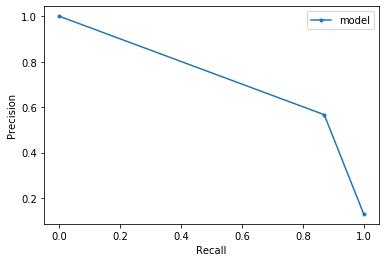

(242, 1674, 36, 185)

In [220]:
evaluate(y_pred_class, y_test, y_probs)

In [226]:
final_model = CatBoostClassifier(random_seed = 42) 

In [227]:
cb_space = {
    'iterations' : np.arange(10, 2000, 20), 
    'learning_rate' : np.linspace(0.000001, 0.1),
    'max_depth' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
    'l2_leaf_reg': np.arange(2, 30), 
    'border_count' : np.arange(1, 255), 
    'bagging_temperature': np.linspace(0.0,1.0), 
    'random_strength': np.linspace(0.000000001, 1.0), 
    'one_hot_max_size': [1, 2, 3, 4, 5]}

In [228]:
randomized_search_result = final_model.randomized_search(cb_space,
                                                   X=X_train,
                                                   y=y_train,
                                                   plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.1751926	best: 0.1751926 (0)	total: 7.44s	remaining: 1m 6s
1:	loss: 0.1426684	best: 0.1426684 (1)	total: 12.4s	remaining: 49.6s
2:	loss: 0.1452626	best: 0.1426684 (1)	total: 21.6s	remaining: 50.3s
3:	loss: 0.1456994	best: 0.1426684 (1)	total: 35.2s	remaining: 52.7s
4:	loss: 0.1436703	best: 0.1426684 (1)	total: 43.9s	remaining: 43.9s
5:	loss: 0.1508663	best: 0.1426684 (1)	total: 46.7s	remaining: 31.1s
6:	loss: 0.1440739	best: 0.1426684 (1)	total: 49.2s	remaining: 21.1s
7:	loss: 0.1459109	best: 0.1426684 (1)	total: 1m 3s	remaining: 16s
8:	loss: 0.1488307	best: 0.1426684 (1)	total: 1m 7s	remaining: 7.52s
9:	loss: 0.1444910	best: 0.1426684 (1)	total: 1m 11s	remaining: 0us
Estimating final quality...


In [229]:
#predict
y_preds =  cross_val_predict(final_model, X_val, y_val, cv=5)
y_probs = cross_val_predict(final_model, X_val, y_val, cv=5, method='predict_proba')[:, 1]

0:	learn: 0.6290788	total: 5.75ms	remaining: 4.42s
1:	learn: 0.5630627	total: 10.5ms	remaining: 4.01s
2:	learn: 0.5108351	total: 16.1ms	remaining: 4.11s
3:	learn: 0.4704083	total: 20.8ms	remaining: 3.99s
4:	learn: 0.4289791	total: 25.2ms	remaining: 3.86s
5:	learn: 0.3951814	total: 28.9ms	remaining: 3.68s
6:	learn: 0.3676409	total: 33.7ms	remaining: 3.68s
7:	learn: 0.3402812	total: 38.1ms	remaining: 3.62s
8:	learn: 0.3196889	total: 42ms	remaining: 3.55s
9:	learn: 0.2991012	total: 46.1ms	remaining: 3.51s
10:	learn: 0.2864308	total: 50.9ms	remaining: 3.51s
11:	learn: 0.2736658	total: 54.5ms	remaining: 3.44s
12:	learn: 0.2601846	total: 58.5ms	remaining: 3.41s
13:	learn: 0.2499240	total: 62.5ms	remaining: 3.37s
14:	learn: 0.2400337	total: 66.2ms	remaining: 3.33s
15:	learn: 0.2300315	total: 70.4ms	remaining: 3.32s
16:	learn: 0.2231958	total: 73.9ms	remaining: 3.27s
17:	learn: 0.2171309	total: 77.3ms	remaining: 3.23s
18:	learn: 0.2124594	total: 83.9ms	remaining: 3.32s
19:	learn: 0.2087923	tot

161:	learn: 0.0994606	total: 384ms	remaining: 1.44s
162:	learn: 0.0992085	total: 388ms	remaining: 1.44s
163:	learn: 0.0988491	total: 392ms	remaining: 1.45s
164:	learn: 0.0983790	total: 396ms	remaining: 1.45s
165:	learn: 0.0978396	total: 400ms	remaining: 1.46s
166:	learn: 0.0975356	total: 404ms	remaining: 1.46s
167:	learn: 0.0971876	total: 408ms	remaining: 1.46s
168:	learn: 0.0969194	total: 412ms	remaining: 1.46s
169:	learn: 0.0966941	total: 416ms	remaining: 1.47s
170:	learn: 0.0964197	total: 419ms	remaining: 1.47s
171:	learn: 0.0961219	total: 423ms	remaining: 1.47s
172:	learn: 0.0958097	total: 429ms	remaining: 1.48s
173:	learn: 0.0955635	total: 435ms	remaining: 1.49s
174:	learn: 0.0953195	total: 440ms	remaining: 1.5s
175:	learn: 0.0949361	total: 445ms	remaining: 1.5s
176:	learn: 0.0946773	total: 449ms	remaining: 1.5s
177:	learn: 0.0944254	total: 453ms	remaining: 1.51s
178:	learn: 0.0942041	total: 459ms	remaining: 1.52s
179:	learn: 0.0938991	total: 462ms	remaining: 1.51s
180:	learn: 0.0

332:	learn: 0.0637661	total: 766ms	remaining: 1s
333:	learn: 0.0635332	total: 767ms	remaining: 1s
334:	learn: 0.0633486	total: 770ms	remaining: 999ms
335:	learn: 0.0632256	total: 773ms	remaining: 999ms
336:	learn: 0.0630477	total: 777ms	remaining: 999ms
337:	learn: 0.0629074	total: 782ms	remaining: 999ms
338:	learn: 0.0627361	total: 786ms	remaining: 999ms
339:	learn: 0.0624588	total: 789ms	remaining: 997ms
340:	learn: 0.0622503	total: 793ms	remaining: 997ms
341:	learn: 0.0621509	total: 794ms	remaining: 994ms
342:	learn: 0.0619973	total: 796ms	remaining: 990ms
343:	learn: 0.0618873	total: 797ms	remaining: 987ms
344:	learn: 0.0617656	total: 798ms	remaining: 984ms
345:	learn: 0.0616567	total: 800ms	remaining: 980ms
346:	learn: 0.0614729	total: 804ms	remaining: 980ms
347:	learn: 0.0612908	total: 807ms	remaining: 979ms
348:	learn: 0.0611651	total: 809ms	remaining: 976ms
349:	learn: 0.0610436	total: 811ms	remaining: 973ms
350:	learn: 0.0609366	total: 812ms	remaining: 969ms
351:	learn: 0.0608

522:	learn: 0.0438140	total: 1.14s	remaining: 540ms
523:	learn: 0.0437529	total: 1.15s	remaining: 539ms
524:	learn: 0.0436574	total: 1.15s	remaining: 537ms
525:	learn: 0.0435968	total: 1.16s	remaining: 536ms
526:	learn: 0.0435157	total: 1.16s	remaining: 535ms
527:	learn: 0.0434089	total: 1.16s	remaining: 534ms
528:	learn: 0.0433401	total: 1.17s	remaining: 532ms
529:	learn: 0.0432555	total: 1.17s	remaining: 530ms
530:	learn: 0.0431472	total: 1.17s	remaining: 528ms
531:	learn: 0.0430737	total: 1.17s	remaining: 525ms
532:	learn: 0.0429474	total: 1.18s	remaining: 524ms
533:	learn: 0.0428702	total: 1.18s	remaining: 521ms
534:	learn: 0.0428460	total: 1.18s	remaining: 518ms
535:	learn: 0.0427580	total: 1.19s	remaining: 517ms
536:	learn: 0.0427349	total: 1.19s	remaining: 516ms
537:	learn: 0.0427200	total: 1.19s	remaining: 514ms
538:	learn: 0.0427054	total: 1.19s	remaining: 511ms
539:	learn: 0.0426314	total: 1.19s	remaining: 509ms
540:	learn: 0.0425113	total: 1.2s	remaining: 506ms
541:	learn: 0

709:	learn: 0.0314265	total: 1.53s	remaining: 129ms
710:	learn: 0.0313667	total: 1.53s	remaining: 127ms
711:	learn: 0.0313384	total: 1.53s	remaining: 125ms
712:	learn: 0.0312317	total: 1.54s	remaining: 123ms
713:	learn: 0.0311925	total: 1.54s	remaining: 121ms
714:	learn: 0.0311385	total: 1.55s	remaining: 119ms
715:	learn: 0.0310888	total: 1.55s	remaining: 117ms
716:	learn: 0.0310633	total: 1.55s	remaining: 115ms
717:	learn: 0.0310061	total: 1.56s	remaining: 113ms
718:	learn: 0.0309669	total: 1.56s	remaining: 111ms
719:	learn: 0.0309279	total: 1.56s	remaining: 108ms
720:	learn: 0.0308798	total: 1.56s	remaining: 106ms
721:	learn: 0.0308250	total: 1.56s	remaining: 104ms
722:	learn: 0.0307371	total: 1.56s	remaining: 102ms
723:	learn: 0.0306763	total: 1.57s	remaining: 99.5ms
724:	learn: 0.0306418	total: 1.57s	remaining: 97.3ms
725:	learn: 0.0305590	total: 1.57s	remaining: 95.1ms
726:	learn: 0.0304903	total: 1.57s	remaining: 92.9ms
727:	learn: 0.0304600	total: 1.57s	remaining: 90.7ms
728:	le

107:	learn: 0.1143727	total: 242ms	remaining: 1.49s
108:	learn: 0.1141618	total: 245ms	remaining: 1.48s
109:	learn: 0.1137361	total: 249ms	remaining: 1.49s
110:	learn: 0.1129346	total: 255ms	remaining: 1.51s
111:	learn: 0.1126651	total: 259ms	remaining: 1.52s
112:	learn: 0.1123277	total: 265ms	remaining: 1.54s
113:	learn: 0.1120296	total: 270ms	remaining: 1.55s
114:	learn: 0.1114048	total: 273ms	remaining: 1.55s
115:	learn: 0.1110668	total: 276ms	remaining: 1.55s
116:	learn: 0.1106854	total: 280ms	remaining: 1.56s
117:	learn: 0.1103549	total: 285ms	remaining: 1.57s
118:	learn: 0.1100441	total: 289ms	remaining: 1.58s
119:	learn: 0.1097114	total: 293ms	remaining: 1.59s
120:	learn: 0.1094951	total: 298ms	remaining: 1.6s
121:	learn: 0.1090280	total: 301ms	remaining: 1.6s
122:	learn: 0.1086169	total: 303ms	remaining: 1.59s
123:	learn: 0.1082786	total: 304ms	remaining: 1.58s
124:	learn: 0.1079182	total: 306ms	remaining: 1.58s
125:	learn: 0.1075322	total: 308ms	remaining: 1.57s
126:	learn: 0.

310:	learn: 0.0666497	total: 622ms	remaining: 918ms
311:	learn: 0.0665622	total: 626ms	remaining: 918ms
312:	learn: 0.0664749	total: 629ms	remaining: 919ms
313:	learn: 0.0663373	total: 634ms	remaining: 920ms
314:	learn: 0.0660686	total: 638ms	remaining: 921ms
315:	learn: 0.0659523	total: 641ms	remaining: 921ms
316:	learn: 0.0658209	total: 645ms	remaining: 921ms
317:	learn: 0.0657200	total: 648ms	remaining: 921ms
318:	learn: 0.0656382	total: 651ms	remaining: 921ms
319:	learn: 0.0655943	total: 653ms	remaining: 918ms
320:	learn: 0.0653379	total: 654ms	remaining: 915ms
321:	learn: 0.0651824	total: 657ms	remaining: 914ms
322:	learn: 0.0649426	total: 659ms	remaining: 912ms
323:	learn: 0.0647637	total: 660ms	remaining: 909ms
324:	learn: 0.0645773	total: 662ms	remaining: 906ms
325:	learn: 0.0643286	total: 663ms	remaining: 903ms
326:	learn: 0.0640884	total: 665ms	remaining: 900ms
327:	learn: 0.0638399	total: 666ms	remaining: 897ms
328:	learn: 0.0635503	total: 667ms	remaining: 895ms
329:	learn: 

473:	learn: 0.0443334	total: 1.01s	remaining: 628ms
474:	learn: 0.0442947	total: 1.01s	remaining: 628ms
475:	learn: 0.0442324	total: 1.01s	remaining: 627ms
476:	learn: 0.0441921	total: 1.02s	remaining: 628ms
477:	learn: 0.0441034	total: 1.03s	remaining: 628ms
478:	learn: 0.0439948	total: 1.03s	remaining: 628ms
479:	learn: 0.0438156	total: 1.04s	remaining: 628ms
480:	learn: 0.0437441	total: 1.04s	remaining: 627ms
481:	learn: 0.0436301	total: 1.05s	remaining: 628ms
482:	learn: 0.0435786	total: 1.06s	remaining: 628ms
483:	learn: 0.0435260	total: 1.06s	remaining: 628ms
484:	learn: 0.0434760	total: 1.07s	remaining: 628ms
485:	learn: 0.0434245	total: 1.07s	remaining: 626ms
486:	learn: 0.0433444	total: 1.07s	remaining: 623ms
487:	learn: 0.0432217	total: 1.07s	remaining: 621ms
488:	learn: 0.0430989	total: 1.08s	remaining: 619ms
489:	learn: 0.0430104	total: 1.08s	remaining: 616ms
490:	learn: 0.0429039	total: 1.08s	remaining: 615ms
491:	learn: 0.0428766	total: 1.08s	remaining: 613ms
492:	learn: 

644:	learn: 0.0318022	total: 1.39s	remaining: 269ms
645:	learn: 0.0317528	total: 1.39s	remaining: 267ms
646:	learn: 0.0316953	total: 1.4s	remaining: 265ms
647:	learn: 0.0316243	total: 1.4s	remaining: 264ms
648:	learn: 0.0316050	total: 1.41s	remaining: 263ms
649:	learn: 0.0315698	total: 1.41s	remaining: 261ms
650:	learn: 0.0315070	total: 1.42s	remaining: 259ms
651:	learn: 0.0314272	total: 1.42s	remaining: 257ms
652:	learn: 0.0313902	total: 1.42s	remaining: 255ms
653:	learn: 0.0313667	total: 1.42s	remaining: 253ms
654:	learn: 0.0312855	total: 1.43s	remaining: 250ms
655:	learn: 0.0311790	total: 1.43s	remaining: 248ms
656:	learn: 0.0311155	total: 1.43s	remaining: 246ms
657:	learn: 0.0310501	total: 1.43s	remaining: 244ms
658:	learn: 0.0309957	total: 1.43s	remaining: 241ms
659:	learn: 0.0309286	total: 1.43s	remaining: 239ms
660:	learn: 0.0308931	total: 1.44s	remaining: 237ms
661:	learn: 0.0308331	total: 1.44s	remaining: 234ms
662:	learn: 0.0307451	total: 1.44s	remaining: 232ms
663:	learn: 0.

71:	learn: 0.1278961	total: 129ms	remaining: 1.25s
72:	learn: 0.1271041	total: 133ms	remaining: 1.27s
73:	learn: 0.1263464	total: 135ms	remaining: 1.27s
74:	learn: 0.1258010	total: 136ms	remaining: 1.26s
75:	learn: 0.1249965	total: 138ms	remaining: 1.26s
76:	learn: 0.1246531	total: 139ms	remaining: 1.25s
77:	learn: 0.1240588	total: 141ms	remaining: 1.25s
78:	learn: 0.1234112	total: 143ms	remaining: 1.25s
79:	learn: 0.1228577	total: 144ms	remaining: 1.24s
80:	learn: 0.1223788	total: 148ms	remaining: 1.26s
81:	learn: 0.1219753	total: 151ms	remaining: 1.27s
82:	learn: 0.1217968	total: 155ms	remaining: 1.28s
83:	learn: 0.1212264	total: 159ms	remaining: 1.3s
84:	learn: 0.1208192	total: 162ms	remaining: 1.3s
85:	learn: 0.1202946	total: 166ms	remaining: 1.32s
86:	learn: 0.1197093	total: 169ms	remaining: 1.33s
87:	learn: 0.1193223	total: 172ms	remaining: 1.33s
88:	learn: 0.1186941	total: 173ms	remaining: 1.33s
89:	learn: 0.1180030	total: 175ms	remaining: 1.32s
90:	learn: 0.1175649	total: 180ms

254:	learn: 0.0687066	total: 506ms	remaining: 1.02s
255:	learn: 0.0683542	total: 510ms	remaining: 1.02s
256:	learn: 0.0680836	total: 513ms	remaining: 1.02s
257:	learn: 0.0678370	total: 515ms	remaining: 1.02s
258:	learn: 0.0676028	total: 516ms	remaining: 1.02s
259:	learn: 0.0674452	total: 518ms	remaining: 1.01s
260:	learn: 0.0673004	total: 521ms	remaining: 1.02s
261:	learn: 0.0671548	total: 525ms	remaining: 1.02s
262:	learn: 0.0669946	total: 529ms	remaining: 1.02s
263:	learn: 0.0668651	total: 533ms	remaining: 1.02s
264:	learn: 0.0665965	total: 535ms	remaining: 1.02s
265:	learn: 0.0663245	total: 538ms	remaining: 1.02s
266:	learn: 0.0659733	total: 541ms	remaining: 1.02s
267:	learn: 0.0658414	total: 543ms	remaining: 1.02s
268:	learn: 0.0655301	total: 544ms	remaining: 1.01s
269:	learn: 0.0653918	total: 546ms	remaining: 1.01s
270:	learn: 0.0653085	total: 547ms	remaining: 1.01s
271:	learn: 0.0651819	total: 549ms	remaining: 1s
272:	learn: 0.0649874	total: 551ms	remaining: 1s
273:	learn: 0.0648

428:	learn: 0.0452859	total: 885ms	remaining: 703ms
429:	learn: 0.0452562	total: 888ms	remaining: 702ms
430:	learn: 0.0451255	total: 890ms	remaining: 700ms
431:	learn: 0.0450058	total: 891ms	remaining: 697ms
432:	learn: 0.0449565	total: 893ms	remaining: 695ms
433:	learn: 0.0448581	total: 895ms	remaining: 693ms
434:	learn: 0.0448184	total: 897ms	remaining: 691ms
435:	learn: 0.0447896	total: 902ms	remaining: 691ms
436:	learn: 0.0447248	total: 905ms	remaining: 690ms
437:	learn: 0.0445791	total: 910ms	remaining: 690ms
438:	learn: 0.0445552	total: 915ms	remaining: 690ms
439:	learn: 0.0445274	total: 919ms	remaining: 689ms
440:	learn: 0.0444556	total: 922ms	remaining: 688ms
441:	learn: 0.0444317	total: 926ms	remaining: 687ms
442:	learn: 0.0444083	total: 927ms	remaining: 684ms
443:	learn: 0.0443917	total: 931ms	remaining: 684ms
444:	learn: 0.0442662	total: 935ms	remaining: 683ms
445:	learn: 0.0442348	total: 939ms	remaining: 682ms
446:	learn: 0.0441709	total: 942ms	remaining: 681ms
447:	learn: 

620:	learn: 0.0332610	total: 1.27s	remaining: 304ms
621:	learn: 0.0331630	total: 1.27s	remaining: 302ms
622:	learn: 0.0331166	total: 1.27s	remaining: 300ms
623:	learn: 0.0330547	total: 1.28s	remaining: 299ms
624:	learn: 0.0330022	total: 1.28s	remaining: 297ms
625:	learn: 0.0329268	total: 1.28s	remaining: 295ms
626:	learn: 0.0328667	total: 1.29s	remaining: 293ms
627:	learn: 0.0328121	total: 1.29s	remaining: 292ms
628:	learn: 0.0327628	total: 1.29s	remaining: 290ms
629:	learn: 0.0327072	total: 1.29s	remaining: 287ms
630:	learn: 0.0326548	total: 1.29s	remaining: 285ms
631:	learn: 0.0325976	total: 1.3s	remaining: 283ms
632:	learn: 0.0325072	total: 1.3s	remaining: 281ms
633:	learn: 0.0324530	total: 1.3s	remaining: 279ms
634:	learn: 0.0324019	total: 1.3s	remaining: 277ms
635:	learn: 0.0323615	total: 1.3s	remaining: 274ms
636:	learn: 0.0322746	total: 1.3s	remaining: 272ms
637:	learn: 0.0322362	total: 1.3s	remaining: 270ms
638:	learn: 0.0321674	total: 1.31s	remaining: 268ms
639:	learn: 0.03215

41:	learn: 0.1556195	total: 83.4ms	remaining: 1.45s
42:	learn: 0.1542233	total: 86.9ms	remaining: 1.47s
43:	learn: 0.1532709	total: 91ms	remaining: 1.5s
44:	learn: 0.1517994	total: 95ms	remaining: 1.53s
45:	learn: 0.1509542	total: 98.6ms	remaining: 1.55s
46:	learn: 0.1505270	total: 102ms	remaining: 1.57s
47:	learn: 0.1493873	total: 106ms	remaining: 1.59s
48:	learn: 0.1483003	total: 109ms	remaining: 1.6s
49:	learn: 0.1474620	total: 112ms	remaining: 1.62s
50:	learn: 0.1467055	total: 114ms	remaining: 1.6s
51:	learn: 0.1455193	total: 115ms	remaining: 1.59s
52:	learn: 0.1446442	total: 117ms	remaining: 1.58s
53:	learn: 0.1441919	total: 121ms	remaining: 1.61s
54:	learn: 0.1432337	total: 124ms	remaining: 1.62s
55:	learn: 0.1420726	total: 126ms	remaining: 1.6s
56:	learn: 0.1415895	total: 127ms	remaining: 1.59s
57:	learn: 0.1406824	total: 129ms	remaining: 1.58s
58:	learn: 0.1402333	total: 130ms	remaining: 1.57s
59:	learn: 0.1393343	total: 132ms	remaining: 1.56s
60:	learn: 0.1386651	total: 133ms	

247:	learn: 0.0762145	total: 463ms	remaining: 975ms
248:	learn: 0.0760971	total: 467ms	remaining: 977ms
249:	learn: 0.0760001	total: 470ms	remaining: 978ms
250:	learn: 0.0759067	total: 474ms	remaining: 979ms
251:	learn: 0.0758179	total: 478ms	remaining: 982ms
252:	learn: 0.0757099	total: 481ms	remaining: 982ms
253:	learn: 0.0754022	total: 484ms	remaining: 983ms
254:	learn: 0.0752632	total: 487ms	remaining: 984ms
255:	learn: 0.0751308	total: 489ms	remaining: 982ms
256:	learn: 0.0750047	total: 491ms	remaining: 979ms
257:	learn: 0.0748863	total: 492ms	remaining: 976ms
258:	learn: 0.0745334	total: 493ms	remaining: 974ms
259:	learn: 0.0742604	total: 495ms	remaining: 971ms
260:	learn: 0.0738852	total: 497ms	remaining: 969ms
261:	learn: 0.0736522	total: 499ms	remaining: 967ms
262:	learn: 0.0735501	total: 500ms	remaining: 964ms
263:	learn: 0.0734601	total: 501ms	remaining: 961ms
264:	learn: 0.0731761	total: 503ms	remaining: 959ms
265:	learn: 0.0731231	total: 504ms	remaining: 956ms
266:	learn: 

476:	learn: 0.0453002	total: 845ms	remaining: 519ms
477:	learn: 0.0452145	total: 849ms	remaining: 519ms
478:	learn: 0.0451425	total: 853ms	remaining: 518ms
479:	learn: 0.0451327	total: 857ms	remaining: 518ms
480:	learn: 0.0450659	total: 860ms	remaining: 517ms
481:	learn: 0.0450074	total: 864ms	remaining: 516ms
482:	learn: 0.0449446	total: 867ms	remaining: 515ms
483:	learn: 0.0448879	total: 871ms	remaining: 514ms
484:	learn: 0.0448323	total: 872ms	remaining: 513ms
485:	learn: 0.0447726	total: 874ms	remaining: 511ms
486:	learn: 0.0446462	total: 875ms	remaining: 509ms
487:	learn: 0.0445166	total: 877ms	remaining: 507ms
488:	learn: 0.0443248	total: 878ms	remaining: 505ms
489:	learn: 0.0442895	total: 879ms	remaining: 503ms
490:	learn: 0.0442320	total: 881ms	remaining: 501ms
491:	learn: 0.0442229	total: 882ms	remaining: 499ms
492:	learn: 0.0440350	total: 884ms	remaining: 497ms
493:	learn: 0.0439039	total: 885ms	remaining: 495ms
494:	learn: 0.0438596	total: 888ms	remaining: 493ms
495:	learn: 

696:	learn: 0.0305650	total: 1.22s	remaining: 128ms
697:	learn: 0.0304929	total: 1.23s	remaining: 127ms
698:	learn: 0.0304639	total: 1.23s	remaining: 125ms
699:	learn: 0.0304206	total: 1.23s	remaining: 123ms
700:	learn: 0.0304152	total: 1.24s	remaining: 122ms
701:	learn: 0.0303663	total: 1.24s	remaining: 120ms
702:	learn: 0.0303121	total: 1.24s	remaining: 119ms
703:	learn: 0.0302634	total: 1.25s	remaining: 117ms
704:	learn: 0.0301831	total: 1.25s	remaining: 115ms
705:	learn: 0.0300970	total: 1.25s	remaining: 114ms
706:	learn: 0.0300471	total: 1.25s	remaining: 112ms
707:	learn: 0.0300425	total: 1.26s	remaining: 110ms
708:	learn: 0.0300371	total: 1.26s	remaining: 108ms
709:	learn: 0.0299701	total: 1.26s	remaining: 106ms
710:	learn: 0.0299239	total: 1.26s	remaining: 105ms
711:	learn: 0.0299195	total: 1.26s	remaining: 103ms
712:	learn: 0.0298720	total: 1.26s	remaining: 101ms
713:	learn: 0.0298391	total: 1.27s	remaining: 99.6ms
714:	learn: 0.0298348	total: 1.27s	remaining: 97.9ms
715:	learn

124:	learn: 0.1067649	total: 207ms	remaining: 1.07s
125:	learn: 0.1064667	total: 211ms	remaining: 1.07s
126:	learn: 0.1060837	total: 214ms	remaining: 1.08s
127:	learn: 0.1055494	total: 218ms	remaining: 1.09s
128:	learn: 0.1053122	total: 222ms	remaining: 1.1s
129:	learn: 0.1050500	total: 225ms	remaining: 1.11s
130:	learn: 0.1047612	total: 229ms	remaining: 1.11s
131:	learn: 0.1042847	total: 231ms	remaining: 1.12s
132:	learn: 0.1039902	total: 233ms	remaining: 1.11s
133:	learn: 0.1036396	total: 234ms	remaining: 1.11s
134:	learn: 0.1033237	total: 236ms	remaining: 1.11s
135:	learn: 0.1028328	total: 237ms	remaining: 1.1s
136:	learn: 0.1025926	total: 238ms	remaining: 1.1s
137:	learn: 0.1023417	total: 240ms	remaining: 1.1s
138:	learn: 0.1019398	total: 241ms	remaining: 1.09s
139:	learn: 0.1016331	total: 243ms	remaining: 1.09s
140:	learn: 0.1013831	total: 245ms	remaining: 1.09s
141:	learn: 0.1009133	total: 247ms	remaining: 1.09s
142:	learn: 0.1003486	total: 248ms	remaining: 1.09s
143:	learn: 0.10

336:	learn: 0.0574940	total: 591ms	remaining: 759ms
337:	learn: 0.0574087	total: 598ms	remaining: 765ms
338:	learn: 0.0572761	total: 605ms	remaining: 769ms
339:	learn: 0.0571227	total: 611ms	remaining: 773ms
340:	learn: 0.0569732	total: 617ms	remaining: 776ms
341:	learn: 0.0567452	total: 623ms	remaining: 780ms
342:	learn: 0.0565817	total: 628ms	remaining: 782ms
343:	learn: 0.0563336	total: 630ms	remaining: 780ms
344:	learn: 0.0562258	total: 632ms	remaining: 778ms
345:	learn: 0.0561226	total: 633ms	remaining: 776ms
346:	learn: 0.0559092	total: 636ms	remaining: 775ms
347:	learn: 0.0557365	total: 638ms	remaining: 774ms
348:	learn: 0.0556404	total: 640ms	remaining: 772ms
349:	learn: 0.0555623	total: 641ms	remaining: 769ms
350:	learn: 0.0553464	total: 642ms	remaining: 767ms
351:	learn: 0.0552231	total: 644ms	remaining: 765ms
352:	learn: 0.0550810	total: 645ms	remaining: 762ms
353:	learn: 0.0548868	total: 647ms	remaining: 760ms
354:	learn: 0.0546960	total: 648ms	remaining: 758ms
355:	learn: 

544:	learn: 0.0387222	total: 969ms	remaining: 400ms
545:	learn: 0.0386732	total: 973ms	remaining: 399ms
546:	learn: 0.0386721	total: 976ms	remaining: 398ms
547:	learn: 0.0385969	total: 980ms	remaining: 397ms
548:	learn: 0.0385406	total: 984ms	remaining: 396ms
549:	learn: 0.0385225	total: 988ms	remaining: 395ms
550:	learn: 0.0384746	total: 991ms	remaining: 394ms
551:	learn: 0.0384263	total: 994ms	remaining: 393ms
552:	learn: 0.0383420	total: 997ms	remaining: 391ms
553:	learn: 0.0382823	total: 998ms	remaining: 389ms
554:	learn: 0.0382646	total: 1000ms	remaining: 387ms
555:	learn: 0.0382486	total: 1s	remaining: 385ms
556:	learn: 0.0382294	total: 1s	remaining: 383ms
557:	learn: 0.0382009	total: 1s	remaining: 382ms
558:	learn: 0.0381433	total: 1s	remaining: 380ms
559:	learn: 0.0381259	total: 1.01s	remaining: 378ms
560:	learn: 0.0380734	total: 1.01s	remaining: 376ms
561:	learn: 0.0380585	total: 1.01s	remaining: 374ms
562:	learn: 0.0380390	total: 1.01s	remaining: 373ms
563:	learn: 0.0379996	t

768:	learn: 0.0276186	total: 1.35s	remaining: 1.76ms
769:	learn: 0.0275708	total: 1.35s	remaining: 0us
0:	learn: 0.6290788	total: 3.34ms	remaining: 2.56s
1:	learn: 0.5630627	total: 4.98ms	remaining: 1.91s
2:	learn: 0.5108351	total: 6.41ms	remaining: 1.64s
3:	learn: 0.4704083	total: 8.41ms	remaining: 1.61s
4:	learn: 0.4289791	total: 10ms	remaining: 1.53s
5:	learn: 0.3951814	total: 11.3ms	remaining: 1.44s
6:	learn: 0.3676409	total: 13.5ms	remaining: 1.47s
7:	learn: 0.3402812	total: 15.1ms	remaining: 1.44s
8:	learn: 0.3196889	total: 17.3ms	remaining: 1.46s
9:	learn: 0.2991012	total: 18.7ms	remaining: 1.42s
10:	learn: 0.2864308	total: 20.5ms	remaining: 1.41s
11:	learn: 0.2736658	total: 21.9ms	remaining: 1.38s
12:	learn: 0.2601846	total: 23.3ms	remaining: 1.36s
13:	learn: 0.2499240	total: 24.8ms	remaining: 1.34s
14:	learn: 0.2400337	total: 26.2ms	remaining: 1.32s
15:	learn: 0.2300315	total: 28.5ms	remaining: 1.34s
16:	learn: 0.2231958	total: 29.9ms	remaining: 1.32s
17:	learn: 0.2171309	tota

202:	learn: 0.0888598	total: 344ms	remaining: 961ms
203:	learn: 0.0886565	total: 349ms	remaining: 968ms
204:	learn: 0.0884268	total: 353ms	remaining: 973ms
205:	learn: 0.0881970	total: 357ms	remaining: 977ms
206:	learn: 0.0880045	total: 361ms	remaining: 981ms
207:	learn: 0.0878087	total: 365ms	remaining: 986ms
208:	learn: 0.0874831	total: 368ms	remaining: 987ms
209:	learn: 0.0873164	total: 374ms	remaining: 997ms
210:	learn: 0.0870540	total: 379ms	remaining: 1s
211:	learn: 0.0867748	total: 383ms	remaining: 1.01s
212:	learn: 0.0866229	total: 386ms	remaining: 1.01s
213:	learn: 0.0861608	total: 389ms	remaining: 1.01s
214:	learn: 0.0860056	total: 393ms	remaining: 1.01s
215:	learn: 0.0857580	total: 396ms	remaining: 1.02s
216:	learn: 0.0854661	total: 399ms	remaining: 1.02s
217:	learn: 0.0852396	total: 400ms	remaining: 1.01s
218:	learn: 0.0850860	total: 402ms	remaining: 1.01s
219:	learn: 0.0849938	total: 403ms	remaining: 1.01s
220:	learn: 0.0848131	total: 405ms	remaining: 1s
221:	learn: 0.0845

376:	learn: 0.0576808	total: 730ms	remaining: 761ms
377:	learn: 0.0575387	total: 731ms	remaining: 758ms
378:	learn: 0.0572777	total: 733ms	remaining: 756ms
379:	learn: 0.0570668	total: 735ms	remaining: 754ms
380:	learn: 0.0569532	total: 739ms	remaining: 755ms
381:	learn: 0.0568243	total: 744ms	remaining: 755ms
382:	learn: 0.0566927	total: 748ms	remaining: 756ms
383:	learn: 0.0566466	total: 752ms	remaining: 755ms
384:	learn: 0.0565345	total: 754ms	remaining: 754ms
385:	learn: 0.0564104	total: 758ms	remaining: 754ms
386:	learn: 0.0562570	total: 760ms	remaining: 752ms
387:	learn: 0.0561352	total: 761ms	remaining: 749ms
388:	learn: 0.0559904	total: 763ms	remaining: 747ms
389:	learn: 0.0559128	total: 764ms	remaining: 745ms
390:	learn: 0.0558686	total: 766ms	remaining: 743ms
391:	learn: 0.0557418	total: 768ms	remaining: 740ms
392:	learn: 0.0556210	total: 770ms	remaining: 739ms
393:	learn: 0.0555663	total: 773ms	remaining: 737ms
394:	learn: 0.0555360	total: 774ms	remaining: 735ms
395:	learn: 

558:	learn: 0.0410433	total: 1.11s	remaining: 420ms
559:	learn: 0.0409980	total: 1.12s	remaining: 419ms
560:	learn: 0.0409253	total: 1.12s	remaining: 418ms
561:	learn: 0.0408691	total: 1.13s	remaining: 417ms
562:	learn: 0.0407920	total: 1.13s	remaining: 416ms
563:	learn: 0.0407349	total: 1.14s	remaining: 415ms
564:	learn: 0.0406310	total: 1.14s	remaining: 414ms
565:	learn: 0.0405615	total: 1.14s	remaining: 412ms
566:	learn: 0.0405001	total: 1.15s	remaining: 410ms
567:	learn: 0.0403847	total: 1.15s	remaining: 409ms
568:	learn: 0.0403081	total: 1.15s	remaining: 408ms
569:	learn: 0.0402761	total: 1.16s	remaining: 405ms
570:	learn: 0.0401771	total: 1.16s	remaining: 403ms
571:	learn: 0.0401188	total: 1.16s	remaining: 401ms
572:	learn: 0.0400819	total: 1.16s	remaining: 399ms
573:	learn: 0.0399365	total: 1.16s	remaining: 397ms
574:	learn: 0.0398937	total: 1.17s	remaining: 396ms
575:	learn: 0.0397863	total: 1.17s	remaining: 394ms
576:	learn: 0.0397189	total: 1.17s	remaining: 392ms
577:	learn: 

741:	learn: 0.0297868	total: 1.5s	remaining: 56.5ms
742:	learn: 0.0297411	total: 1.5s	remaining: 54.5ms
743:	learn: 0.0296820	total: 1.5s	remaining: 52.6ms
744:	learn: 0.0296617	total: 1.51s	remaining: 50.7ms
745:	learn: 0.0296075	total: 1.51s	remaining: 48.7ms
746:	learn: 0.0295779	total: 1.51s	remaining: 46.7ms
747:	learn: 0.0295114	total: 1.52s	remaining: 44.7ms
748:	learn: 0.0294724	total: 1.52s	remaining: 42.6ms
749:	learn: 0.0294560	total: 1.52s	remaining: 40.6ms
750:	learn: 0.0294434	total: 1.52s	remaining: 38.6ms
751:	learn: 0.0293843	total: 1.52s	remaining: 36.5ms
752:	learn: 0.0293455	total: 1.53s	remaining: 34.5ms
753:	learn: 0.0292817	total: 1.53s	remaining: 32.4ms
754:	learn: 0.0292744	total: 1.53s	remaining: 30.4ms
755:	learn: 0.0292403	total: 1.53s	remaining: 28.4ms
756:	learn: 0.0291999	total: 1.53s	remaining: 26.3ms
757:	learn: 0.0291304	total: 1.53s	remaining: 24.3ms
758:	learn: 0.0290672	total: 1.54s	remaining: 22.3ms
759:	learn: 0.0290471	total: 1.54s	remaining: 20.

166:	learn: 0.0946974	total: 293ms	remaining: 1.06s
167:	learn: 0.0943189	total: 297ms	remaining: 1.06s
168:	learn: 0.0940562	total: 300ms	remaining: 1.07s
169:	learn: 0.0938242	total: 304ms	remaining: 1.07s
170:	learn: 0.0934710	total: 308ms	remaining: 1.08s
171:	learn: 0.0933214	total: 313ms	remaining: 1.09s
172:	learn: 0.0929631	total: 317ms	remaining: 1.09s
173:	learn: 0.0926045	total: 322ms	remaining: 1.1s
174:	learn: 0.0922744	total: 326ms	remaining: 1.11s
175:	learn: 0.0920751	total: 329ms	remaining: 1.11s
176:	learn: 0.0916595	total: 332ms	remaining: 1.11s
177:	learn: 0.0913395	total: 333ms	remaining: 1.11s
178:	learn: 0.0910679	total: 335ms	remaining: 1.1s
179:	learn: 0.0908381	total: 337ms	remaining: 1.1s
180:	learn: 0.0905542	total: 339ms	remaining: 1.1s
181:	learn: 0.0903556	total: 342ms	remaining: 1.1s
182:	learn: 0.0900041	total: 346ms	remaining: 1.11s
183:	learn: 0.0897438	total: 350ms	remaining: 1.11s
184:	learn: 0.0894093	total: 353ms	remaining: 1.12s
185:	learn: 0.089

345:	learn: 0.0604650	total: 674ms	remaining: 826ms
346:	learn: 0.0602978	total: 678ms	remaining: 827ms
347:	learn: 0.0601692	total: 683ms	remaining: 828ms
348:	learn: 0.0599555	total: 687ms	remaining: 828ms
349:	learn: 0.0598368	total: 691ms	remaining: 829ms
350:	learn: 0.0597140	total: 694ms	remaining: 828ms
351:	learn: 0.0596262	total: 697ms	remaining: 828ms
352:	learn: 0.0593728	total: 701ms	remaining: 828ms
353:	learn: 0.0591806	total: 702ms	remaining: 825ms
354:	learn: 0.0590455	total: 704ms	remaining: 822ms
355:	learn: 0.0589279	total: 705ms	remaining: 820ms
356:	learn: 0.0587413	total: 706ms	remaining: 817ms
357:	learn: 0.0585047	total: 708ms	remaining: 815ms
358:	learn: 0.0582837	total: 709ms	remaining: 812ms
359:	learn: 0.0581590	total: 711ms	remaining: 810ms
360:	learn: 0.0580507	total: 713ms	remaining: 807ms
361:	learn: 0.0579586	total: 715ms	remaining: 806ms
362:	learn: 0.0578462	total: 716ms	remaining: 803ms
363:	learn: 0.0577320	total: 718ms	remaining: 800ms
364:	learn: 

555:	learn: 0.0375840	total: 1.05s	remaining: 405ms
556:	learn: 0.0374646	total: 1.06s	remaining: 404ms
557:	learn: 0.0373781	total: 1.06s	remaining: 403ms
558:	learn: 0.0372427	total: 1.06s	remaining: 402ms
559:	learn: 0.0371647	total: 1.07s	remaining: 401ms
560:	learn: 0.0370745	total: 1.07s	remaining: 400ms
561:	learn: 0.0369677	total: 1.07s	remaining: 398ms
562:	learn: 0.0368404	total: 1.08s	remaining: 397ms
563:	learn: 0.0368006	total: 1.08s	remaining: 395ms
564:	learn: 0.0367464	total: 1.08s	remaining: 393ms
565:	learn: 0.0366611	total: 1.08s	remaining: 391ms
566:	learn: 0.0365691	total: 1.08s	remaining: 389ms
567:	learn: 0.0365021	total: 1.09s	remaining: 387ms
568:	learn: 0.0363994	total: 1.09s	remaining: 384ms
569:	learn: 0.0363104	total: 1.09s	remaining: 383ms
570:	learn: 0.0362164	total: 1.09s	remaining: 381ms
571:	learn: 0.0361584	total: 1.09s	remaining: 379ms
572:	learn: 0.0360185	total: 1.1s	remaining: 377ms
573:	learn: 0.0359201	total: 1.1s	remaining: 375ms
574:	learn: 0.

744:	learn: 0.0267533	total: 1.42s	remaining: 47.7ms
745:	learn: 0.0267151	total: 1.43s	remaining: 45.9ms
746:	learn: 0.0266960	total: 1.43s	remaining: 44ms
747:	learn: 0.0266249	total: 1.43s	remaining: 42.2ms
748:	learn: 0.0266026	total: 1.44s	remaining: 40.3ms
749:	learn: 0.0265568	total: 1.44s	remaining: 38.4ms
750:	learn: 0.0264882	total: 1.44s	remaining: 36.5ms
751:	learn: 0.0264663	total: 1.45s	remaining: 34.6ms
752:	learn: 0.0263703	total: 1.45s	remaining: 32.7ms
753:	learn: 0.0263282	total: 1.45s	remaining: 30.9ms
754:	learn: 0.0262608	total: 1.46s	remaining: 29ms
755:	learn: 0.0262152	total: 1.46s	remaining: 27.1ms
756:	learn: 0.0261462	total: 1.47s	remaining: 25.2ms
757:	learn: 0.0260845	total: 1.47s	remaining: 23.3ms
758:	learn: 0.0260278	total: 1.47s	remaining: 21.4ms
759:	learn: 0.0260108	total: 1.48s	remaining: 19.4ms
760:	learn: 0.0259794	total: 1.48s	remaining: 17.5ms
761:	learn: 0.0259616	total: 1.48s	remaining: 15.6ms
762:	learn: 0.0259185	total: 1.48s	remaining: 13.6

156:	learn: 0.0915395	total: 280ms	remaining: 1.09s
157:	learn: 0.0913141	total: 284ms	remaining: 1.1s
158:	learn: 0.0909613	total: 287ms	remaining: 1.1s
159:	learn: 0.0906948	total: 291ms	remaining: 1.11s
160:	learn: 0.0905085	total: 294ms	remaining: 1.11s
161:	learn: 0.0900235	total: 297ms	remaining: 1.11s
162:	learn: 0.0896196	total: 301ms	remaining: 1.12s
163:	learn: 0.0893354	total: 304ms	remaining: 1.12s
164:	learn: 0.0892873	total: 306ms	remaining: 1.12s
165:	learn: 0.0890385	total: 307ms	remaining: 1.12s
166:	learn: 0.0887816	total: 308ms	remaining: 1.11s
167:	learn: 0.0885290	total: 310ms	remaining: 1.11s
168:	learn: 0.0883239	total: 311ms	remaining: 1.11s
169:	learn: 0.0881839	total: 313ms	remaining: 1.1s
170:	learn: 0.0878513	total: 314ms	remaining: 1.1s
171:	learn: 0.0876453	total: 317ms	remaining: 1.1s
172:	learn: 0.0872309	total: 318ms	remaining: 1.1s
173:	learn: 0.0870523	total: 320ms	remaining: 1.1s
174:	learn: 0.0870131	total: 322ms	remaining: 1.09s
175:	learn: 0.08676

384:	learn: 0.0493272	total: 662ms	remaining: 662ms
385:	learn: 0.0492582	total: 666ms	remaining: 662ms
386:	learn: 0.0490534	total: 670ms	remaining: 663ms
387:	learn: 0.0489567	total: 674ms	remaining: 664ms
388:	learn: 0.0488222	total: 679ms	remaining: 665ms
389:	learn: 0.0487542	total: 682ms	remaining: 665ms
390:	learn: 0.0486188	total: 685ms	remaining: 664ms
391:	learn: 0.0485505	total: 689ms	remaining: 664ms
392:	learn: 0.0483951	total: 691ms	remaining: 663ms
393:	learn: 0.0483049	total: 693ms	remaining: 661ms
394:	learn: 0.0482118	total: 695ms	remaining: 659ms
395:	learn: 0.0480361	total: 698ms	remaining: 659ms
396:	learn: 0.0479107	total: 701ms	remaining: 658ms
397:	learn: 0.0477469	total: 702ms	remaining: 656ms
398:	learn: 0.0476233	total: 704ms	remaining: 654ms
399:	learn: 0.0475143	total: 705ms	remaining: 652ms
400:	learn: 0.0474382	total: 707ms	remaining: 650ms
401:	learn: 0.0473636	total: 708ms	remaining: 648ms
402:	learn: 0.0472432	total: 709ms	remaining: 646ms
403:	learn: 

571:	learn: 0.0362467	total: 1.02s	remaining: 354ms
572:	learn: 0.0361398	total: 1.03s	remaining: 355ms
573:	learn: 0.0361229	total: 1.04s	remaining: 355ms
574:	learn: 0.0361047	total: 1.04s	remaining: 355ms
575:	learn: 0.0360868	total: 1.05s	remaining: 355ms
576:	learn: 0.0359792	total: 1.06s	remaining: 354ms
577:	learn: 0.0359625	total: 1.06s	remaining: 354ms
578:	learn: 0.0359504	total: 1.07s	remaining: 353ms
579:	learn: 0.0359105	total: 1.07s	remaining: 352ms
580:	learn: 0.0358639	total: 1.08s	remaining: 351ms
581:	learn: 0.0357573	total: 1.08s	remaining: 350ms
582:	learn: 0.0357236	total: 1.09s	remaining: 349ms
583:	learn: 0.0356444	total: 1.09s	remaining: 348ms
584:	learn: 0.0355801	total: 1.1s	remaining: 347ms
585:	learn: 0.0354629	total: 1.1s	remaining: 346ms
586:	learn: 0.0353680	total: 1.1s	remaining: 344ms
587:	learn: 0.0353519	total: 1.11s	remaining: 343ms
588:	learn: 0.0352590	total: 1.11s	remaining: 342ms
589:	learn: 0.0352415	total: 1.12s	remaining: 341ms
590:	learn: 0.0

0:	learn: 0.6289804	total: 4.2ms	remaining: 3.23s
1:	learn: 0.5628828	total: 8.45ms	remaining: 3.24s
2:	learn: 0.5125941	total: 12.1ms	remaining: 3.09s
3:	learn: 0.4712846	total: 16.1ms	remaining: 3.07s
4:	learn: 0.4268438	total: 20.1ms	remaining: 3.08s
5:	learn: 0.3935902	total: 23.2ms	remaining: 2.96s
6:	learn: 0.3650700	total: 27.2ms	remaining: 2.97s
7:	learn: 0.3405014	total: 30.1ms	remaining: 2.87s
8:	learn: 0.3180608	total: 31.6ms	remaining: 2.67s
9:	learn: 0.2971056	total: 36.7ms	remaining: 2.79s
10:	learn: 0.2836823	total: 40.3ms	remaining: 2.78s
11:	learn: 0.2686548	total: 44.6ms	remaining: 2.82s
12:	learn: 0.2589272	total: 47.6ms	remaining: 2.77s
13:	learn: 0.2497454	total: 50.3ms	remaining: 2.72s
14:	learn: 0.2395237	total: 53.6ms	remaining: 2.7s
15:	learn: 0.2289116	total: 55.8ms	remaining: 2.63s
16:	learn: 0.2201603	total: 57.2ms	remaining: 2.54s
17:	learn: 0.2131669	total: 58.7ms	remaining: 2.45s
18:	learn: 0.2069542	total: 60.1ms	remaining: 2.38s
19:	learn: 0.2011045	tot

164:	learn: 0.0935713	total: 387ms	remaining: 1.42s
165:	learn: 0.0934599	total: 391ms	remaining: 1.42s
166:	learn: 0.0931903	total: 394ms	remaining: 1.42s
167:	learn: 0.0928207	total: 398ms	remaining: 1.43s
168:	learn: 0.0924635	total: 402ms	remaining: 1.43s
169:	learn: 0.0922375	total: 405ms	remaining: 1.43s
170:	learn: 0.0919876	total: 408ms	remaining: 1.43s
171:	learn: 0.0918274	total: 412ms	remaining: 1.43s
172:	learn: 0.0915654	total: 413ms	remaining: 1.43s
173:	learn: 0.0913465	total: 415ms	remaining: 1.42s
174:	learn: 0.0911087	total: 416ms	remaining: 1.42s
175:	learn: 0.0909446	total: 418ms	remaining: 1.41s
176:	learn: 0.0906011	total: 419ms	remaining: 1.4s
177:	learn: 0.0904442	total: 421ms	remaining: 1.4s
178:	learn: 0.0901624	total: 422ms	remaining: 1.39s
179:	learn: 0.0899084	total: 424ms	remaining: 1.39s
180:	learn: 0.0896456	total: 425ms	remaining: 1.38s
181:	learn: 0.0894328	total: 428ms	remaining: 1.38s
182:	learn: 0.0891528	total: 429ms	remaining: 1.38s
183:	learn: 0.

388:	learn: 0.0560326	total: 767ms	remaining: 751ms
389:	learn: 0.0558629	total: 770ms	remaining: 750ms
390:	learn: 0.0556863	total: 773ms	remaining: 750ms
391:	learn: 0.0554569	total: 777ms	remaining: 749ms
392:	learn: 0.0553019	total: 780ms	remaining: 748ms
393:	learn: 0.0552893	total: 784ms	remaining: 748ms
394:	learn: 0.0551852	total: 787ms	remaining: 747ms
395:	learn: 0.0550170	total: 790ms	remaining: 746ms
396:	learn: 0.0549456	total: 794ms	remaining: 746ms
397:	learn: 0.0546944	total: 795ms	remaining: 743ms
398:	learn: 0.0546251	total: 797ms	remaining: 741ms
399:	learn: 0.0544976	total: 798ms	remaining: 738ms
400:	learn: 0.0543761	total: 800ms	remaining: 736ms
401:	learn: 0.0542206	total: 801ms	remaining: 734ms
402:	learn: 0.0541486	total: 803ms	remaining: 732ms
403:	learn: 0.0540028	total: 805ms	remaining: 729ms
404:	learn: 0.0538937	total: 806ms	remaining: 727ms
405:	learn: 0.0537733	total: 808ms	remaining: 724ms
406:	learn: 0.0536495	total: 809ms	remaining: 722ms
407:	learn: 

596:	learn: 0.0359094	total: 1.15s	remaining: 333ms
597:	learn: 0.0359031	total: 1.15s	remaining: 332ms
598:	learn: 0.0357800	total: 1.16s	remaining: 330ms
599:	learn: 0.0357139	total: 1.16s	remaining: 329ms
600:	learn: 0.0356079	total: 1.17s	remaining: 328ms
601:	learn: 0.0355453	total: 1.17s	remaining: 326ms
602:	learn: 0.0354701	total: 1.17s	remaining: 325ms
603:	learn: 0.0354518	total: 1.18s	remaining: 323ms
604:	learn: 0.0354187	total: 1.18s	remaining: 321ms
605:	learn: 0.0353774	total: 1.18s	remaining: 320ms
606:	learn: 0.0353223	total: 1.18s	remaining: 318ms
607:	learn: 0.0352455	total: 1.19s	remaining: 316ms
608:	learn: 0.0352395	total: 1.19s	remaining: 314ms
609:	learn: 0.0351845	total: 1.19s	remaining: 312ms
610:	learn: 0.0351483	total: 1.19s	remaining: 310ms
611:	learn: 0.0351066	total: 1.19s	remaining: 308ms
612:	learn: 0.0350530	total: 1.19s	remaining: 305ms
613:	learn: 0.0349811	total: 1.19s	remaining: 303ms
614:	learn: 0.0348809	total: 1.2s	remaining: 302ms
615:	learn: 0

20:	learn: 0.1979111	total: 36.6ms	remaining: 1.3s
21:	learn: 0.1935518	total: 40.9ms	remaining: 1.39s
22:	learn: 0.1884058	total: 43.9ms	remaining: 1.42s
23:	learn: 0.1853330	total: 47ms	remaining: 1.46s
24:	learn: 0.1814208	total: 51.5ms	remaining: 1.53s
25:	learn: 0.1779608	total: 55.3ms	remaining: 1.58s
26:	learn: 0.1754442	total: 60ms	remaining: 1.65s
27:	learn: 0.1734078	total: 64.8ms	remaining: 1.72s
28:	learn: 0.1715849	total: 68.6ms	remaining: 1.75s
29:	learn: 0.1702965	total: 72.1ms	remaining: 1.78s
30:	learn: 0.1689132	total: 75.8ms	remaining: 1.81s
31:	learn: 0.1668169	total: 77.4ms	remaining: 1.78s
32:	learn: 0.1645610	total: 80.1ms	remaining: 1.79s
33:	learn: 0.1624892	total: 81.7ms	remaining: 1.77s
34:	learn: 0.1615930	total: 83.2ms	remaining: 1.75s
35:	learn: 0.1600200	total: 84.6ms	remaining: 1.72s
36:	learn: 0.1587156	total: 86.1ms	remaining: 1.71s
37:	learn: 0.1571039	total: 87.6ms	remaining: 1.69s
38:	learn: 0.1554796	total: 89ms	remaining: 1.67s
39:	learn: 0.154871

245:	learn: 0.0744518	total: 415ms	remaining: 885ms
246:	learn: 0.0742079	total: 420ms	remaining: 888ms
247:	learn: 0.0739975	total: 424ms	remaining: 892ms
248:	learn: 0.0737570	total: 428ms	remaining: 896ms
249:	learn: 0.0735256	total: 432ms	remaining: 899ms
250:	learn: 0.0731963	total: 436ms	remaining: 901ms
251:	learn: 0.0730873	total: 439ms	remaining: 902ms
252:	learn: 0.0729150	total: 442ms	remaining: 904ms
253:	learn: 0.0728515	total: 444ms	remaining: 902ms
254:	learn: 0.0725354	total: 445ms	remaining: 900ms
255:	learn: 0.0724740	total: 447ms	remaining: 897ms
256:	learn: 0.0723099	total: 448ms	remaining: 895ms
257:	learn: 0.0720794	total: 450ms	remaining: 893ms
258:	learn: 0.0717406	total: 451ms	remaining: 891ms
259:	learn: 0.0716789	total: 453ms	remaining: 888ms
260:	learn: 0.0714057	total: 454ms	remaining: 886ms
261:	learn: 0.0711941	total: 457ms	remaining: 887ms
262:	learn: 0.0708781	total: 462ms	remaining: 890ms
263:	learn: 0.0705403	total: 466ms	remaining: 892ms
264:	learn: 

463:	learn: 0.0440053	total: 794ms	remaining: 524ms
464:	learn: 0.0439409	total: 797ms	remaining: 523ms
465:	learn: 0.0438973	total: 801ms	remaining: 523ms
466:	learn: 0.0438641	total: 805ms	remaining: 523ms
467:	learn: 0.0438351	total: 810ms	remaining: 522ms
468:	learn: 0.0438029	total: 814ms	remaining: 522ms
469:	learn: 0.0437240	total: 817ms	remaining: 521ms
470:	learn: 0.0436530	total: 820ms	remaining: 521ms
471:	learn: 0.0435146	total: 823ms	remaining: 519ms
472:	learn: 0.0434405	total: 824ms	remaining: 517ms
473:	learn: 0.0433695	total: 826ms	remaining: 516ms
474:	learn: 0.0432703	total: 827ms	remaining: 514ms
475:	learn: 0.0432347	total: 828ms	remaining: 512ms
476:	learn: 0.0431203	total: 830ms	remaining: 510ms
477:	learn: 0.0431190	total: 831ms	remaining: 508ms
478:	learn: 0.0430886	total: 834ms	remaining: 507ms
479:	learn: 0.0429411	total: 835ms	remaining: 505ms
480:	learn: 0.0428676	total: 837ms	remaining: 503ms
481:	learn: 0.0427531	total: 838ms	remaining: 501ms
482:	learn: 

688:	learn: 0.0314280	total: 1.18s	remaining: 138ms
689:	learn: 0.0313618	total: 1.18s	remaining: 137ms
690:	learn: 0.0312572	total: 1.18s	remaining: 135ms
691:	learn: 0.0312217	total: 1.19s	remaining: 134ms
692:	learn: 0.0311641	total: 1.19s	remaining: 132ms
693:	learn: 0.0311001	total: 1.19s	remaining: 131ms
694:	learn: 0.0310385	total: 1.2s	remaining: 129ms
695:	learn: 0.0309949	total: 1.2s	remaining: 128ms
696:	learn: 0.0309225	total: 1.2s	remaining: 126ms
697:	learn: 0.0308134	total: 1.2s	remaining: 124ms
698:	learn: 0.0307524	total: 1.21s	remaining: 122ms
699:	learn: 0.0307361	total: 1.21s	remaining: 121ms
700:	learn: 0.0306996	total: 1.21s	remaining: 119ms
701:	learn: 0.0306533	total: 1.21s	remaining: 117ms
702:	learn: 0.0305943	total: 1.21s	remaining: 115ms
703:	learn: 0.0305611	total: 1.21s	remaining: 114ms
704:	learn: 0.0305211	total: 1.21s	remaining: 112ms
705:	learn: 0.0304816	total: 1.22s	remaining: 110ms
706:	learn: 0.0303788	total: 1.22s	remaining: 109ms
707:	learn: 0.03

In [230]:
final_model

In [231]:
#select threshold based on validate dataset 
threshold_setting(y_probs, y_val)

Best F2 score: 0.7847321005215742 at a threshold of 0.11


(0.11, 0.7847321005215742)

In [232]:
#make prediction from the test set 
y_preds =  cross_val_predict(final_model, X_test, y_test, cv=5)
y_probs = cross_val_predict(final_model, X_test, y_test, cv=5, method='predict_proba')[:, 1]

0:	learn: 0.6385656	total: 3.21ms	remaining: 2.47s
1:	learn: 0.5856896	total: 5.96ms	remaining: 2.29s
2:	learn: 0.5386107	total: 8.69ms	remaining: 2.22s
3:	learn: 0.4894728	total: 11.7ms	remaining: 2.24s
4:	learn: 0.4509546	total: 14.2ms	remaining: 2.18s
5:	learn: 0.4154452	total: 16.5ms	remaining: 2.1s
6:	learn: 0.3846336	total: 19ms	remaining: 2.07s
7:	learn: 0.3585132	total: 21.3ms	remaining: 2.03s
8:	learn: 0.3336349	total: 24ms	remaining: 2.02s
9:	learn: 0.3124309	total: 26.6ms	remaining: 2.02s
10:	learn: 0.2970723	total: 29.2ms	remaining: 2.01s
11:	learn: 0.2839616	total: 31.7ms	remaining: 2s
12:	learn: 0.2723054	total: 34.3ms	remaining: 2s
13:	learn: 0.2620612	total: 36.9ms	remaining: 1.99s
14:	learn: 0.2524873	total: 39.5ms	remaining: 1.99s
15:	learn: 0.2445040	total: 42ms	remaining: 1.98s
16:	learn: 0.2355224	total: 44.7ms	remaining: 1.98s
17:	learn: 0.2285450	total: 46.9ms	remaining: 1.96s
18:	learn: 0.2199439	total: 49.6ms	remaining: 1.96s
19:	learn: 0.2148453	total: 52.2ms	

232:	learn: 0.0844104	total: 379ms	remaining: 874ms
233:	learn: 0.0840383	total: 382ms	remaining: 874ms
234:	learn: 0.0837395	total: 384ms	remaining: 875ms
235:	learn: 0.0834368	total: 387ms	remaining: 875ms
236:	learn: 0.0833914	total: 389ms	remaining: 876ms
237:	learn: 0.0832408	total: 392ms	remaining: 876ms
238:	learn: 0.0831641	total: 394ms	remaining: 876ms
239:	learn: 0.0830445	total: 397ms	remaining: 876ms
240:	learn: 0.0829005	total: 399ms	remaining: 876ms
241:	learn: 0.0827831	total: 402ms	remaining: 876ms
242:	learn: 0.0826574	total: 404ms	remaining: 877ms
243:	learn: 0.0825084	total: 407ms	remaining: 877ms
244:	learn: 0.0824699	total: 409ms	remaining: 877ms
245:	learn: 0.0823510	total: 412ms	remaining: 877ms
246:	learn: 0.0822781	total: 415ms	remaining: 878ms
247:	learn: 0.0820527	total: 416ms	remaining: 876ms
248:	learn: 0.0819409	total: 418ms	remaining: 875ms
249:	learn: 0.0818040	total: 421ms	remaining: 876ms
250:	learn: 0.0816179	total: 424ms	remaining: 877ms
251:	learn: 

449:	learn: 0.0522126	total: 753ms	remaining: 536ms
450:	learn: 0.0521823	total: 756ms	remaining: 535ms
451:	learn: 0.0521526	total: 758ms	remaining: 533ms
452:	learn: 0.0521143	total: 760ms	remaining: 532ms
453:	learn: 0.0519891	total: 761ms	remaining: 530ms
454:	learn: 0.0519011	total: 762ms	remaining: 528ms
455:	learn: 0.0518069	total: 764ms	remaining: 526ms
456:	learn: 0.0517330	total: 765ms	remaining: 524ms
457:	learn: 0.0515160	total: 767ms	remaining: 522ms
458:	learn: 0.0514826	total: 768ms	remaining: 520ms
459:	learn: 0.0513552	total: 770ms	remaining: 519ms
460:	learn: 0.0512256	total: 773ms	remaining: 518ms
461:	learn: 0.0511513	total: 775ms	remaining: 517ms
462:	learn: 0.0510122	total: 778ms	remaining: 516ms
463:	learn: 0.0509878	total: 781ms	remaining: 515ms
464:	learn: 0.0508412	total: 783ms	remaining: 514ms
465:	learn: 0.0507102	total: 785ms	remaining: 512ms
466:	learn: 0.0506026	total: 788ms	remaining: 512ms
467:	learn: 0.0504729	total: 790ms	remaining: 510ms
468:	learn: 

702:	learn: 0.0342178	total: 1.13s	remaining: 108ms
703:	learn: 0.0340995	total: 1.13s	remaining: 106ms
704:	learn: 0.0340117	total: 1.13s	remaining: 104ms
705:	learn: 0.0340013	total: 1.14s	remaining: 103ms
706:	learn: 0.0339700	total: 1.14s	remaining: 101ms
707:	learn: 0.0339586	total: 1.14s	remaining: 99.9ms
708:	learn: 0.0339484	total: 1.14s	remaining: 98.4ms
709:	learn: 0.0339280	total: 1.15s	remaining: 96.8ms
710:	learn: 0.0338837	total: 1.15s	remaining: 95.3ms
711:	learn: 0.0337845	total: 1.15s	remaining: 93.7ms
712:	learn: 0.0337407	total: 1.15s	remaining: 92.1ms
713:	learn: 0.0337307	total: 1.15s	remaining: 90.5ms
714:	learn: 0.0337209	total: 1.16s	remaining: 88.9ms
715:	learn: 0.0337111	total: 1.16s	remaining: 87.3ms
716:	learn: 0.0336647	total: 1.16s	remaining: 85.7ms
717:	learn: 0.0336094	total: 1.16s	remaining: 84ms
718:	learn: 0.0335597	total: 1.16s	remaining: 82.4ms
719:	learn: 0.0334643	total: 1.16s	remaining: 80.7ms
720:	learn: 0.0333969	total: 1.16s	remaining: 79.1ms


171:	learn: 0.0903783	total: 256ms	remaining: 891ms
172:	learn: 0.0902321	total: 259ms	remaining: 893ms
173:	learn: 0.0898341	total: 261ms	remaining: 895ms
174:	learn: 0.0895454	total: 263ms	remaining: 896ms
175:	learn: 0.0893883	total: 266ms	remaining: 897ms
176:	learn: 0.0892851	total: 268ms	remaining: 899ms
177:	learn: 0.0889395	total: 270ms	remaining: 899ms
178:	learn: 0.0887390	total: 273ms	remaining: 900ms
179:	learn: 0.0885634	total: 275ms	remaining: 900ms
180:	learn: 0.0883509	total: 277ms	remaining: 900ms
181:	learn: 0.0881839	total: 280ms	remaining: 904ms
182:	learn: 0.0879460	total: 282ms	remaining: 906ms
183:	learn: 0.0877991	total: 285ms	remaining: 909ms
184:	learn: 0.0876423	total: 288ms	remaining: 909ms
185:	learn: 0.0873668	total: 289ms	remaining: 909ms
186:	learn: 0.0871303	total: 291ms	remaining: 909ms
187:	learn: 0.0869847	total: 293ms	remaining: 907ms
188:	learn: 0.0866538	total: 294ms	remaining: 905ms
189:	learn: 0.0865615	total: 296ms	remaining: 903ms
190:	learn: 

453:	learn: 0.0510313	total: 629ms	remaining: 438ms
454:	learn: 0.0509918	total: 631ms	remaining: 437ms
455:	learn: 0.0509460	total: 634ms	remaining: 437ms
456:	learn: 0.0509015	total: 636ms	remaining: 436ms
457:	learn: 0.0508363	total: 639ms	remaining: 435ms
458:	learn: 0.0507929	total: 641ms	remaining: 434ms
459:	learn: 0.0507496	total: 643ms	remaining: 433ms
460:	learn: 0.0506739	total: 645ms	remaining: 432ms
461:	learn: 0.0506266	total: 647ms	remaining: 432ms
462:	learn: 0.0503563	total: 650ms	remaining: 431ms
463:	learn: 0.0503141	total: 652ms	remaining: 430ms
464:	learn: 0.0502388	total: 654ms	remaining: 429ms
465:	learn: 0.0501166	total: 656ms	remaining: 428ms
466:	learn: 0.0500766	total: 658ms	remaining: 427ms
467:	learn: 0.0500144	total: 659ms	remaining: 425ms
468:	learn: 0.0499767	total: 661ms	remaining: 424ms
469:	learn: 0.0499115	total: 662ms	remaining: 422ms
470:	learn: 0.0497688	total: 663ms	remaining: 421ms
471:	learn: 0.0497271	total: 664ms	remaining: 419ms
472:	learn: 

734:	learn: 0.0300370	total: 1s	remaining: 47.8ms
735:	learn: 0.0300131	total: 1.01s	remaining: 46.5ms
736:	learn: 0.0299043	total: 1.01s	remaining: 45.2ms
737:	learn: 0.0298686	total: 1.01s	remaining: 43.9ms
738:	learn: 0.0297990	total: 1.01s	remaining: 42.5ms
739:	learn: 0.0297643	total: 1.01s	remaining: 41.2ms
740:	learn: 0.0297000	total: 1.02s	remaining: 39.8ms
741:	learn: 0.0296898	total: 1.02s	remaining: 38.5ms
742:	learn: 0.0296452	total: 1.02s	remaining: 37.2ms
743:	learn: 0.0296352	total: 1.02s	remaining: 35.8ms
744:	learn: 0.0296062	total: 1.03s	remaining: 34.5ms
745:	learn: 0.0295805	total: 1.03s	remaining: 33.1ms
746:	learn: 0.0295384	total: 1.03s	remaining: 31.7ms
747:	learn: 0.0295285	total: 1.03s	remaining: 30.4ms
748:	learn: 0.0295129	total: 1.03s	remaining: 29ms
749:	learn: 0.0294332	total: 1.03s	remaining: 27.6ms
750:	learn: 0.0293253	total: 1.04s	remaining: 26.2ms
751:	learn: 0.0293157	total: 1.04s	remaining: 24.8ms
752:	learn: 0.0292822	total: 1.04s	remaining: 23.4m

224:	learn: 0.0774424	total: 292ms	remaining: 708ms
225:	learn: 0.0772910	total: 295ms	remaining: 711ms
226:	learn: 0.0771207	total: 298ms	remaining: 712ms
227:	learn: 0.0769118	total: 300ms	remaining: 714ms
228:	learn: 0.0767922	total: 303ms	remaining: 716ms
229:	learn: 0.0767185	total: 306ms	remaining: 718ms
230:	learn: 0.0763631	total: 308ms	remaining: 719ms
231:	learn: 0.0762022	total: 311ms	remaining: 721ms
232:	learn: 0.0761020	total: 312ms	remaining: 720ms
233:	learn: 0.0759006	total: 315ms	remaining: 720ms
234:	learn: 0.0757463	total: 316ms	remaining: 720ms
235:	learn: 0.0753368	total: 319ms	remaining: 721ms
236:	learn: 0.0752131	total: 320ms	remaining: 720ms
237:	learn: 0.0749901	total: 321ms	remaining: 718ms
238:	learn: 0.0748766	total: 322ms	remaining: 716ms
239:	learn: 0.0747819	total: 324ms	remaining: 715ms
240:	learn: 0.0744608	total: 326ms	remaining: 715ms
241:	learn: 0.0741687	total: 327ms	remaining: 713ms
242:	learn: 0.0739933	total: 328ms	remaining: 711ms
243:	learn: 

499:	learn: 0.0404171	total: 667ms	remaining: 360ms
500:	learn: 0.0403874	total: 670ms	remaining: 360ms
501:	learn: 0.0402215	total: 672ms	remaining: 359ms
502:	learn: 0.0401591	total: 675ms	remaining: 358ms
503:	learn: 0.0401092	total: 678ms	remaining: 358ms
504:	learn: 0.0400422	total: 680ms	remaining: 357ms
505:	learn: 0.0399839	total: 683ms	remaining: 356ms
506:	learn: 0.0398013	total: 685ms	remaining: 356ms
507:	learn: 0.0397701	total: 688ms	remaining: 355ms
508:	learn: 0.0396565	total: 691ms	remaining: 354ms
509:	learn: 0.0394786	total: 692ms	remaining: 353ms
510:	learn: 0.0393490	total: 695ms	remaining: 352ms
511:	learn: 0.0392961	total: 696ms	remaining: 351ms
512:	learn: 0.0391647	total: 699ms	remaining: 350ms
513:	learn: 0.0391170	total: 700ms	remaining: 349ms
514:	learn: 0.0390966	total: 702ms	remaining: 347ms
515:	learn: 0.0390485	total: 703ms	remaining: 346ms
516:	learn: 0.0389255	total: 704ms	remaining: 344ms
517:	learn: 0.0388306	total: 705ms	remaining: 343ms
518:	learn: 

0:	learn: 0.6384330	total: 2.71ms	remaining: 2.08s
1:	learn: 0.5846046	total: 4.98ms	remaining: 1.91s
2:	learn: 0.5337331	total: 7.83ms	remaining: 2s
3:	learn: 0.4856918	total: 10.5ms	remaining: 2.01s
4:	learn: 0.4450534	total: 12.8ms	remaining: 1.95s
5:	learn: 0.4093110	total: 15.1ms	remaining: 1.92s
6:	learn: 0.3806397	total: 17.5ms	remaining: 1.91s
7:	learn: 0.3550831	total: 20ms	remaining: 1.9s
8:	learn: 0.3318082	total: 21.6ms	remaining: 1.82s
9:	learn: 0.3093745	total: 24.4ms	remaining: 1.85s
10:	learn: 0.2947603	total: 25.8ms	remaining: 1.78s
11:	learn: 0.2804559	total: 26.9ms	remaining: 1.7s
12:	learn: 0.2683465	total: 28.2ms	remaining: 1.64s
13:	learn: 0.2584116	total: 29.1ms	remaining: 1.57s
14:	learn: 0.2480466	total: 30.4ms	remaining: 1.53s
15:	learn: 0.2364676	total: 31.7ms	remaining: 1.49s
16:	learn: 0.2272613	total: 32.9ms	remaining: 1.46s
17:	learn: 0.2193321	total: 34.1ms	remaining: 1.42s
18:	learn: 0.2126744	total: 35.3ms	remaining: 1.4s
19:	learn: 0.2079977	total: 37

284:	learn: 0.0689919	total: 378ms	remaining: 643ms
285:	learn: 0.0688299	total: 380ms	remaining: 644ms
286:	learn: 0.0686288	total: 382ms	remaining: 643ms
287:	learn: 0.0685498	total: 384ms	remaining: 642ms
288:	learn: 0.0684593	total: 385ms	remaining: 641ms
289:	learn: 0.0681598	total: 387ms	remaining: 640ms
290:	learn: 0.0680686	total: 389ms	remaining: 641ms
291:	learn: 0.0677821	total: 392ms	remaining: 642ms
292:	learn: 0.0677467	total: 394ms	remaining: 642ms
293:	learn: 0.0677303	total: 397ms	remaining: 643ms
294:	learn: 0.0676944	total: 399ms	remaining: 643ms
295:	learn: 0.0676080	total: 402ms	remaining: 644ms
296:	learn: 0.0675065	total: 405ms	remaining: 644ms
297:	learn: 0.0673416	total: 407ms	remaining: 644ms
298:	learn: 0.0670697	total: 409ms	remaining: 645ms
299:	learn: 0.0668096	total: 411ms	remaining: 644ms
300:	learn: 0.0666261	total: 413ms	remaining: 644ms
301:	learn: 0.0662983	total: 415ms	remaining: 643ms
302:	learn: 0.0662248	total: 416ms	remaining: 641ms
303:	learn: 

558:	learn: 0.0359346	total: 751ms	remaining: 283ms
559:	learn: 0.0358498	total: 753ms	remaining: 282ms
560:	learn: 0.0357771	total: 755ms	remaining: 281ms
561:	learn: 0.0356443	total: 758ms	remaining: 280ms
562:	learn: 0.0356132	total: 760ms	remaining: 280ms
563:	learn: 0.0355845	total: 763ms	remaining: 279ms
564:	learn: 0.0355141	total: 766ms	remaining: 278ms
565:	learn: 0.0353506	total: 769ms	remaining: 277ms
566:	learn: 0.0352681	total: 771ms	remaining: 276ms
567:	learn: 0.0351631	total: 773ms	remaining: 275ms
568:	learn: 0.0351205	total: 775ms	remaining: 274ms
569:	learn: 0.0350490	total: 777ms	remaining: 273ms
570:	learn: 0.0350277	total: 780ms	remaining: 272ms
571:	learn: 0.0349313	total: 781ms	remaining: 270ms
572:	learn: 0.0348819	total: 782ms	remaining: 269ms
573:	learn: 0.0348312	total: 783ms	remaining: 267ms
574:	learn: 0.0347716	total: 784ms	remaining: 266ms
575:	learn: 0.0347365	total: 785ms	remaining: 265ms
576:	learn: 0.0346860	total: 787ms	remaining: 263ms
577:	learn: 

45:	learn: 0.1503430	total: 63.3ms	remaining: 996ms
46:	learn: 0.1493235	total: 65.5ms	remaining: 1.01s
47:	learn: 0.1480021	total: 68.2ms	remaining: 1.03s
48:	learn: 0.1475119	total: 70.8ms	remaining: 1.04s
49:	learn: 0.1469140	total: 73.4ms	remaining: 1.06s
50:	learn: 0.1461161	total: 76.3ms	remaining: 1.08s
51:	learn: 0.1449918	total: 79.1ms	remaining: 1.09s
52:	learn: 0.1439029	total: 82.3ms	remaining: 1.11s
53:	learn: 0.1428789	total: 85.4ms	remaining: 1.13s
54:	learn: 0.1420891	total: 87.6ms	remaining: 1.14s
55:	learn: 0.1411671	total: 89.6ms	remaining: 1.14s
56:	learn: 0.1401386	total: 91.7ms	remaining: 1.15s
57:	learn: 0.1394254	total: 92.8ms	remaining: 1.14s
58:	learn: 0.1388975	total: 94ms	remaining: 1.13s
59:	learn: 0.1375372	total: 95.1ms	remaining: 1.13s
60:	learn: 0.1366391	total: 96.3ms	remaining: 1.12s
61:	learn: 0.1358017	total: 97.5ms	remaining: 1.11s
62:	learn: 0.1352263	total: 98.7ms	remaining: 1.11s
63:	learn: 0.1348003	total: 99.8ms	remaining: 1.1s
64:	learn: 0.13

329:	learn: 0.0628608	total: 436ms	remaining: 582ms
330:	learn: 0.0626162	total: 438ms	remaining: 580ms
331:	learn: 0.0625638	total: 440ms	remaining: 581ms
332:	learn: 0.0625196	total: 443ms	remaining: 581ms
333:	learn: 0.0623570	total: 445ms	remaining: 581ms
334:	learn: 0.0620311	total: 448ms	remaining: 582ms
335:	learn: 0.0617383	total: 451ms	remaining: 582ms
336:	learn: 0.0616535	total: 453ms	remaining: 582ms
337:	learn: 0.0615506	total: 456ms	remaining: 583ms
338:	learn: 0.0612740	total: 458ms	remaining: 583ms
339:	learn: 0.0612691	total: 460ms	remaining: 582ms
340:	learn: 0.0612653	total: 462ms	remaining: 581ms
341:	learn: 0.0612615	total: 463ms	remaining: 580ms
342:	learn: 0.0612030	total: 465ms	remaining: 579ms
343:	learn: 0.0610547	total: 467ms	remaining: 578ms
344:	learn: 0.0610509	total: 468ms	remaining: 577ms
345:	learn: 0.0609699	total: 469ms	remaining: 575ms
346:	learn: 0.0608439	total: 470ms	remaining: 573ms
347:	learn: 0.0606280	total: 472ms	remaining: 572ms
348:	learn: 

608:	learn: 0.0329071	total: 810ms	remaining: 214ms
609:	learn: 0.0328634	total: 813ms	remaining: 213ms
610:	learn: 0.0328304	total: 816ms	remaining: 212ms
611:	learn: 0.0328021	total: 818ms	remaining: 211ms
612:	learn: 0.0327954	total: 821ms	remaining: 210ms
613:	learn: 0.0327192	total: 824ms	remaining: 209ms
614:	learn: 0.0325822	total: 827ms	remaining: 208ms
615:	learn: 0.0324979	total: 830ms	remaining: 207ms
616:	learn: 0.0324580	total: 831ms	remaining: 206ms
617:	learn: 0.0324382	total: 833ms	remaining: 205ms
618:	learn: 0.0323829	total: 835ms	remaining: 204ms
619:	learn: 0.0323521	total: 837ms	remaining: 203ms
620:	learn: 0.0323136	total: 839ms	remaining: 201ms
621:	learn: 0.0322874	total: 840ms	remaining: 200ms
622:	learn: 0.0322499	total: 841ms	remaining: 199ms
623:	learn: 0.0322133	total: 843ms	remaining: 197ms
624:	learn: 0.0321722	total: 844ms	remaining: 196ms
625:	learn: 0.0321486	total: 845ms	remaining: 194ms
626:	learn: 0.0321294	total: 847ms	remaining: 193ms
627:	learn: 

96:	learn: 0.1193981	total: 119ms	remaining: 823ms
97:	learn: 0.1186566	total: 121ms	remaining: 833ms
98:	learn: 0.1181173	total: 124ms	remaining: 839ms
99:	learn: 0.1174013	total: 126ms	remaining: 846ms
100:	learn: 0.1172161	total: 129ms	remaining: 855ms
101:	learn: 0.1168199	total: 132ms	remaining: 863ms
102:	learn: 0.1166651	total: 134ms	remaining: 871ms
103:	learn: 0.1163228	total: 138ms	remaining: 882ms
104:	learn: 0.1161487	total: 141ms	remaining: 891ms
105:	learn: 0.1156397	total: 144ms	remaining: 899ms
106:	learn: 0.1149445	total: 146ms	remaining: 906ms
107:	learn: 0.1146115	total: 148ms	remaining: 906ms
108:	learn: 0.1138828	total: 150ms	remaining: 907ms
109:	learn: 0.1133678	total: 151ms	remaining: 908ms
110:	learn: 0.1128548	total: 153ms	remaining: 906ms
111:	learn: 0.1125583	total: 154ms	remaining: 903ms
112:	learn: 0.1122200	total: 155ms	remaining: 901ms
113:	learn: 0.1116777	total: 156ms	remaining: 898ms
114:	learn: 0.1112409	total: 157ms	remaining: 896ms
115:	learn: 0.11

371:	learn: 0.0637604	total: 492ms	remaining: 527ms
372:	learn: 0.0635706	total: 495ms	remaining: 527ms
373:	learn: 0.0632319	total: 498ms	remaining: 527ms
374:	learn: 0.0630020	total: 500ms	remaining: 527ms
375:	learn: 0.0627196	total: 503ms	remaining: 527ms
376:	learn: 0.0624682	total: 506ms	remaining: 527ms
377:	learn: 0.0621738	total: 508ms	remaining: 527ms
378:	learn: 0.0620660	total: 511ms	remaining: 528ms
379:	learn: 0.0619704	total: 513ms	remaining: 527ms
380:	learn: 0.0617810	total: 515ms	remaining: 526ms
381:	learn: 0.0616573	total: 518ms	remaining: 526ms
382:	learn: 0.0615649	total: 520ms	remaining: 526ms
383:	learn: 0.0613872	total: 522ms	remaining: 525ms
384:	learn: 0.0612252	total: 523ms	remaining: 523ms
385:	learn: 0.0611361	total: 524ms	remaining: 522ms
386:	learn: 0.0610350	total: 525ms	remaining: 520ms
387:	learn: 0.0609797	total: 527ms	remaining: 519ms
388:	learn: 0.0608514	total: 528ms	remaining: 517ms
389:	learn: 0.0607371	total: 529ms	remaining: 515ms
390:	learn: 

658:	learn: 0.0361557	total: 866ms	remaining: 146ms
659:	learn: 0.0361436	total: 869ms	remaining: 145ms
660:	learn: 0.0360688	total: 872ms	remaining: 144ms
661:	learn: 0.0359943	total: 875ms	remaining: 143ms
662:	learn: 0.0359060	total: 877ms	remaining: 142ms
663:	learn: 0.0358989	total: 880ms	remaining: 140ms
664:	learn: 0.0358271	total: 883ms	remaining: 139ms
665:	learn: 0.0357968	total: 886ms	remaining: 138ms
666:	learn: 0.0356416	total: 888ms	remaining: 137ms
667:	learn: 0.0356092	total: 890ms	remaining: 136ms
668:	learn: 0.0354923	total: 892ms	remaining: 135ms
669:	learn: 0.0354387	total: 894ms	remaining: 133ms
670:	learn: 0.0353350	total: 896ms	remaining: 132ms
671:	learn: 0.0352519	total: 897ms	remaining: 131ms
672:	learn: 0.0352146	total: 898ms	remaining: 129ms
673:	learn: 0.0351722	total: 899ms	remaining: 128ms
674:	learn: 0.0351373	total: 901ms	remaining: 127ms
675:	learn: 0.0350579	total: 902ms	remaining: 125ms
676:	learn: 0.0350214	total: 903ms	remaining: 124ms
677:	learn: 

139:	learn: 0.1000870	total: 191ms	remaining: 859ms
140:	learn: 0.0995119	total: 193ms	remaining: 862ms
141:	learn: 0.0991855	total: 195ms	remaining: 864ms
142:	learn: 0.0989020	total: 198ms	remaining: 868ms
143:	learn: 0.0985540	total: 200ms	remaining: 871ms
144:	learn: 0.0981822	total: 203ms	remaining: 874ms
145:	learn: 0.0980177	total: 205ms	remaining: 878ms
146:	learn: 0.0977822	total: 208ms	remaining: 880ms
147:	learn: 0.0975954	total: 211ms	remaining: 886ms
148:	learn: 0.0974087	total: 212ms	remaining: 886ms
149:	learn: 0.0968582	total: 215ms	remaining: 888ms
150:	learn: 0.0965439	total: 217ms	remaining: 888ms
151:	learn: 0.0961265	total: 219ms	remaining: 891ms
152:	learn: 0.0957762	total: 220ms	remaining: 889ms
153:	learn: 0.0953648	total: 222ms	remaining: 887ms
154:	learn: 0.0951271	total: 223ms	remaining: 884ms
155:	learn: 0.0945686	total: 224ms	remaining: 882ms
156:	learn: 0.0942911	total: 225ms	remaining: 879ms
157:	learn: 0.0938886	total: 226ms	remaining: 877ms
158:	learn: 

418:	learn: 0.0541000	total: 567ms	remaining: 475ms
419:	learn: 0.0540208	total: 569ms	remaining: 474ms
420:	learn: 0.0539768	total: 571ms	remaining: 474ms
421:	learn: 0.0538993	total: 574ms	remaining: 473ms
422:	learn: 0.0538231	total: 576ms	remaining: 473ms
423:	learn: 0.0537699	total: 579ms	remaining: 473ms
424:	learn: 0.0537123	total: 582ms	remaining: 472ms
425:	learn: 0.0536080	total: 584ms	remaining: 472ms
426:	learn: 0.0533013	total: 587ms	remaining: 471ms
427:	learn: 0.0532200	total: 588ms	remaining: 470ms
428:	learn: 0.0530595	total: 590ms	remaining: 469ms
429:	learn: 0.0530165	total: 592ms	remaining: 468ms
430:	learn: 0.0528894	total: 594ms	remaining: 467ms
431:	learn: 0.0526821	total: 596ms	remaining: 466ms
432:	learn: 0.0526243	total: 597ms	remaining: 465ms
433:	learn: 0.0524363	total: 599ms	remaining: 463ms
434:	learn: 0.0523617	total: 600ms	remaining: 462ms
435:	learn: 0.0522826	total: 602ms	remaining: 461ms
436:	learn: 0.0520778	total: 603ms	remaining: 460ms
437:	learn: 

696:	learn: 0.0320966	total: 943ms	remaining: 98.8ms
697:	learn: 0.0320844	total: 945ms	remaining: 97.5ms
698:	learn: 0.0320725	total: 946ms	remaining: 96.1ms
699:	learn: 0.0320017	total: 947ms	remaining: 94.7ms
700:	learn: 0.0319899	total: 948ms	remaining: 93.4ms
701:	learn: 0.0319165	total: 950ms	remaining: 92ms
702:	learn: 0.0318616	total: 951ms	remaining: 90.6ms
703:	learn: 0.0318200	total: 952ms	remaining: 89.2ms
704:	learn: 0.0317797	total: 953ms	remaining: 87.9ms
705:	learn: 0.0317202	total: 954ms	remaining: 86.5ms
706:	learn: 0.0316700	total: 956ms	remaining: 85.1ms
707:	learn: 0.0316586	total: 958ms	remaining: 83.9ms
708:	learn: 0.0315733	total: 960ms	remaining: 82.6ms
709:	learn: 0.0315620	total: 963ms	remaining: 81.4ms
710:	learn: 0.0315316	total: 966ms	remaining: 80.1ms
711:	learn: 0.0314668	total: 968ms	remaining: 78.9ms
712:	learn: 0.0313669	total: 971ms	remaining: 77.6ms
713:	learn: 0.0313293	total: 973ms	remaining: 76.3ms
714:	learn: 0.0312778	total: 975ms	remaining: 75

191:	learn: 0.0843186	total: 244ms	remaining: 733ms
192:	learn: 0.0840817	total: 245ms	remaining: 734ms
193:	learn: 0.0839130	total: 248ms	remaining: 737ms
194:	learn: 0.0837260	total: 251ms	remaining: 739ms
195:	learn: 0.0834653	total: 253ms	remaining: 741ms
196:	learn: 0.0831817	total: 255ms	remaining: 742ms
197:	learn: 0.0828177	total: 258ms	remaining: 745ms
198:	learn: 0.0826598	total: 260ms	remaining: 747ms
199:	learn: 0.0825668	total: 263ms	remaining: 750ms
200:	learn: 0.0822855	total: 265ms	remaining: 751ms
201:	learn: 0.0821381	total: 268ms	remaining: 752ms
202:	learn: 0.0820249	total: 269ms	remaining: 752ms
203:	learn: 0.0818541	total: 271ms	remaining: 753ms
204:	learn: 0.0816896	total: 273ms	remaining: 752ms
205:	learn: 0.0813206	total: 274ms	remaining: 750ms
206:	learn: 0.0810791	total: 275ms	remaining: 748ms
207:	learn: 0.0809090	total: 276ms	remaining: 747ms
208:	learn: 0.0807218	total: 278ms	remaining: 745ms
209:	learn: 0.0805745	total: 279ms	remaining: 744ms
210:	learn: 

472:	learn: 0.0429344	total: 618ms	remaining: 388ms
473:	learn: 0.0429018	total: 621ms	remaining: 388ms
474:	learn: 0.0427811	total: 625ms	remaining: 388ms
475:	learn: 0.0426895	total: 627ms	remaining: 388ms
476:	learn: 0.0426095	total: 630ms	remaining: 387ms
477:	learn: 0.0424836	total: 633ms	remaining: 387ms
478:	learn: 0.0424171	total: 635ms	remaining: 386ms
479:	learn: 0.0423533	total: 638ms	remaining: 385ms
480:	learn: 0.0422984	total: 640ms	remaining: 384ms
481:	learn: 0.0421978	total: 642ms	remaining: 383ms
482:	learn: 0.0419910	total: 643ms	remaining: 382ms
483:	learn: 0.0419157	total: 647ms	remaining: 382ms
484:	learn: 0.0418584	total: 649ms	remaining: 381ms
485:	learn: 0.0417863	total: 650ms	remaining: 380ms
486:	learn: 0.0417182	total: 651ms	remaining: 378ms
487:	learn: 0.0416173	total: 652ms	remaining: 377ms
488:	learn: 0.0415480	total: 653ms	remaining: 375ms
489:	learn: 0.0414754	total: 654ms	remaining: 374ms
490:	learn: 0.0412952	total: 655ms	remaining: 372ms
491:	learn: 

741:	learn: 0.0249264	total: 987ms	remaining: 37.3ms
742:	learn: 0.0248681	total: 990ms	remaining: 36ms
743:	learn: 0.0248516	total: 993ms	remaining: 34.7ms
744:	learn: 0.0247531	total: 995ms	remaining: 33.4ms
745:	learn: 0.0246615	total: 997ms	remaining: 32.1ms
746:	learn: 0.0246386	total: 1000ms	remaining: 30.8ms
747:	learn: 0.0245815	total: 1s	remaining: 29.5ms
748:	learn: 0.0245644	total: 1s	remaining: 28.2ms
749:	learn: 0.0245558	total: 1.01s	remaining: 26.9ms
750:	learn: 0.0245351	total: 1.01s	remaining: 25.5ms
751:	learn: 0.0244437	total: 1.01s	remaining: 24.2ms
752:	learn: 0.0244204	total: 1.01s	remaining: 22.9ms
753:	learn: 0.0244043	total: 1.01s	remaining: 21.5ms
754:	learn: 0.0243647	total: 1.02s	remaining: 20.2ms
755:	learn: 0.0243387	total: 1.02s	remaining: 18.8ms
756:	learn: 0.0243188	total: 1.02s	remaining: 17.5ms
757:	learn: 0.0242733	total: 1.02s	remaining: 16.1ms
758:	learn: 0.0242351	total: 1.02s	remaining: 14.8ms
759:	learn: 0.0242157	total: 1.02s	remaining: 13.5ms


222:	learn: 0.0789063	total: 288ms	remaining: 707ms
223:	learn: 0.0786337	total: 290ms	remaining: 708ms
224:	learn: 0.0786067	total: 293ms	remaining: 709ms
225:	learn: 0.0784644	total: 295ms	remaining: 710ms
226:	learn: 0.0784286	total: 297ms	remaining: 711ms
227:	learn: 0.0779341	total: 300ms	remaining: 712ms
228:	learn: 0.0777829	total: 302ms	remaining: 714ms
229:	learn: 0.0776638	total: 304ms	remaining: 715ms
230:	learn: 0.0775941	total: 307ms	remaining: 715ms
231:	learn: 0.0773028	total: 308ms	remaining: 715ms
232:	learn: 0.0772816	total: 310ms	remaining: 715ms
233:	learn: 0.0772295	total: 313ms	remaining: 716ms
234:	learn: 0.0769746	total: 315ms	remaining: 717ms
235:	learn: 0.0768139	total: 316ms	remaining: 715ms
236:	learn: 0.0764238	total: 317ms	remaining: 714ms
237:	learn: 0.0762933	total: 319ms	remaining: 712ms
238:	learn: 0.0760589	total: 320ms	remaining: 710ms
239:	learn: 0.0759899	total: 321ms	remaining: 709ms
240:	learn: 0.0759216	total: 322ms	remaining: 707ms
241:	learn: 

505:	learn: 0.0402715	total: 662ms	remaining: 345ms
506:	learn: 0.0402060	total: 664ms	remaining: 344ms
507:	learn: 0.0401195	total: 666ms	remaining: 344ms
508:	learn: 0.0399105	total: 669ms	remaining: 343ms
509:	learn: 0.0398154	total: 671ms	remaining: 342ms
510:	learn: 0.0397753	total: 674ms	remaining: 341ms
511:	learn: 0.0396635	total: 676ms	remaining: 341ms
512:	learn: 0.0395814	total: 678ms	remaining: 340ms
513:	learn: 0.0395436	total: 681ms	remaining: 339ms
514:	learn: 0.0395072	total: 683ms	remaining: 338ms
515:	learn: 0.0394248	total: 686ms	remaining: 338ms
516:	learn: 0.0393271	total: 689ms	remaining: 337ms
517:	learn: 0.0392092	total: 692ms	remaining: 337ms
518:	learn: 0.0391719	total: 695ms	remaining: 336ms
519:	learn: 0.0389949	total: 697ms	remaining: 335ms
520:	learn: 0.0388044	total: 699ms	remaining: 334ms
521:	learn: 0.0385966	total: 700ms	remaining: 333ms
522:	learn: 0.0384503	total: 702ms	remaining: 332ms
523:	learn: 0.0383849	total: 703ms	remaining: 330ms
524:	learn: 

0:	learn: 0.6391855	total: 2.69ms	remaining: 2.07s
1:	learn: 0.5909117	total: 5.83ms	remaining: 2.24s
2:	learn: 0.5409301	total: 8.86ms	remaining: 2.26s
3:	learn: 0.4939272	total: 10.9ms	remaining: 2.08s
4:	learn: 0.4511927	total: 13ms	remaining: 2s
5:	learn: 0.4150316	total: 14.5ms	remaining: 1.85s
6:	learn: 0.3856887	total: 16.6ms	remaining: 1.8s
7:	learn: 0.3615419	total: 18.3ms	remaining: 1.74s
8:	learn: 0.3358918	total: 19.5ms	remaining: 1.65s
9:	learn: 0.3136928	total: 20.6ms	remaining: 1.57s
10:	learn: 0.2986276	total: 21.8ms	remaining: 1.5s
11:	learn: 0.2857141	total: 22.9ms	remaining: 1.45s
12:	learn: 0.2732793	total: 24.1ms	remaining: 1.41s
13:	learn: 0.2634304	total: 25.1ms	remaining: 1.35s
14:	learn: 0.2524531	total: 26.3ms	remaining: 1.32s
15:	learn: 0.2402697	total: 27.4ms	remaining: 1.29s
16:	learn: 0.2297258	total: 28.4ms	remaining: 1.26s
17:	learn: 0.2215502	total: 30.2ms	remaining: 1.26s
18:	learn: 0.2149412	total: 31.4ms	remaining: 1.24s
19:	learn: 0.2108296	total: 3

287:	learn: 0.0684013	total: 375ms	remaining: 628ms
288:	learn: 0.0681507	total: 377ms	remaining: 627ms
289:	learn: 0.0680816	total: 379ms	remaining: 628ms
290:	learn: 0.0680763	total: 381ms	remaining: 627ms
291:	learn: 0.0679248	total: 383ms	remaining: 627ms
292:	learn: 0.0679069	total: 385ms	remaining: 627ms
293:	learn: 0.0675104	total: 387ms	remaining: 627ms
294:	learn: 0.0671785	total: 390ms	remaining: 628ms
295:	learn: 0.0671200	total: 392ms	remaining: 628ms
296:	learn: 0.0668099	total: 394ms	remaining: 628ms
297:	learn: 0.0667529	total: 396ms	remaining: 628ms
298:	learn: 0.0664242	total: 398ms	remaining: 627ms
299:	learn: 0.0663761	total: 401ms	remaining: 628ms
300:	learn: 0.0662130	total: 403ms	remaining: 628ms
301:	learn: 0.0661039	total: 405ms	remaining: 628ms
302:	learn: 0.0658250	total: 407ms	remaining: 627ms
303:	learn: 0.0657597	total: 408ms	remaining: 626ms
304:	learn: 0.0657107	total: 409ms	remaining: 624ms
305:	learn: 0.0655339	total: 411ms	remaining: 623ms
306:	learn: 

562:	learn: 0.0367181	total: 748ms	remaining: 275ms
563:	learn: 0.0367043	total: 750ms	remaining: 274ms
564:	learn: 0.0366526	total: 752ms	remaining: 273ms
565:	learn: 0.0366257	total: 754ms	remaining: 272ms
566:	learn: 0.0364611	total: 756ms	remaining: 271ms
567:	learn: 0.0363493	total: 758ms	remaining: 270ms
568:	learn: 0.0361649	total: 760ms	remaining: 269ms
569:	learn: 0.0361273	total: 762ms	remaining: 268ms
570:	learn: 0.0359780	total: 765ms	remaining: 266ms
571:	learn: 0.0359389	total: 767ms	remaining: 265ms
572:	learn: 0.0358744	total: 769ms	remaining: 264ms
573:	learn: 0.0357708	total: 771ms	remaining: 263ms
574:	learn: 0.0357144	total: 773ms	remaining: 262ms
575:	learn: 0.0356770	total: 774ms	remaining: 261ms
576:	learn: 0.0355730	total: 776ms	remaining: 260ms
577:	learn: 0.0354866	total: 779ms	remaining: 259ms
578:	learn: 0.0353760	total: 780ms	remaining: 257ms
579:	learn: 0.0353527	total: 781ms	remaining: 256ms
580:	learn: 0.0352549	total: 782ms	remaining: 254ms
581:	learn: 

In [233]:
#apply threshold 
y_pred_class = np.where(y_probs > 0.11, 1, 0)


##### Evaluating Model #####
ROC AUC SCORE: 0.95

 [[1736  123]
 [  46  232]]

True Positives: 232
True Negatives: 1736
False Positives: 123
False Negatives: 46


Recall: 0.8345323741007195
Precision: 0.6535211267605634
Specificity 0.933835395373857
F1 score: 0.7330173775671406
F2 score: 0.790729379686435


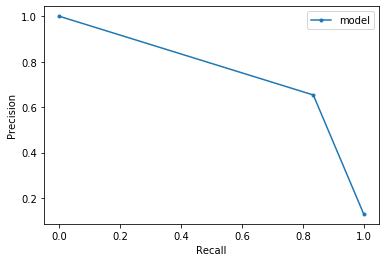

(232, 1736, 46, 123)

In [234]:
evaluate(y_pred_class, y_test, y_probs)

_____
# Feature Importance

In [56]:
explainer = shap.TreeExplainer(final_model)

In [57]:
shap_values = explainer.shap_values(X_test, approximate=True)

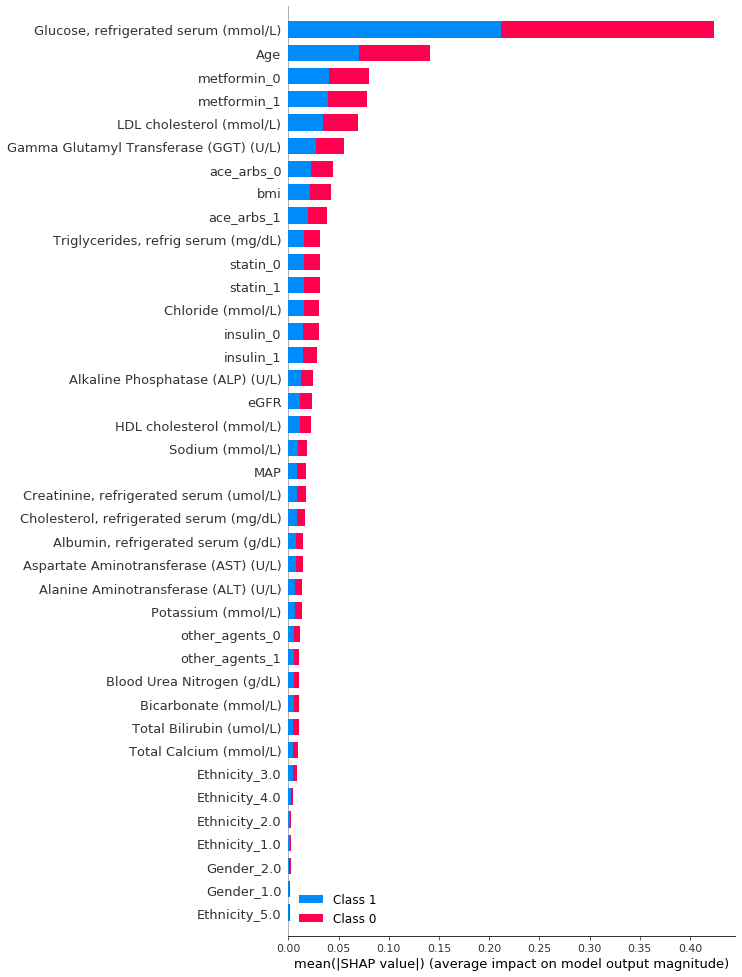

In [58]:
shap.summary_plot(shap_values, X_test, max_display=39)

In [59]:
vals= np.abs(shap_values[0]).mean(0)

In [60]:
feature_importance = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])

In [61]:
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)

In [62]:
feature_importance

col_name  feature_importance_vals
12     Glucose, refrigerated serum (mmol/L)                 0.211793
0                                       Age                 0.070622
31                              metformin_0                 0.040321
32                              metformin_1                 0.039281
18                 LDL cholesterol (mmol/L)                 0.034860
11   Gamma Glutamyl Transferase (GGT) (U/L)                 0.027880
37                               ace_arbs_0                 0.022182
1                                       bmi                 0.021153
38                               ace_arbs_1                 0.019082
17      Triglycerides, refrig serum (mg/dL)                 0.015916
35                                 statin_0                 0.015871
36                                 statin_1                 0.015648
8                         Chloride (mmol/L)                 0.015454
33                                insulin_0                 0.014997
34                                insulin_1                 0.014437
4          Alkaline Phosphatase (ALP) (U/L)                 0.012344
20                                     eGFR                 0.011870
19                 HDL cholesterol (mmol/L)                 0.011312
14                          Sodium (mmol/L)                 0.009410
21                                      MAP                 0.008963
10  Creatinine, refrigerated serum (umol/L)                 0.008551
9   Cholesterol, refrigerated serum (mg/dL)                 0.008465
3        Albumin, refrigerated serum (g/dL)                 0.007348
5    Aspartate Aminotransferase (AST) (U/L)                 0.007163
2      Alanine Aminotransferase (ALT) (U/L)                 0.006844
13                       Potassium (mmol/L)                 0.006744
29                           other_agents_0                 0.005802
30                           other_agents_1                 0.005488
7                Blood Urea Nitrogen (g/dL)                 0.005235
6                      Bicarbonate (mmol/L)                 0.005099
15                 Total Bilirubin (umol/L)                 0.005039
16                   Total Calcium (mmol/L)                 0.004782
26                            Ethnicity_3.0                 0.004461
27                            Ethnicity_4.0                 0.002389
25                            Ethnicity_2.0                 0.001304
24                            Ethnicity_1.0                 0.001192
23                               Gender_2.0                 0.001043
22                               Gender_1.0                 0.001001
28                            Ethnicity_5.0                 0.000790

In [63]:
ordered_features = list(feature_importance['col_name'])

____
# Random Forest Model: Selecting Feature

In [64]:
#load data 
df = pd.read_csv('nhanes_extracted.csv')  
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [65]:
features = ['Age', 'bmi',
       'Alanine Aminotransferase (ALT) (U/L)',
       'Albumin, refrigerated serum (g/dL)',
       'Alkaline Phosphatase (ALP) (U/L)',
       'Aspartate Aminotransferase (AST) (U/L)', 'Bicarbonate (mmol/L)',
       'Blood Urea Nitrogen (g/dL)', 'Chloride (mmol/L)',
       'Cholesterol, refrigerated serum (mg/dL)',
       'Creatinine, refrigerated serum (umol/L)',
       'Gamma Glutamyl Transferase (GGT) (U/L)',
       'Glucose, refrigerated serum (mmol/L)', 'Potassium (mmol/L)',
       'Sodium (mmol/L)', 'Total Bilirubin (umol/L)', 'Total Calcium (mmol/L)',
       'Triglycerides, refrig serum (mg/dL)', 'LDL cholesterol (mmol/L)',
       'HDL cholesterol (mmol/L)',  'eGFR', 'MAP', 
       'Gender_1.0', 'Gender_2.0', 'Ethnicity_1.0',
       'Ethnicity_2.0', 'Ethnicity_3.0', 'Ethnicity_4.0', 'Ethnicity_5.0',
       'other_agents_0', 'other_agents_1', 'metformin_0', 'metformin_1',
       'insulin_0', 'insulin_1', 'statin_0', 'statin_1', 'ace_arbs_0',
       'ace_arbs_1']

In [66]:
df.dropna(how='all', subset=labs, inplace=True)

In [67]:
df.dropna(subset=['hba1c_result'], inplace=True)

In [68]:
#fill missing data with out-of-sample 
df.fillna(-999, inplace=True)

In [69]:
#one-hot-encoding of categorical variables
df = pd.get_dummies(df, columns = ['Gender', 'Ethnicity', 'other_agents', 'metformin', 'insulin', 'statin', 'ace_arbs'])

In [70]:
df = df[features + ['diagnostic_t2dm']]

In [71]:
df.columns

Index(['Age', 'bmi', 'Alanine Aminotransferase (ALT) (U/L)',
       'Albumin, refrigerated serum (g/dL)',
       'Alkaline Phosphatase (ALP) (U/L)',
       'Aspartate Aminotransferase (AST) (U/L)', 'Bicarbonate (mmol/L)',
       'Blood Urea Nitrogen (g/dL)', 'Chloride (mmol/L)',
       'Cholesterol, refrigerated serum (mg/dL)',
       'Creatinine, refrigerated serum (umol/L)',
       'Gamma Glutamyl Transferase (GGT) (U/L)',
       'Glucose, refrigerated serum (mmol/L)', 'Potassium (mmol/L)',
       'Sodium (mmol/L)', 'Total Bilirubin (umol/L)', 'Total Calcium (mmol/L)',
       'Triglycerides, refrig serum (mg/dL)', 'LDL cholesterol (mmol/L)',
       'HDL cholesterol (mmol/L)', 'eGFR', 'MAP', 'Gender_1.0', 'Gender_2.0',
       'Ethnicity_1.0', 'Ethnicity_2.0', 'Ethnicity_3.0', 'Ethnicity_4.0',
       'Ethnicity_5.0', 'other_agents_0', 'other_agents_1', 'metformin_0',
       'metformin_1', 'insulin_0', 'insulin_1', 'statin_0', 'statin_1',
       'ace_arbs_0', 'ace_arbs_1', 'diagnostic_t

In [72]:
def evaluate(y_pred_class, y_test, y_probs): 
    """Evaluate Model"""

    print('\n##### Evaluating Model #####')
    
    print("ROC AUC SCORE: {:.2f}".format(roc_auc_score(y_test, y_probs)))
    
    #confusion matrix 
    
    cm = confusion_matrix(y_test, y_pred_class)
    print('\n', cm)
    
    TN, FP, FN, TP = cm.ravel()
    
    print('\nTrue Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    #print metrics 
    print('\n')
    print('Recall:', recall_score(y_test, y_pred_class))
    print('Precision:', precision_score(y_test, y_pred_class))
    print('Specificity', TN/(TN+FP))
    print('F1 score:', f1_score(y_test, y_pred_class))
    print('F2 score:', fbeta_score(y_test, y_pred_class, beta=2))
    
    f2_outcome = fbeta_score(y_test, y_pred_class, beta=2)
    
    
    #precision_recall_curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_class)
    pyplot.plot(recall,precision, marker='.', label='model')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()
    
    
    return(f2_outcome, TP, TN, FN, FP)

In [73]:
def process(df, features): 

    
    #prepare df 
    X = df[features]
    y = df['diagnostic_t2dm']
    
    
    #split into train-test (10% test and 15% validate)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.056, random_state=1, stratify = y_train)

    
    #scale 
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)
    
    #instantiate 
    model = RandomForestClassifier(random_state = 42)
    
    #fit 
    model.fit(X_train, y_train)
    
    #predict for validate set 
    y_preds =  cross_val_predict(model, X_val, y_val, cv=5)
    y_probs = cross_val_predict(model, X_val, y_val, cv=5, method='predict_proba')[:, 1]
    
    #select threshold based on validate dataset 
    threshold, result = threshold_setting(y_probs, y_val)
    
    #apply this threshold to the test set 
    y_preds =  cross_val_predict(model, X_test, y_test, cv=5)
    y_probs = cross_val_predict(model, X_test, y_test, cv=5, method='predict_proba')[:, 1]
    
    #apply threshold 
    y_pred_class = np.where(y_probs > threshold, 1, 0)
    
    #evaluate
    fbeta, TP, TN, FN, FP = evaluate(y_pred_class, y_test, y_probs)
    
    return(fbeta)
    


**************

TESTING: 1 features

 ['Glucose, refrigerated serum (mmol/L)']
Best F2 score: 0.6891701828410688 at a threshold of 0.17

##### Evaluating Model #####
ROC AUC SCORE: 0.89

 [[1709  150]
 [  64  214]]

True Positives: 214
True Negatives: 1709
False Positives: 150
False Negatives: 64


Recall: 0.7697841726618705
Precision: 0.5879120879120879
Specificity 0.9193114577729963
F1 score: 0.6666666666666666
F2 score: 0.7249322493224932


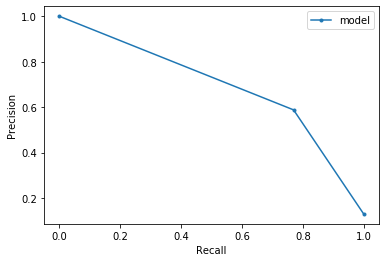

0.7249322493224932

**************

TESTING: 2 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age']
Best F2 score: 0.6542056074766356 at a threshold of 0.15

##### Evaluating Model #####
ROC AUC SCORE: 0.91

 [[1640  219]
 [  64  214]]

True Positives: 214
True Negatives: 1640
False Positives: 219
False Negatives: 64


Recall: 0.7697841726618705
Precision: 0.4942263279445728
Specificity 0.8821947283485745
F1 score: 0.6019690576652602
F2 score: 0.692556634304207


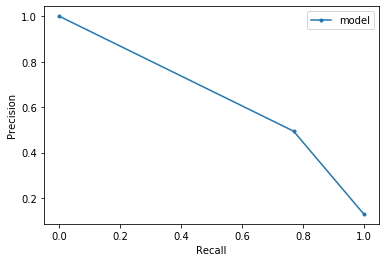

0.692556634304207

**************

TESTING: 3 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0']
Best F2 score: 0.7200538358008075 at a threshold of 0.17

##### Evaluating Model #####
ROC AUC SCORE: 0.89

 [[1656  203]
 [  60  218]]

True Positives: 218
True Negatives: 1656
False Positives: 203
False Negatives: 60


Recall: 0.7841726618705036
Precision: 0.517814726840855
Specificity 0.8908015061861215
F1 score: 0.6237482117310443
F2 score: 0.7110241356816699


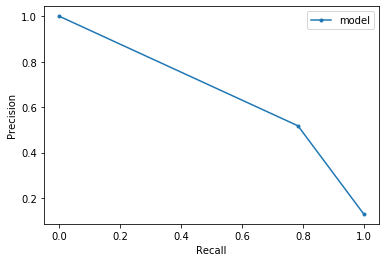

0.7110241356816699

**************

TESTING: 4 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1']
Best F2 score: 0.7362784471218207 at a threshold of 0.14

##### Evaluating Model #####
ROC AUC SCORE: 0.90

 [[1639  220]
 [  60  218]]

True Positives: 218
True Negatives: 1639
False Positives: 220
False Negatives: 60


Recall: 0.7841726618705036
Precision: 0.4977168949771689
Specificity 0.8816568047337278
F1 score: 0.6089385474860336
F2 score: 0.7032258064516129


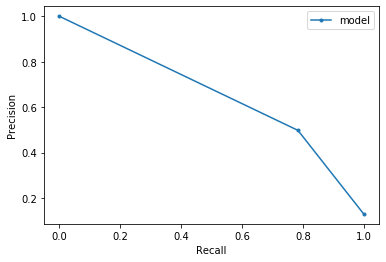

0.7032258064516129

**************

TESTING: 5 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)']
Best F2 score: 0.7825484764542937 at a threshold of 0.44

##### Evaluating Model #####
ROC AUC SCORE: 0.92

 [[1801   58]
 [  82  196]]

True Positives: 196
True Negatives: 1801
False Positives: 58
False Negatives: 82


Recall: 0.7050359712230215
Precision: 0.7716535433070866
Specificity 0.9688004303388918
F1 score: 0.7368421052631577
F2 score: 0.7174231332357247


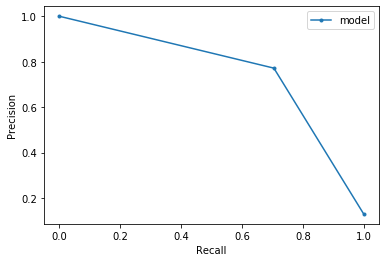

0.7174231332357247

**************

TESTING: 6 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)']
Best F2 score: 0.7909215955983493 at a threshold of 0.28

##### Evaluating Model #####
ROC AUC SCORE: 0.93

 [[1756  103]
 [  65  213]]

True Positives: 213
True Negatives: 1756
False Positives: 103
False Negatives: 65


Recall: 0.7661870503597122
Precision: 0.6740506329113924
Specificity 0.9445938676707908
F1 score: 0.7171717171717171
F2 score: 0.7457983193277311


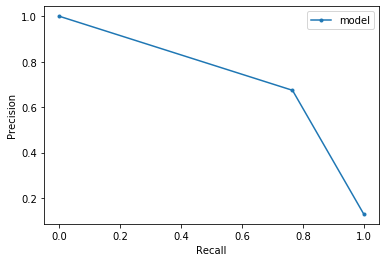

0.7457983193277311

**************

TESTING: 7 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0']
Best F2 score: 0.7782369146005511 at a threshold of 0.34

##### Evaluating Model #####
ROC AUC SCORE: 0.93

 [[1777   82]
 [  73  205]]

True Positives: 205
True Negatives: 1777
False Positives: 82
False Negatives: 73


Recall: 0.737410071942446
Precision: 0.7142857142857143
Specificity 0.9558902635825712
F1 score: 0.7256637168141593
F2 score: 0.7326661901358112


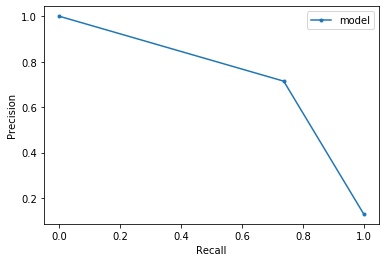

0.7326661901358112

**************

TESTING: 8 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi']
Best F2 score: 0.7988980716253443 at a threshold of 0.28

##### Evaluating Model #####
ROC AUC SCORE: 0.93

 [[1765   94]
 [  62  216]]

True Positives: 216
True Negatives: 1765
False Positives: 94
False Negatives: 62


Recall: 0.7769784172661871
Precision: 0.6967741935483871
Specificity 0.949435180204411
F1 score: 0.7346938775510204
F2 score: 0.759493670886076


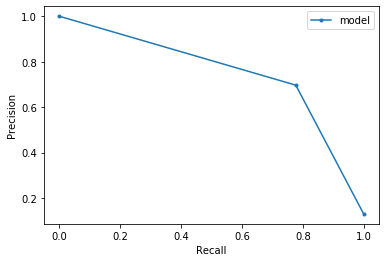

0.759493670886076

**************

TESTING: 9 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1']
Best F2 score: 0.7898351648351648 at a threshold of 0.34

##### Evaluating Model #####
ROC AUC SCORE: 0.93

 [[1781   78]
 [  71  207]]

True Positives: 207
True Negatives: 1781
False Positives: 78
False Negatives: 71


Recall: 0.7446043165467626
Precision: 0.7263157894736842
Specificity 0.958041958041958
F1 score: 0.7353463587921848
F2 score: 0.7408732999284181


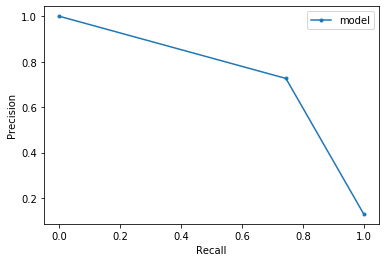

0.7408732999284181

**************

TESTING: 10 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)']
Best F2 score: 0.7825484764542937 at a threshold of 0.15

##### Evaluating Model #####
ROC AUC SCORE: 0.94

 [[1661  198]
 [  44  234]]

True Positives: 234
True Negatives: 1661
False Positives: 198
False Negatives: 44


Recall: 0.841726618705036
Precision: 0.5416666666666666
Specificity 0.893491124260355
F1 score: 0.6591549295774647
F2 score: 0.7577720207253886


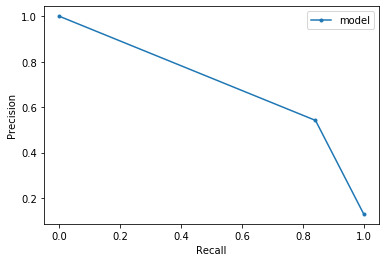

0.7577720207253886

**************

TESTING: 11 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0']
Best F2 score: 0.7887517146776405 at a threshold of 0.16

##### Evaluating Model #####
ROC AUC SCORE: 0.93

 [[1673  186]
 [  44  234]]

True Positives: 234
True Negatives: 1673
False Positives: 186
False Negatives: 44


Recall: 0.841726618705036
Precision: 0.5571428571428572
Specificity 0.8999462076385153
F1 score: 0.6704871060171921
F2 score: 0.7637075718015665


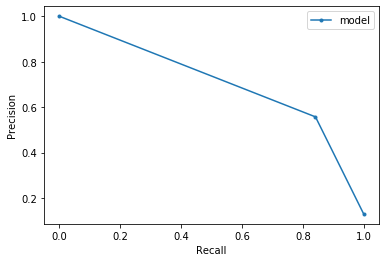

0.7637075718015665

**************

TESTING: 12 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0', 'statin_1']
Best F2 score: 0.7941988950276243 at a threshold of 0.21

##### Evaluating Model #####
ROC AUC SCORE: 0.93

 [[1720  139]
 [  56  222]]

True Positives: 222
True Negatives: 1720
False Positives: 139
False Negatives: 56


Recall: 0.7985611510791367
Precision: 0.6149584487534626
Specificity 0.9252286175363098
F1 score: 0.6948356807511737
F2 score: 0.7535641547861507


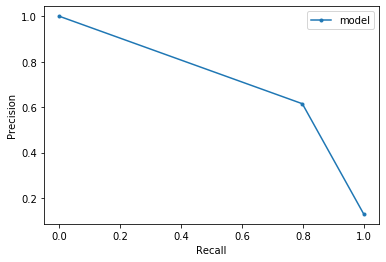

0.7535641547861507

**************

TESTING: 13 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0', 'statin_1', 'Chloride (mmol/L)']
Best F2 score: 0.7825484764542937 at a threshold of 0.18

##### Evaluating Model #####
ROC AUC SCORE: 0.93

 [[1688  171]
 [  47  231]]

True Positives: 231
True Negatives: 1688
False Positives: 171
False Negatives: 47


Recall: 0.8309352517985612
Precision: 0.5746268656716418
Specificity 0.9080150618612157
F1 score: 0.6794117647058823
F2 score: 0.762879788639366


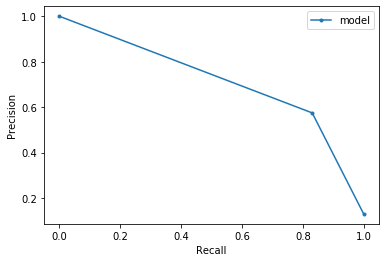

0.762879788639366

**************

TESTING: 14 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0', 'statin_1', 'Chloride (mmol/L)', 'insulin_0']
Best F2 score: 0.7803867403314917 at a threshold of 0.15

##### Evaluating Model #####
ROC AUC SCORE: 0.94

 [[1680  179]
 [  41  237]]

True Positives: 237
True Negatives: 1680
False Positives: 179
False Negatives: 41


Recall: 0.8525179856115108
Precision: 0.5697115384615384
Specificity 0.9037116729424421
F1 score: 0.6829971181556197
F2 score: 0.775523560209424


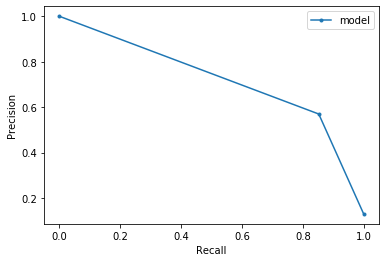

0.775523560209424

**************

TESTING: 15 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0', 'statin_1', 'Chloride (mmol/L)', 'insulin_0', 'insulin_1']
Best F2 score: 0.7793103448275862 at a threshold of 0.17

##### Evaluating Model #####
ROC AUC SCORE: 0.94

 [[1698  161]
 [  41  237]]

True Positives: 237
True Negatives: 1698
False Positives: 161
False Negatives: 41


Recall: 0.8525179856115108
Precision: 0.5954773869346733
Specificity 0.9133942980096826
F1 score: 0.7011834319526626
F2 score: 0.7847682119205298


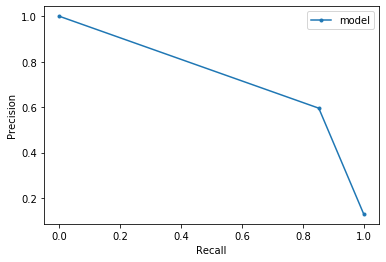

0.7847682119205298

**************

TESTING: 16 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0', 'statin_1', 'Chloride (mmol/L)', 'insulin_0', 'insulin_1', 'Alkaline Phosphatase (ALP) (U/L)']
Best F2 score: 0.7887517146776405 at a threshold of 0.25

##### Evaluating Model #####
ROC AUC SCORE: 0.95

 [[1751  108]
 [  51  227]]

True Positives: 227
True Negatives: 1751
False Positives: 108
False Negatives: 51


Recall: 0.8165467625899281
Precision: 0.6776119402985075
Specificity 0.9419042495965573
F1 score: 0.7406199021207177
F2 score: 0.7843814789219073


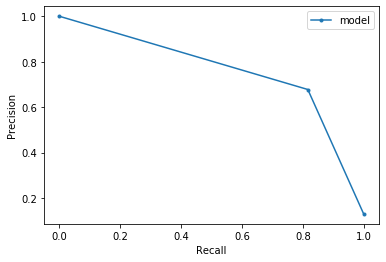

0.7843814789219073

**************

TESTING: 17 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0', 'statin_1', 'Chloride (mmol/L)', 'insulin_0', 'insulin_1', 'Alkaline Phosphatase (ALP) (U/L)', 'eGFR']
Best F2 score: 0.7803867403314917 at a threshold of 0.19

##### Evaluating Model #####
ROC AUC SCORE: 0.94

 [[1713  146]
 [  46  232]]

True Positives: 232
True Negatives: 1713
False Positives: 146
False Negatives: 46


Recall: 0.8345323741007195
Precision: 0.6137566137566137
Specificity 0.921463152232383
F1 score: 0.7073170731707317
F2 score: 0.7785234899328859


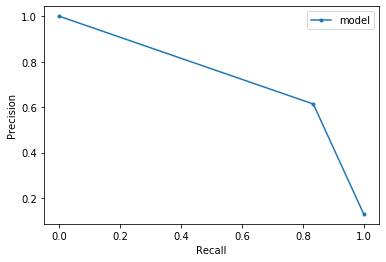

0.7785234899328859

**************

TESTING: 18 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0', 'statin_1', 'Chloride (mmol/L)', 'insulin_0', 'insulin_1', 'Alkaline Phosphatase (ALP) (U/L)', 'eGFR', 'HDL cholesterol (mmol/L)']
Best F2 score: 0.7808219178082191 at a threshold of 0.2

##### Evaluating Model #####
ROC AUC SCORE: 0.95

 [[1715  144]
 [  43  235]]

True Positives: 235
True Negatives: 1715
False Positives: 144
False Negatives: 43


Recall: 0.8453237410071942
Precision: 0.6200527704485488
Specificity 0.9225389994620764
F1 score: 0.7153729071537289
F2 score: 0.7880617035546612


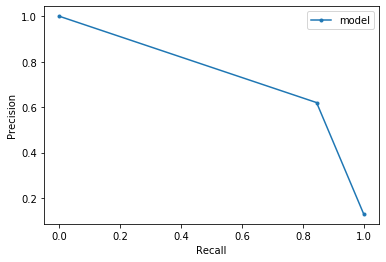

0.7880617035546612

**************

TESTING: 19 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0', 'statin_1', 'Chloride (mmol/L)', 'insulin_0', 'insulin_1', 'Alkaline Phosphatase (ALP) (U/L)', 'eGFR', 'HDL cholesterol (mmol/L)', 'Sodium (mmol/L)']
Best F2 score: 0.7876712328767125 at a threshold of 0.27

##### Evaluating Model #####
ROC AUC SCORE: 0.95

 [[1762   97]
 [  54  224]]

True Positives: 224
True Negatives: 1762
False Positives: 97
False Negatives: 54


Recall: 0.8057553956834532
Precision: 0.6978193146417445
Specificity 0.9478214093598709
F1 score: 0.7479131886477463
F2 score: 0.7815771109560363


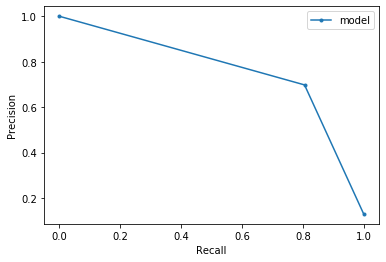

0.7815771109560363

**************

TESTING: 20 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0', 'statin_1', 'Chloride (mmol/L)', 'insulin_0', 'insulin_1', 'Alkaline Phosphatase (ALP) (U/L)', 'eGFR', 'HDL cholesterol (mmol/L)', 'Sodium (mmol/L)', 'MAP']
Best F2 score: 0.7876712328767125 at a threshold of 0.26

##### Evaluating Model #####
ROC AUC SCORE: 0.95

 [[1769   90]
 [  57  221]]

True Positives: 221
True Negatives: 1769
False Positives: 90
False Negatives: 57


Recall: 0.7949640287769785
Precision: 0.7106109324758842
Specificity 0.9515868746637978
F1 score: 0.7504244482173175
F2 score: 0.7765284609978917


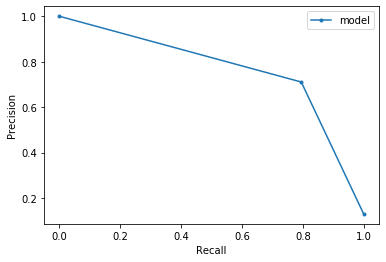

0.7765284609978917

**************

TESTING: 21 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0', 'statin_1', 'Chloride (mmol/L)', 'insulin_0', 'insulin_1', 'Alkaline Phosphatase (ALP) (U/L)', 'eGFR', 'HDL cholesterol (mmol/L)', 'Sodium (mmol/L)', 'MAP', 'Creatinine, refrigerated serum (umol/L)']
Best F2 score: 0.7729138166894666 at a threshold of 0.28

##### Evaluating Model #####
ROC AUC SCORE: 0.95

 [[1763   96]
 [  58  220]]

True Positives: 220
True Negatives: 1763
False Positives: 96
False Negatives: 58


Recall: 0.7913669064748201
Precision: 0.6962025316455697
Specificity 0.9483593329747176
F1 score: 0.7407407407407407
F2 score: 0.7703081232492996


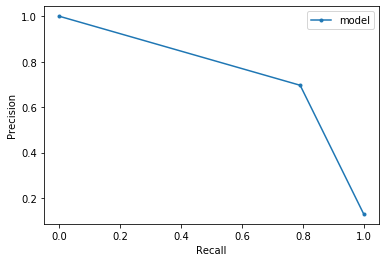

0.7703081232492996

**************

TESTING: 22 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0', 'statin_1', 'Chloride (mmol/L)', 'insulin_0', 'insulin_1', 'Alkaline Phosphatase (ALP) (U/L)', 'eGFR', 'HDL cholesterol (mmol/L)', 'Sodium (mmol/L)', 'MAP', 'Creatinine, refrigerated serum (umol/L)', 'Cholesterol, refrigerated serum (mg/dL)']
Best F2 score: 0.7734056987788331 at a threshold of 0.35

##### Evaluating Model #####
ROC AUC SCORE: 0.95

 [[1802   57]
 [  61  217]]

True Positives: 217
True Negatives: 1802
False Positives: 57
False Negatives: 61


Recall: 0.7805755395683454
Precision: 0.791970802919708
Specificity 0.9693383539537386
F1 score: 0.786231884057971
F2 score: 0.7828282828282829


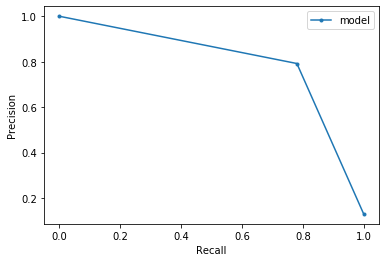

0.7828282828282829

**************

TESTING: 23 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0', 'statin_1', 'Chloride (mmol/L)', 'insulin_0', 'insulin_1', 'Alkaline Phosphatase (ALP) (U/L)', 'eGFR', 'HDL cholesterol (mmol/L)', 'Sodium (mmol/L)', 'MAP', 'Creatinine, refrigerated serum (umol/L)', 'Cholesterol, refrigerated serum (mg/dL)', 'Albumin, refrigerated serum (g/dL)']
Best F2 score: 0.7718579234972677 at a threshold of 0.35

##### Evaluating Model #####
ROC AUC SCORE: 0.95

 [[1798   61]
 [  65  213]]

True Positives: 213
True Negatives: 1798
False Positives: 61
False Negatives: 65


Recall: 0.7661870503597122
Precision: 0.7773722627737226
Specificity 0.9671866594943518
F1 score: 0.7717391304347826
F2 score: 0.7683982683982683


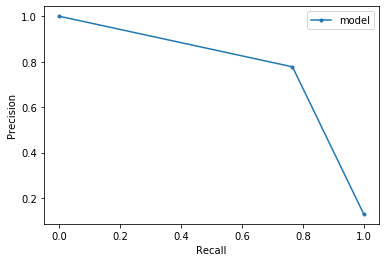

0.7683982683982683

**************

TESTING: 24 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0', 'statin_1', 'Chloride (mmol/L)', 'insulin_0', 'insulin_1', 'Alkaline Phosphatase (ALP) (U/L)', 'eGFR', 'HDL cholesterol (mmol/L)', 'Sodium (mmol/L)', 'MAP', 'Creatinine, refrigerated serum (umol/L)', 'Cholesterol, refrigerated serum (mg/dL)', 'Albumin, refrigerated serum (g/dL)', 'Aspartate Aminotransferase (AST) (U/L)']
Best F2 score: 0.7739726027397259 at a threshold of 0.31

##### Evaluating Model #####
ROC AUC SCORE: 0.95

 [[1780   79]
 [  60  218]]

True Positives: 218
True Negatives: 1780
False Positives: 79
False Negatives: 60


Recall: 0.7841726618705036
Precision: 0.734006734006734
Specificity 0.9575040344271114
F1 score: 0.7582608695652174
F2 score: 0.7735982966643009


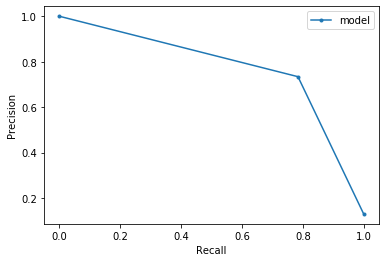

0.7735982966643009

**************

TESTING: 25 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0', 'statin_1', 'Chloride (mmol/L)', 'insulin_0', 'insulin_1', 'Alkaline Phosphatase (ALP) (U/L)', 'eGFR', 'HDL cholesterol (mmol/L)', 'Sodium (mmol/L)', 'MAP', 'Creatinine, refrigerated serum (umol/L)', 'Cholesterol, refrigerated serum (mg/dL)', 'Albumin, refrigerated serum (g/dL)', 'Aspartate Aminotransferase (AST) (U/L)', 'Alanine Aminotransferase (ALT) (U/L)']
Best F2 score: 0.7614555256064691 at a threshold of 0.18

##### Evaluating Model #####
ROC AUC SCORE: 0.95

 [[1687  172]
 [  44  234]]

True Positives: 234
True Negatives: 1687
False Positives: 172
False Negatives: 44


Recall: 0.841726618705036
Precision: 0.5763546798029556
Specificity 0.907477138246369
F1 score: 0.6842105263157895
F2 score

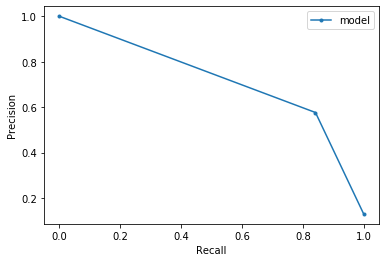

0.7707509881422925

**************

TESTING: 26 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0', 'statin_1', 'Chloride (mmol/L)', 'insulin_0', 'insulin_1', 'Alkaline Phosphatase (ALP) (U/L)', 'eGFR', 'HDL cholesterol (mmol/L)', 'Sodium (mmol/L)', 'MAP', 'Creatinine, refrigerated serum (umol/L)', 'Cholesterol, refrigerated serum (mg/dL)', 'Albumin, refrigerated serum (g/dL)', 'Aspartate Aminotransferase (AST) (U/L)', 'Alanine Aminotransferase (ALT) (U/L)', 'Potassium (mmol/L)']
Best F2 score: 0.7770270270270271 at a threshold of 0.28

##### Evaluating Model #####
ROC AUC SCORE: 0.95

 [[1758  101]
 [  52  226]]

True Positives: 226
True Negatives: 1758
False Positives: 101
False Negatives: 52


Recall: 0.8129496402877698
Precision: 0.691131498470948
Specificity 0.9456697149004841
F1 score: 0.74

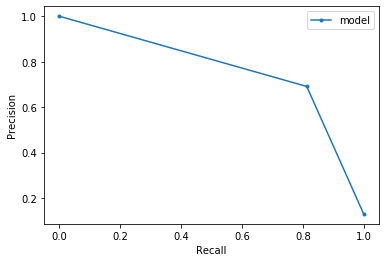

0.7852675469075747

**************

TESTING: 27 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0', 'statin_1', 'Chloride (mmol/L)', 'insulin_0', 'insulin_1', 'Alkaline Phosphatase (ALP) (U/L)', 'eGFR', 'HDL cholesterol (mmol/L)', 'Sodium (mmol/L)', 'MAP', 'Creatinine, refrigerated serum (umol/L)', 'Cholesterol, refrigerated serum (mg/dL)', 'Albumin, refrigerated serum (g/dL)', 'Aspartate Aminotransferase (AST) (U/L)', 'Alanine Aminotransferase (ALT) (U/L)', 'Potassium (mmol/L)', 'other_agents_0']
Best F2 score: 0.7894736842105263 at a threshold of 0.3

##### Evaluating Model #####
ROC AUC SCORE: 0.95

 [[1765   94]
 [  58  220]]

True Positives: 220
True Negatives: 1765
False Positives: 94
False Negatives: 58


Recall: 0.7913669064748201
Precision: 0.7006369426751592
Specificity 0.94943518020441

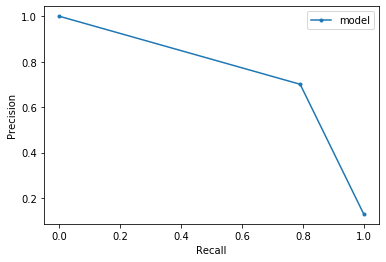

0.7713884992987377

**************

TESTING: 28 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0', 'statin_1', 'Chloride (mmol/L)', 'insulin_0', 'insulin_1', 'Alkaline Phosphatase (ALP) (U/L)', 'eGFR', 'HDL cholesterol (mmol/L)', 'Sodium (mmol/L)', 'MAP', 'Creatinine, refrigerated serum (umol/L)', 'Cholesterol, refrigerated serum (mg/dL)', 'Albumin, refrigerated serum (g/dL)', 'Aspartate Aminotransferase (AST) (U/L)', 'Alanine Aminotransferase (ALT) (U/L)', 'Potassium (mmol/L)', 'other_agents_0', 'other_agents_1']
Best F2 score: 0.7776261937244203 at a threshold of 0.31

##### Evaluating Model #####
ROC AUC SCORE: 0.95

 [[1776   83]
 [  60  218]]

True Positives: 218
True Negatives: 1776
False Positives: 83
False Negatives: 60


Recall: 0.7841726618705036
Precision: 0.7242524916943521
Specifici

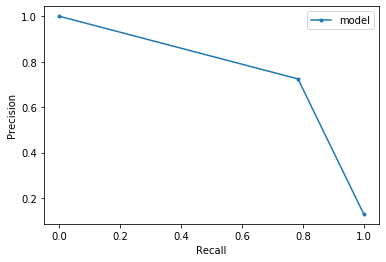

0.7714083510261855

**************

TESTING: 29 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0', 'statin_1', 'Chloride (mmol/L)', 'insulin_0', 'insulin_1', 'Alkaline Phosphatase (ALP) (U/L)', 'eGFR', 'HDL cholesterol (mmol/L)', 'Sodium (mmol/L)', 'MAP', 'Creatinine, refrigerated serum (umol/L)', 'Cholesterol, refrigerated serum (mg/dL)', 'Albumin, refrigerated serum (g/dL)', 'Aspartate Aminotransferase (AST) (U/L)', 'Alanine Aminotransferase (ALT) (U/L)', 'Potassium (mmol/L)', 'other_agents_0', 'other_agents_1', 'Blood Urea Nitrogen (g/dL)']
Best F2 score: 0.7945205479452055 at a threshold of 0.28

##### Evaluating Model #####
ROC AUC SCORE: 0.95

 [[1760   99]
 [  56  222]]

True Positives: 222
True Negatives: 1760
False Positives: 99
False Negatives: 56


Recall: 0.7985611510791367
Precision

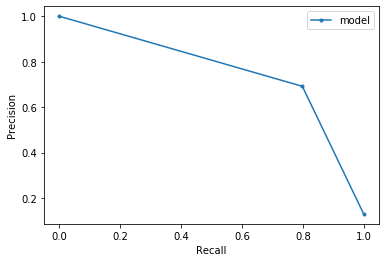

0.7745987438939288

**************

TESTING: 30 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0', 'statin_1', 'Chloride (mmol/L)', 'insulin_0', 'insulin_1', 'Alkaline Phosphatase (ALP) (U/L)', 'eGFR', 'HDL cholesterol (mmol/L)', 'Sodium (mmol/L)', 'MAP', 'Creatinine, refrigerated serum (umol/L)', 'Cholesterol, refrigerated serum (mg/dL)', 'Albumin, refrigerated serum (g/dL)', 'Aspartate Aminotransferase (AST) (U/L)', 'Alanine Aminotransferase (ALT) (U/L)', 'Potassium (mmol/L)', 'other_agents_0', 'other_agents_1', 'Blood Urea Nitrogen (g/dL)', 'Bicarbonate (mmol/L)']
Best F2 score: 0.7801899592944368 at a threshold of 0.31

##### Evaluating Model #####
ROC AUC SCORE: 0.95

 [[1776   83]
 [  59  219]]

True Positives: 219
True Negatives: 1776
False Positives: 83
False Negatives: 59


Recall: 0.78

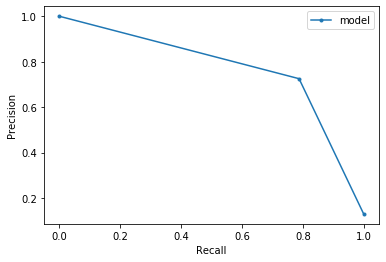

0.7743988684582743

**************

TESTING: 31 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0', 'statin_1', 'Chloride (mmol/L)', 'insulin_0', 'insulin_1', 'Alkaline Phosphatase (ALP) (U/L)', 'eGFR', 'HDL cholesterol (mmol/L)', 'Sodium (mmol/L)', 'MAP', 'Creatinine, refrigerated serum (umol/L)', 'Cholesterol, refrigerated serum (mg/dL)', 'Albumin, refrigerated serum (g/dL)', 'Aspartate Aminotransferase (AST) (U/L)', 'Alanine Aminotransferase (ALT) (U/L)', 'Potassium (mmol/L)', 'other_agents_0', 'other_agents_1', 'Blood Urea Nitrogen (g/dL)', 'Bicarbonate (mmol/L)', 'Total Bilirubin (umol/L)']
Best F2 score: 0.7780784844384302 at a threshold of 0.3

##### Evaluating Model #####
ROC AUC SCORE: 0.95

 [[1771   88]
 [  58  220]]

True Positives: 220
True Negatives: 1771
False Positives: 88
False N

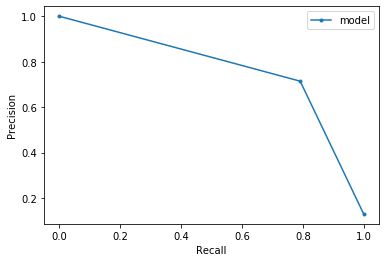

0.7746478873239437

**************

TESTING: 32 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0', 'statin_1', 'Chloride (mmol/L)', 'insulin_0', 'insulin_1', 'Alkaline Phosphatase (ALP) (U/L)', 'eGFR', 'HDL cholesterol (mmol/L)', 'Sodium (mmol/L)', 'MAP', 'Creatinine, refrigerated serum (umol/L)', 'Cholesterol, refrigerated serum (mg/dL)', 'Albumin, refrigerated serum (g/dL)', 'Aspartate Aminotransferase (AST) (U/L)', 'Alanine Aminotransferase (ALT) (U/L)', 'Potassium (mmol/L)', 'other_agents_0', 'other_agents_1', 'Blood Urea Nitrogen (g/dL)', 'Bicarbonate (mmol/L)', 'Total Bilirubin (umol/L)', 'Total Calcium (mmol/L)']
Best F2 score: 0.7833787465940054 at a threshold of 0.34

##### Evaluating Model #####
ROC AUC SCORE: 0.95

 [[1778   81]
 [  59  219]]

True Positives: 219
True Negatives: 1778


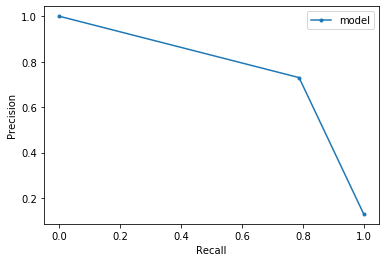

0.7754957507082153

**************

TESTING: 33 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0', 'statin_1', 'Chloride (mmol/L)', 'insulin_0', 'insulin_1', 'Alkaline Phosphatase (ALP) (U/L)', 'eGFR', 'HDL cholesterol (mmol/L)', 'Sodium (mmol/L)', 'MAP', 'Creatinine, refrigerated serum (umol/L)', 'Cholesterol, refrigerated serum (mg/dL)', 'Albumin, refrigerated serum (g/dL)', 'Aspartate Aminotransferase (AST) (U/L)', 'Alanine Aminotransferase (ALT) (U/L)', 'Potassium (mmol/L)', 'other_agents_0', 'other_agents_1', 'Blood Urea Nitrogen (g/dL)', 'Bicarbonate (mmol/L)', 'Total Bilirubin (umol/L)', 'Total Calcium (mmol/L)', 'Ethnicity_3.0']
Best F2 score: 0.7880434782608696 at a threshold of 0.32

##### Evaluating Model #####
ROC AUC SCORE: 0.95

 [[1776   83]
 [  61  217]]

True Positives: 217
True

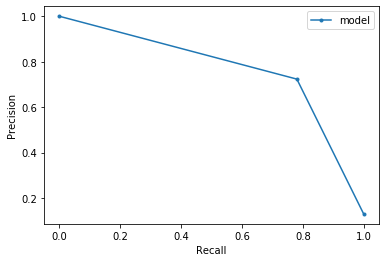

0.7684135977337111

**************

TESTING: 34 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0', 'statin_1', 'Chloride (mmol/L)', 'insulin_0', 'insulin_1', 'Alkaline Phosphatase (ALP) (U/L)', 'eGFR', 'HDL cholesterol (mmol/L)', 'Sodium (mmol/L)', 'MAP', 'Creatinine, refrigerated serum (umol/L)', 'Cholesterol, refrigerated serum (mg/dL)', 'Albumin, refrigerated serum (g/dL)', 'Aspartate Aminotransferase (AST) (U/L)', 'Alanine Aminotransferase (ALT) (U/L)', 'Potassium (mmol/L)', 'other_agents_0', 'other_agents_1', 'Blood Urea Nitrogen (g/dL)', 'Bicarbonate (mmol/L)', 'Total Bilirubin (umol/L)', 'Total Calcium (mmol/L)', 'Ethnicity_3.0', 'Ethnicity_4.0']
Best F2 score: 0.7948369565217391 at a threshold of 0.32

##### Evaluating Model #####
ROC AUC SCORE: 0.95

 [[1781   78]
 [  60  218]]

True Po

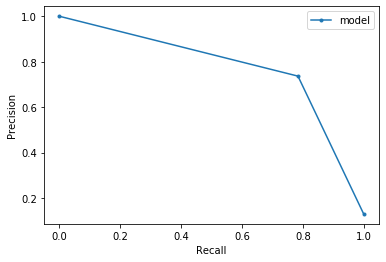

0.7741477272727273

**************

TESTING: 35 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0', 'statin_1', 'Chloride (mmol/L)', 'insulin_0', 'insulin_1', 'Alkaline Phosphatase (ALP) (U/L)', 'eGFR', 'HDL cholesterol (mmol/L)', 'Sodium (mmol/L)', 'MAP', 'Creatinine, refrigerated serum (umol/L)', 'Cholesterol, refrigerated serum (mg/dL)', 'Albumin, refrigerated serum (g/dL)', 'Aspartate Aminotransferase (AST) (U/L)', 'Alanine Aminotransferase (ALT) (U/L)', 'Potassium (mmol/L)', 'other_agents_0', 'other_agents_1', 'Blood Urea Nitrogen (g/dL)', 'Bicarbonate (mmol/L)', 'Total Bilirubin (umol/L)', 'Total Calcium (mmol/L)', 'Ethnicity_3.0', 'Ethnicity_4.0', 'Ethnicity_2.0']
Best F2 score: 0.7865937072503421 at a threshold of 0.27

##### Evaluating Model #####
ROC AUC SCORE: 0.95

 [[1754  105]
 [  5

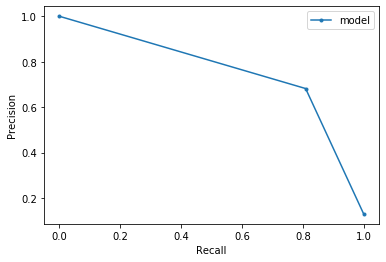

0.7801664355062413

**************

TESTING: 36 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0', 'statin_1', 'Chloride (mmol/L)', 'insulin_0', 'insulin_1', 'Alkaline Phosphatase (ALP) (U/L)', 'eGFR', 'HDL cholesterol (mmol/L)', 'Sodium (mmol/L)', 'MAP', 'Creatinine, refrigerated serum (umol/L)', 'Cholesterol, refrigerated serum (mg/dL)', 'Albumin, refrigerated serum (g/dL)', 'Aspartate Aminotransferase (AST) (U/L)', 'Alanine Aminotransferase (ALT) (U/L)', 'Potassium (mmol/L)', 'other_agents_0', 'other_agents_1', 'Blood Urea Nitrogen (g/dL)', 'Bicarbonate (mmol/L)', 'Total Bilirubin (umol/L)', 'Total Calcium (mmol/L)', 'Ethnicity_3.0', 'Ethnicity_4.0', 'Ethnicity_2.0', 'Ethnicity_1.0']
Best F2 score: 0.7948369565217391 at a threshold of 0.27

##### Evaluating Model #####
ROC AUC SCORE: 0.95

 [

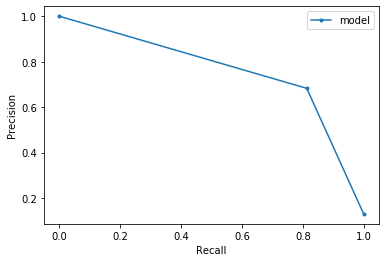

0.7830907830907831

**************

TESTING: 37 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0', 'statin_1', 'Chloride (mmol/L)', 'insulin_0', 'insulin_1', 'Alkaline Phosphatase (ALP) (U/L)', 'eGFR', 'HDL cholesterol (mmol/L)', 'Sodium (mmol/L)', 'MAP', 'Creatinine, refrigerated serum (umol/L)', 'Cholesterol, refrigerated serum (mg/dL)', 'Albumin, refrigerated serum (g/dL)', 'Aspartate Aminotransferase (AST) (U/L)', 'Alanine Aminotransferase (ALT) (U/L)', 'Potassium (mmol/L)', 'other_agents_0', 'other_agents_1', 'Blood Urea Nitrogen (g/dL)', 'Bicarbonate (mmol/L)', 'Total Bilirubin (umol/L)', 'Total Calcium (mmol/L)', 'Ethnicity_3.0', 'Ethnicity_4.0', 'Ethnicity_2.0', 'Ethnicity_1.0', 'Gender_2.0']
Best F2 score: 0.7869742198100407 at a threshold of 0.34

##### Evaluating Model #####
ROC AUC S

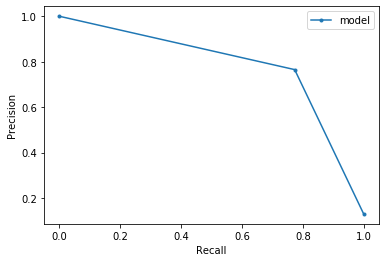

0.7717157214644652

**************

TESTING: 38 features

 ['Glucose, refrigerated serum (mmol/L)', 'Age', 'metformin_0', 'metformin_1', 'LDL cholesterol (mmol/L)', 'Gamma Glutamyl Transferase (GGT) (U/L)', 'ace_arbs_0', 'bmi', 'ace_arbs_1', 'Triglycerides, refrig serum (mg/dL)', 'statin_0', 'statin_1', 'Chloride (mmol/L)', 'insulin_0', 'insulin_1', 'Alkaline Phosphatase (ALP) (U/L)', 'eGFR', 'HDL cholesterol (mmol/L)', 'Sodium (mmol/L)', 'MAP', 'Creatinine, refrigerated serum (umol/L)', 'Cholesterol, refrigerated serum (mg/dL)', 'Albumin, refrigerated serum (g/dL)', 'Aspartate Aminotransferase (AST) (U/L)', 'Alanine Aminotransferase (ALT) (U/L)', 'Potassium (mmol/L)', 'other_agents_0', 'other_agents_1', 'Blood Urea Nitrogen (g/dL)', 'Bicarbonate (mmol/L)', 'Total Bilirubin (umol/L)', 'Total Calcium (mmol/L)', 'Ethnicity_3.0', 'Ethnicity_4.0', 'Ethnicity_2.0', 'Ethnicity_1.0', 'Gender_2.0', 'Gender_1.0']
Best F2 score: 0.7755102040816326 at a threshold of 0.29

##### Evaluating Model #

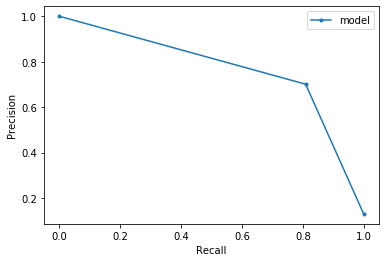

0.78506629448709


In [74]:
outcomes = dict()

for i in enumerate(ordered_features): 
    feature_index = i[0]
    features = ordered_features[:feature_index]
    
    if feature_index == 0: 
        pass
    else: 
        print('\n**************')
        print('\nTESTING:', feature_index, 'features')
        print('\n', features)
        fbeta = process(df, features)
        print(fbeta)
        outcomes[feature_index] = fbeta

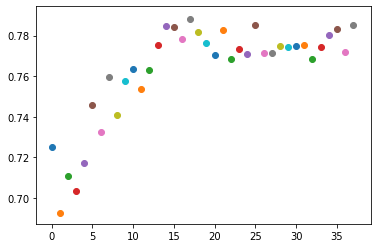

In [75]:
for data_dict in enumerate(outcomes.values()):
    x=data_dict[0]
    y = data_dict[1]
    plt.scatter(x,y)


In [76]:
outcomes_df = pd.DataFrame.from_dict(outcomes, orient='index').reset_index()

In [77]:
outcomes_df.columns = ['feature_selection', 'f2']

In [78]:
outcomes_df

feature_selection        f2
0                   1  0.724932
1                   2  0.692557
2                   3  0.711024
3                   4  0.703226
4                   5  0.717423
5                   6  0.745798
6                   7  0.732666
7                   8  0.759494
8                   9  0.740873
9                  10  0.757772
10                 11  0.763708
11                 12  0.753564
12                 13  0.762880
13                 14  0.775524
14                 15  0.784768
15                 16  0.784381
16                 17  0.778523
17                 18  0.788062
18                 19  0.781577
19                 20  0.776528
20                 21  0.770308
21                 22  0.782828
22                 23  0.768398
23                 24  0.773598
24                 25  0.770751
25                 26  0.785268
26                 27  0.771388
27                 28  0.771408
28                 29  0.774599
29                 30  0.774399
30                 31  0.774648
31                 32  0.775496
32                 33  0.768414
33                 34  0.774148
34                 35  0.780166
35                 36  0.783091
36                 37  0.771716
37                 38  0.785066

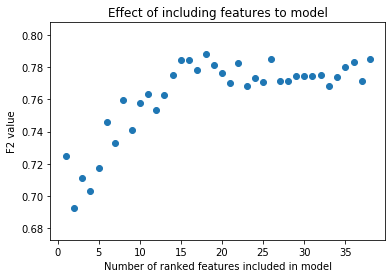

In [85]:
plt.scatter(outcomes_df['feature_selection'], outcomes_df['f2'])
plt.xlabel('Number of ranked features included in model')
plt.ylabel('F2 value')
plt.title('Effect of including features to model')
plt.savefig('feature_selection.png')

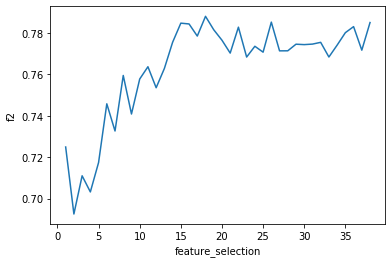

In [86]:
sns.lineplot(outcomes_df['feature_selection'], outcomes_df['f2'])

In [81]:
import operator
max(outcomes.items(), key=operator.itemgetter(1))[0]

18

In [88]:
ordered_features[:18]

['Glucose, refrigerated serum (mmol/L)',
 'Age',
 'metformin_0',
 'metformin_1',
 'LDL cholesterol (mmol/L)',
 'Gamma Glutamyl Transferase (GGT) (U/L)',
 'ace_arbs_0',
 'bmi',
 'ace_arbs_1',
 'Triglycerides, refrig serum (mg/dL)',
 'statin_0',
 'statin_1',
 'Chloride (mmol/L)',
 'insulin_0',
 'insulin_1',
 'Alkaline Phosphatase (ALP) (U/L)',
 'eGFR',
 'HDL cholesterol (mmol/L)']